In [ ]:
pip install sqlalchemy snowflake-sqlalchemy


In [1]:
import snowflake.connector
import pandas as pd

# Snowflake Connection Details
conn = snowflake.connector.connect(
    user="NEPHTHYS",
    password="Funcat1314",
    account="jub37779.us-east-1",
    warehouse="COMPUTE_WH",
    database="INSTACART_DB",
    schema="RAW"
)

# Create a cursor object
cur = conn.cursor()


In [2]:
query = "SHOW TABLES IN RAW"
df_tables = pd.read_sql(query, conn)
df_tables


/tmp/ipykernel_25225/234175030.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_tables = pd.read_sql(query, conn)


,created_on,name,database_name,schema_name,kind,comment,cluster_by,rows,bytes,owner,...,change_tracking,is_external,enable_schema_evolution,owner_role_type,is_event,budget,is_hybrid,is_iceberg,is_dynamic,is_immutable
0,2025-02-13 01:37:01.401000+00:00,aisles,INSTACART_DB,RAW,TABLE,,,134,3072,ACCOUNTADMIN,...,OFF,N,N,ROLE,N,None,N,N,N,N
1,2025-02-13 01:37:05.285000+00:00,departments,INSTACART_DB,RAW,TABLE,,,21,1536,ACCOUNTADMIN,...,OFF,N,N,ROLE,N,None,N,N,N,N
2,2025-02-13 01:06:53.523000+00:00,instacart_orders,INSTACART_DB,RAW,TABLE,,,478952,1318912,ACCOUNTADMIN,...,OFF,N,N,ROLE,N,None,N,N,N,N
3,2025-02-13 01:11:04.609000+00:00,order_products,INSTACART_DB,RAW,TABLE,,,3830046,20340736,ACCOUNTADMIN,...,OFF,N,N,ROLE,N,None,N,N,N,N
4,2025-02-13 01:10:13.689000+00:00,products,INSTACART_DB,RAW,TABLE,,,49694,1081856,ACCOUNTADMIN,...,OFF,N,N,ROLE,N,None,N,N,N,N


In [ ]:
A) Check Table Dimensions

In [3]:
tables = [
    "INSTACART_DB.RAW.\"instacart_orders\"",
    "INSTACART_DB.RAW.\"departments\"",
    "INSTACART_DB.RAW.\"aisles\"",
    "INSTACART_DB.RAW.\"order_products\"",
    "INSTACART_DB.RAW.\"products\""
]


# Inspecting dimensions (rows and columns) of each table
for table in tables:
    query = f"SELECT COUNT(*) AS num_rows FROM {table}"

    cur.execute(query)
    row_count = cur.fetchone()[0]

    query = f"SHOW COLUMNS IN {table}"
    cur.execute(query)
    col_count = len(cur.fetchall())

    print(f"📌 {table}: {row_count} rows, {col_count} columns")


📌 INSTACART_DB.RAW."instacart_orders": 478952 rows, 6 columns
📌 INSTACART_DB.RAW."departments": 21 rows, 2 columns
📌 INSTACART_DB.RAW."aisles": 134 rows, 2 columns
📌 INSTACART_DB.RAW."order_products": 3830046 rows, 4 columns
📌 INSTACART_DB.RAW."products": 49694 rows, 4 columns


In [ ]:
B) Get Basic Descriptive Statistics

In [4]:
for table in tables:
    query = f"SELECT * FROM {table} LIMIT 5"
    cur.execute(query)
    df = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])
    
    print(f"\n📊 Summary Statistics for {table}:")
    display(df.describe())



📊 Summary Statistics for INSTACART_DB.RAW."instacart_orders":


,order_id
count,5.00000
mean,12.60000
std,6.80441
min,4.00000
25%,9.00000
50%,11.00000
75%,19.00000
max,20.00000



📊 Summary Statistics for INSTACART_DB.RAW."departments":


,department_id
count,5.000000
mean,3.000000
std,1.581139
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,5.000000



📊 Summary Statistics for INSTACART_DB.RAW."aisles":


,aisle_id
count,5.000000
mean,3.000000
std,1.581139
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,5.000000



📊 Summary Statistics for INSTACART_DB.RAW."order_products":


,order_id,product_id,add_to_cart_order,reordered
count,5.0,5.000000,4.000000,4.0
mean,4.0,15082.800000,8.250000,1.0
std,0.0,10209.591236,2.753785,0.0
min,4.0,0.000000,5.000000,1.0
25%,4.0,10054.000000,6.500000,1.0
50%,4.0,17616.000000,8.500000,1.0
75%,4.0,22598.000000,10.250000,1.0
max,4.0,25146.000000,11.000000,1.0



📊 Summary Statistics for INSTACART_DB.RAW."products":


,product_id,aisle_id,department_id
count,5.000000,5.000000,5.000000
mean,3.000000,60.400000,10.600000
std,1.581139,40.623885,6.841053
min,1.000000,5.000000,1.000000
25%,2.000000,38.000000,7.000000
50%,3.000000,61.000000,13.000000
75%,4.000000,94.000000,13.000000
max,5.000000,104.000000,19.000000


In [ ]:
C) Check for Missing Values (NULLs)

In [5]:
# Define the tables and their columns
tables = [
    "INSTACART_DB.RAW.\"instacart_orders\"",
    "INSTACART_DB.RAW.\"departments\"",
    "INSTACART_DB.RAW.\"aisles\"",
    "INSTACART_DB.RAW.\"order_products\"",
    "INSTACART_DB.RAW.\"products\""
]

table_columns = {
    "INSTACART_DB.RAW.\"aisles\"": ["\"aisle_id\"", "\"aisle\""],
    "INSTACART_DB.RAW.\"departments\"": ["\"department_id\"", "\"department\""],
    "INSTACART_DB.RAW.\"instacart_orders\"": ["\"order_id\"", "\"user_id\"", "\"order_number\"", "\"order_dow\"", "\"order_hour_of_day\"", "\"days_since_prior_order\""],
    "INSTACART_DB.RAW.\"order_products\"": ["\"order_id\"", "\"product_id\"", "\"add_to_cart_order\"", "\"reordered\""],
    "INSTACART_DB.RAW.\"products\"": ["\"product_id\"", "\"product_name\"", "\"aisle_id\"", "\"department_id\""]
}

# Checking for missing values (NULLs) for all rows
for table in tables:
    # Get the list of columns for the current table
    columns = table_columns.get(table, [])
    
    # Construct the SELECT query dynamically to count NULLs for each column
    null_count_query_parts = [
        f"SUM(CASE WHEN {column} IS NULL THEN 1 ELSE 0 END) AS missing_{column.strip('\"')}" for column in columns
    ]
    null_count_query = f"SELECT {', '.join(null_count_query_parts)} FROM {table}"
    
    # Execute the query
    cur.execute(null_count_query)
    result = cur.fetchall()
    
    # Print missing values for each column
    print(f"\n🛑 Missing Values in {table}:")
    for desc, value in zip(cur.description, result[0]):
        print(f"{desc[0]}: {value}")



🛑 Missing Values in INSTACART_DB.RAW."instacart_orders":
MISSING_ORDER_ID: 0
MISSING_USER_ID: 478952
MISSING_ORDER_NUMBER: 478952
MISSING_ORDER_DOW: 478952
MISSING_ORDER_HOUR_OF_DAY: 478952
MISSING_DAYS_SINCE_PRIOR_ORDER: 478952

🛑 Missing Values in INSTACART_DB.RAW."departments":
MISSING_DEPARTMENT_ID: 0
MISSING_DEPARTMENT: 0

🛑 Missing Values in INSTACART_DB.RAW."aisles":
MISSING_AISLE_ID: 0
MISSING_AISLE: 0

🛑 Missing Values in INSTACART_DB.RAW."order_products":
MISSING_ORDER_ID: 0
MISSING_PRODUCT_ID: 0
MISSING_ADD_TO_CART_ORDER: 450677
MISSING_REORDERED: 450046

🛑 Missing Values in INSTACART_DB.RAW."products":
MISSING_PRODUCT_ID: 0
MISSING_PRODUCT_NAME: 1258
MISSING_AISLE_ID: 0
MISSING_DEPARTMENT_ID: 0


In [ ]:
D) Detect Duplicates

In [6]:
# Define the tables and their columns
tables = [
    "INSTACART_DB.RAW.\"instacart_orders\"",
    "INSTACART_DB.RAW.\"departments\"",
    "INSTACART_DB.RAW.\"aisles\"",
    "INSTACART_DB.RAW.\"order_products\"",
    "INSTACART_DB.RAW.\"products\""
]

table_columns = {
    "INSTACART_DB.RAW.\"aisles\"": ["\"aisle_id\"", "\"aisle\""],
    "INSTACART_DB.RAW.\"departments\"": ["\"department_id\"", "\"department\""],
    "INSTACART_DB.RAW.\"instacart_orders\"": ["\"order_id\"", "\"user_id\"", "\"order_number\"", "\"order_dow\"", "\"order_hour_of_day\"", "\"days_since_prior_order\""],
    "INSTACART_DB.RAW.\"order_products\"": ["\"order_id\"", "\"product_id\"", "\"add_to_cart_order\"", "\"reordered\""],
    "INSTACART_DB.RAW.\"products\"": ["\"product_id\"", "\"product_name\"", "\"aisle_id\"", "\"department_id\""]
}
# Checking for duplicate rows in each table
for table in tables:
    try:
        # Use the predefined columns from table_columns
        columns = table_columns[table]
        
        # Construct the query dynamically using the predefined columns
        column_names = ', '.join(columns)  # No need to quote the column names anymore
        
        # Query to check for duplicate rows
        query = f"""
            SELECT COUNT(*) - COUNT(DISTINCT {column_names}) AS duplicates
            FROM {table}
        """
        
        # Execute the query and fetch the result
        cur.execute(query)
        duplicates = cur.fetchone()[0]
        
        print(f"🔄 {table} has {duplicates} duplicate rows")
    
    except Exception as e:
        print(f"Error with table {table}: {e}")


🔄 INSTACART_DB.RAW."instacart_orders" has 478952 duplicate rows
🔄 INSTACART_DB.RAW."departments" has 0 duplicate rows
🔄 INSTACART_DB.RAW."aisles" has 0 duplicate rows
🔄 INSTACART_DB.RAW."order_products" has 450677 duplicate rows
🔄 INSTACART_DB.RAW."products" has 1258 duplicate rows


In [ ]:
F)Data Type Consistency

In [7]:
# Checking data types for each column
for table in tables:
    query = f"DESCRIBE TABLE {table}"
    cur.execute(query)
    result = cur.fetchall()

    # Print the number of columns returned to help identify the structure
    print(f"Number of columns in {table}: {len(result[0])}")

    # Define the columns based on the result length (it may vary)
    columns = ["column_name", "type", "kind", "null?", "default", "primary key", "unique key", "check", "expression", "extra", "comment", "last_modified"]

    # Check if the number of columns returned is consistent with the length of the column names
    if len(result[0]) == len(columns):
        df = pd.DataFrame(result, columns=columns)
        print(f"\n📑 Data Types in {table}:")
        display(df[["column_name", "type"]])
    else:
        print(f"Mismatch in the number of columns for {table}. Expected {len(columns)} but got {len(result[0])}.")


Number of columns in INSTACART_DB.RAW."instacart_orders": 12

📑 Data Types in INSTACART_DB.RAW."instacart_orders":


,column_name,type
0,order_id,"NUMBER(38,0)"
1,user_id,"NUMBER(38,0)"
2,order_number,"NUMBER(38,0)"
3,order_dow,"NUMBER(38,0)"
4,order_hour_of_day,"NUMBER(38,0)"
5,days_since_prior_order,"NUMBER(38,0)"


Number of columns in INSTACART_DB.RAW."departments": 12

📑 Data Types in INSTACART_DB.RAW."departments":


,column_name,type
0,department_id,"NUMBER(38,0)"
1,department,VARCHAR(16777216)


Number of columns in INSTACART_DB.RAW."aisles": 12

📑 Data Types in INSTACART_DB.RAW."aisles":


,column_name,type
0,aisle_id,"NUMBER(38,0)"
1,aisle,VARCHAR(16777216)


Number of columns in INSTACART_DB.RAW."order_products": 12

📑 Data Types in INSTACART_DB.RAW."order_products":


,column_name,type
0,order_id,"NUMBER(38,0)"
1,product_id,"NUMBER(38,0)"
2,add_to_cart_order,FLOAT
3,reordered,FLOAT


Number of columns in INSTACART_DB.RAW."products": 12

📑 Data Types in INSTACART_DB.RAW."products":


,column_name,type
0,product_id,"NUMBER(38,0)"
1,product_name,VARCHAR(16777216)
2,aisle_id,"NUMBER(38,0)"
3,department_id,"NUMBER(38,0)"


In [ ]:
G) Detect Outliers using Boxplots

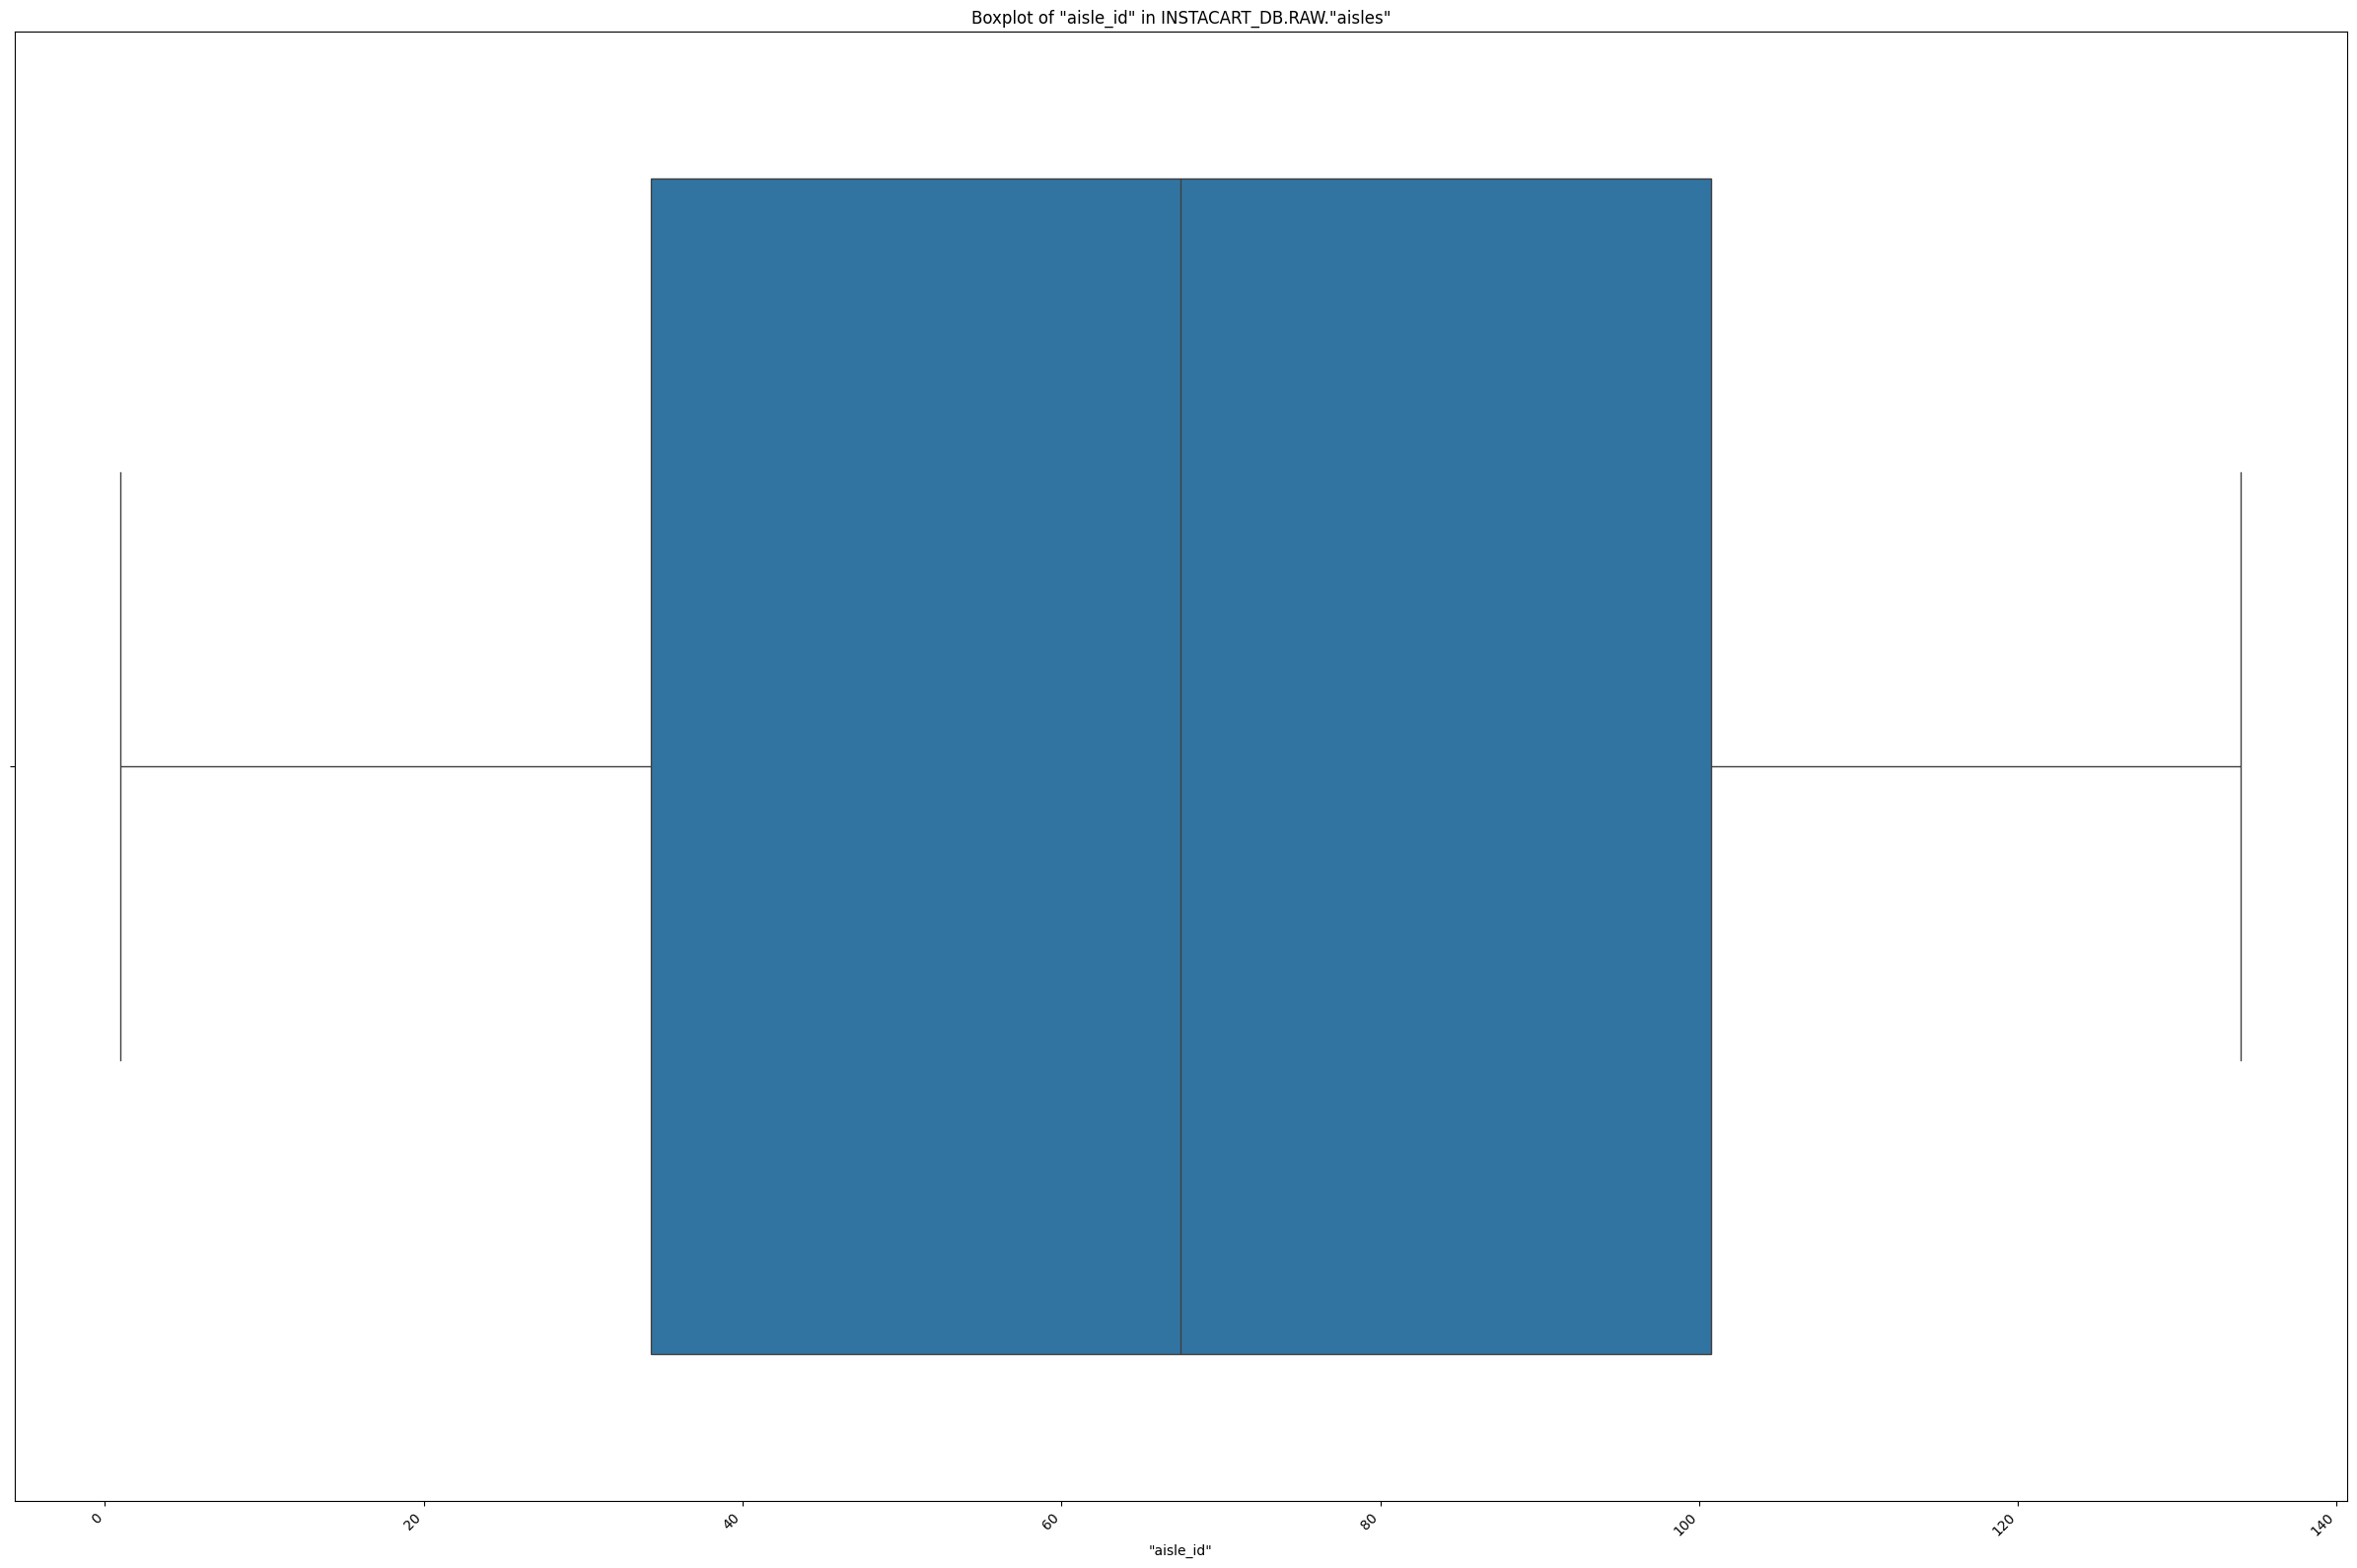

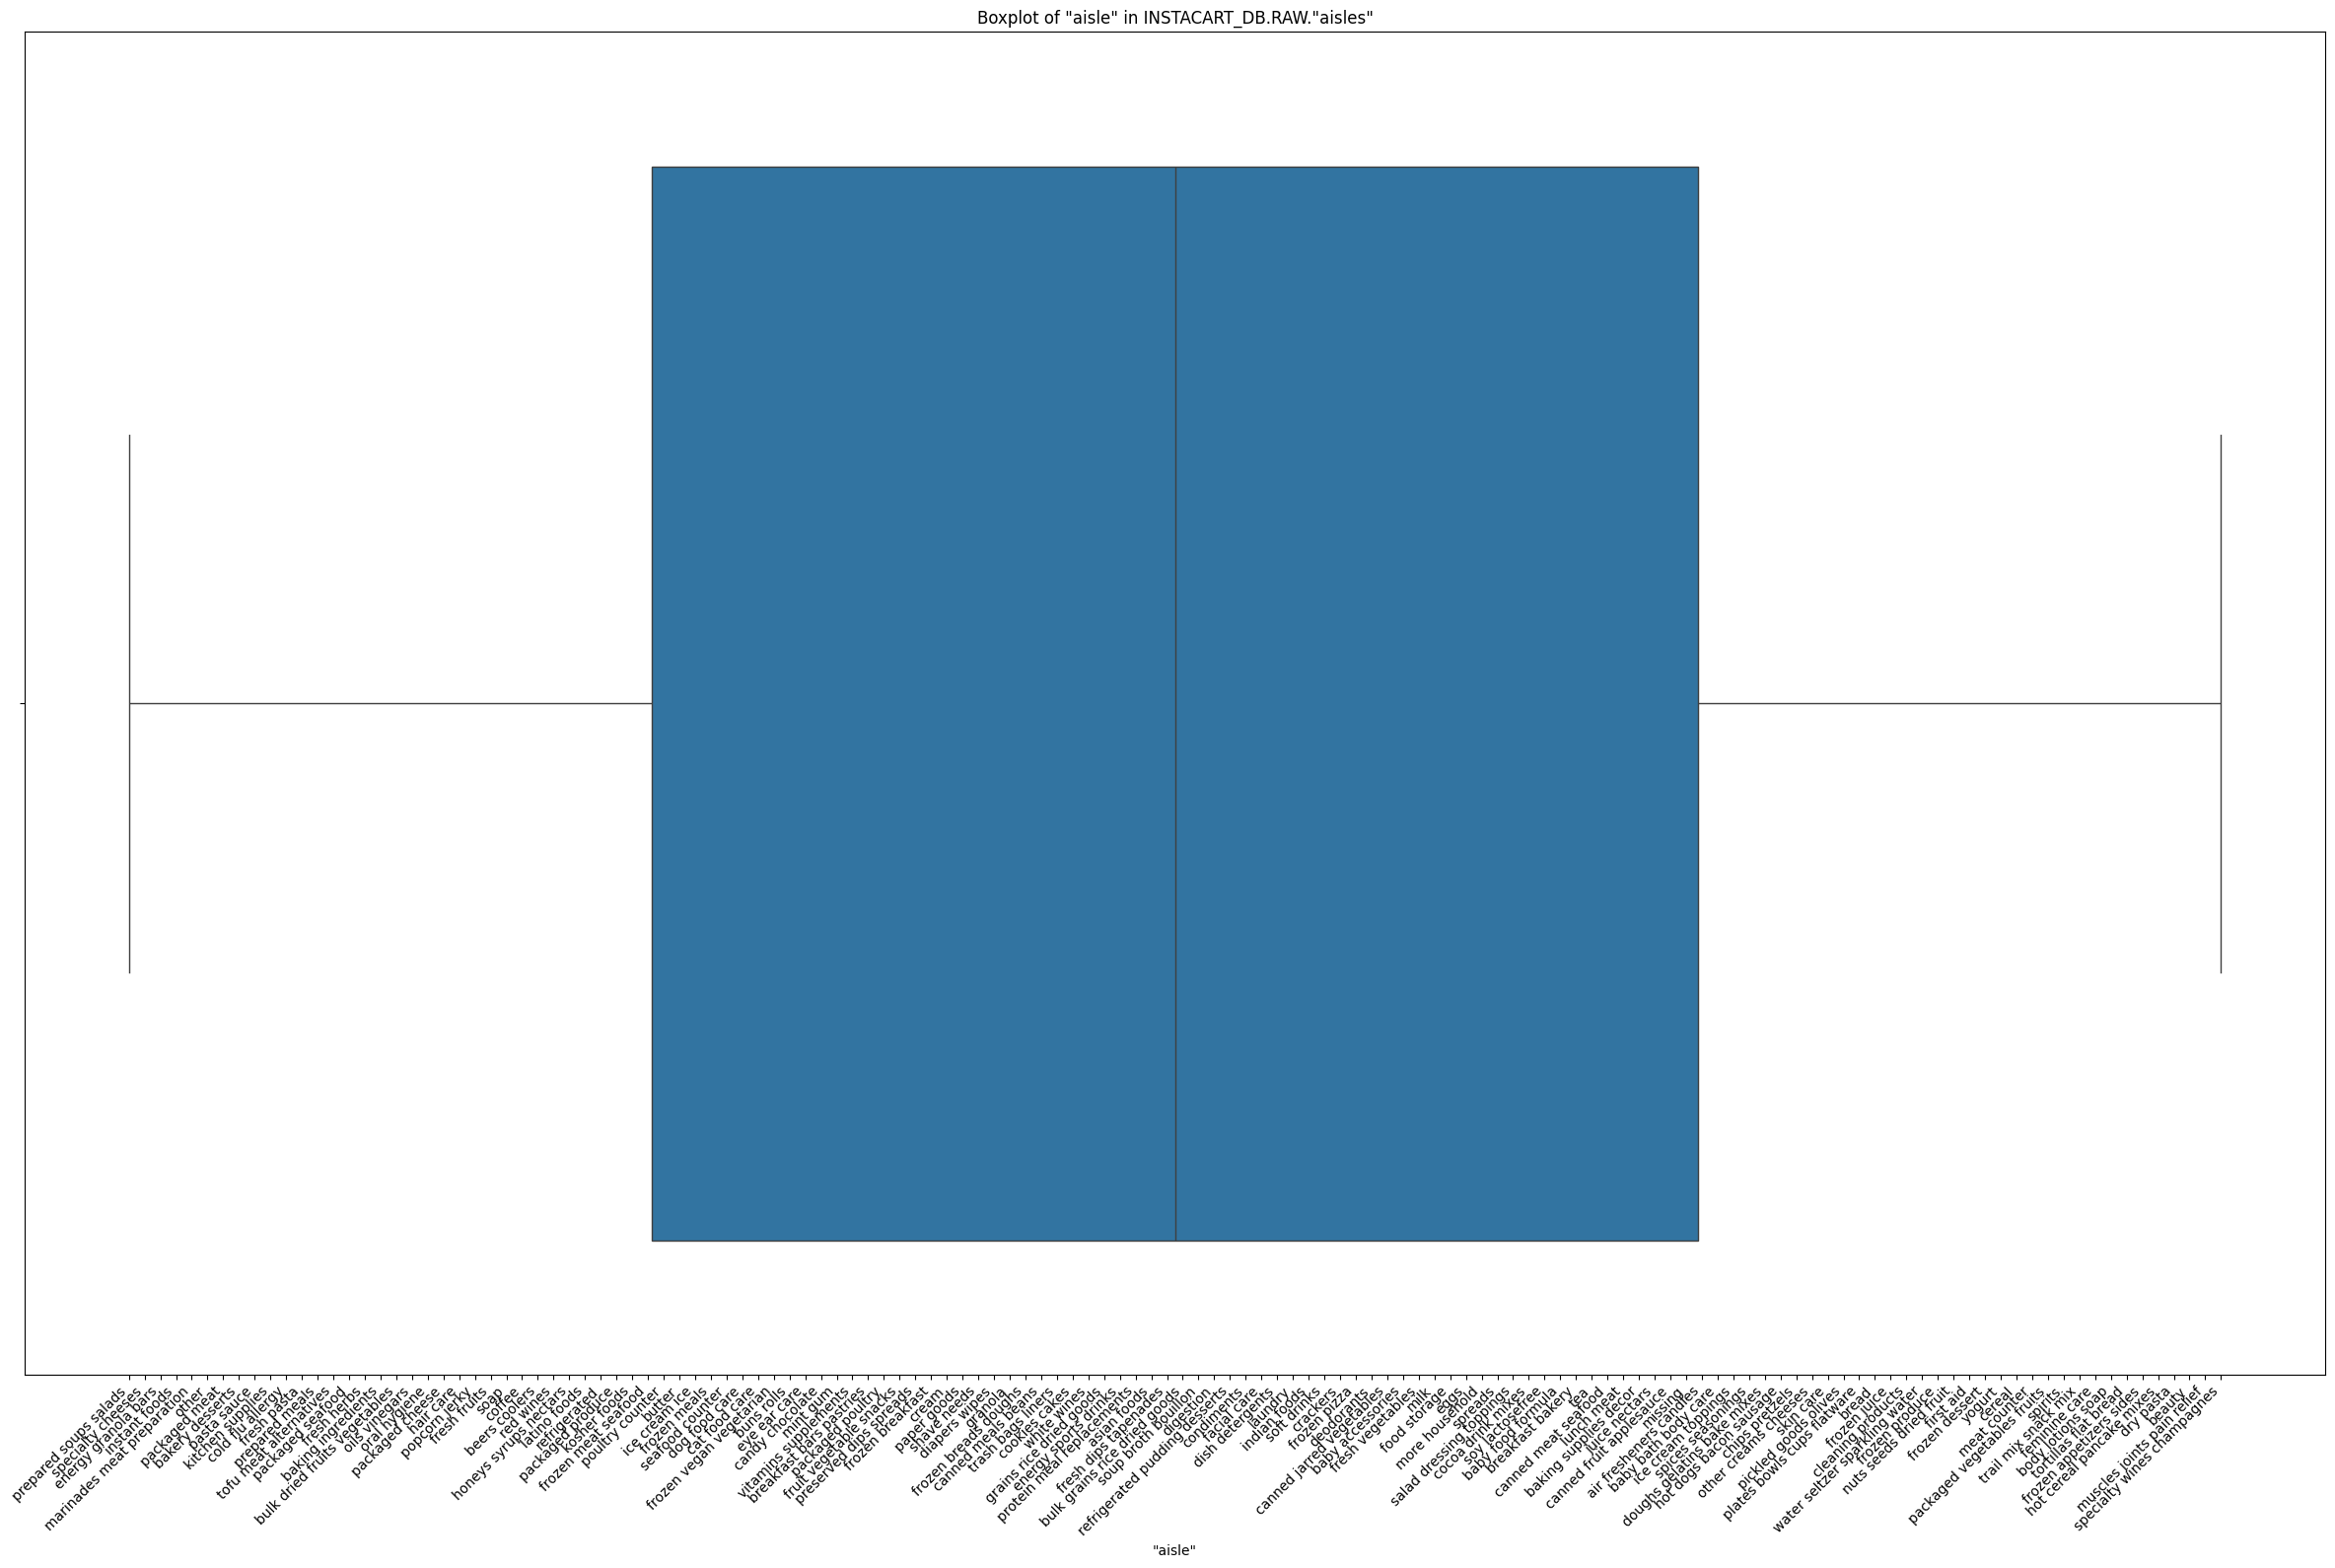

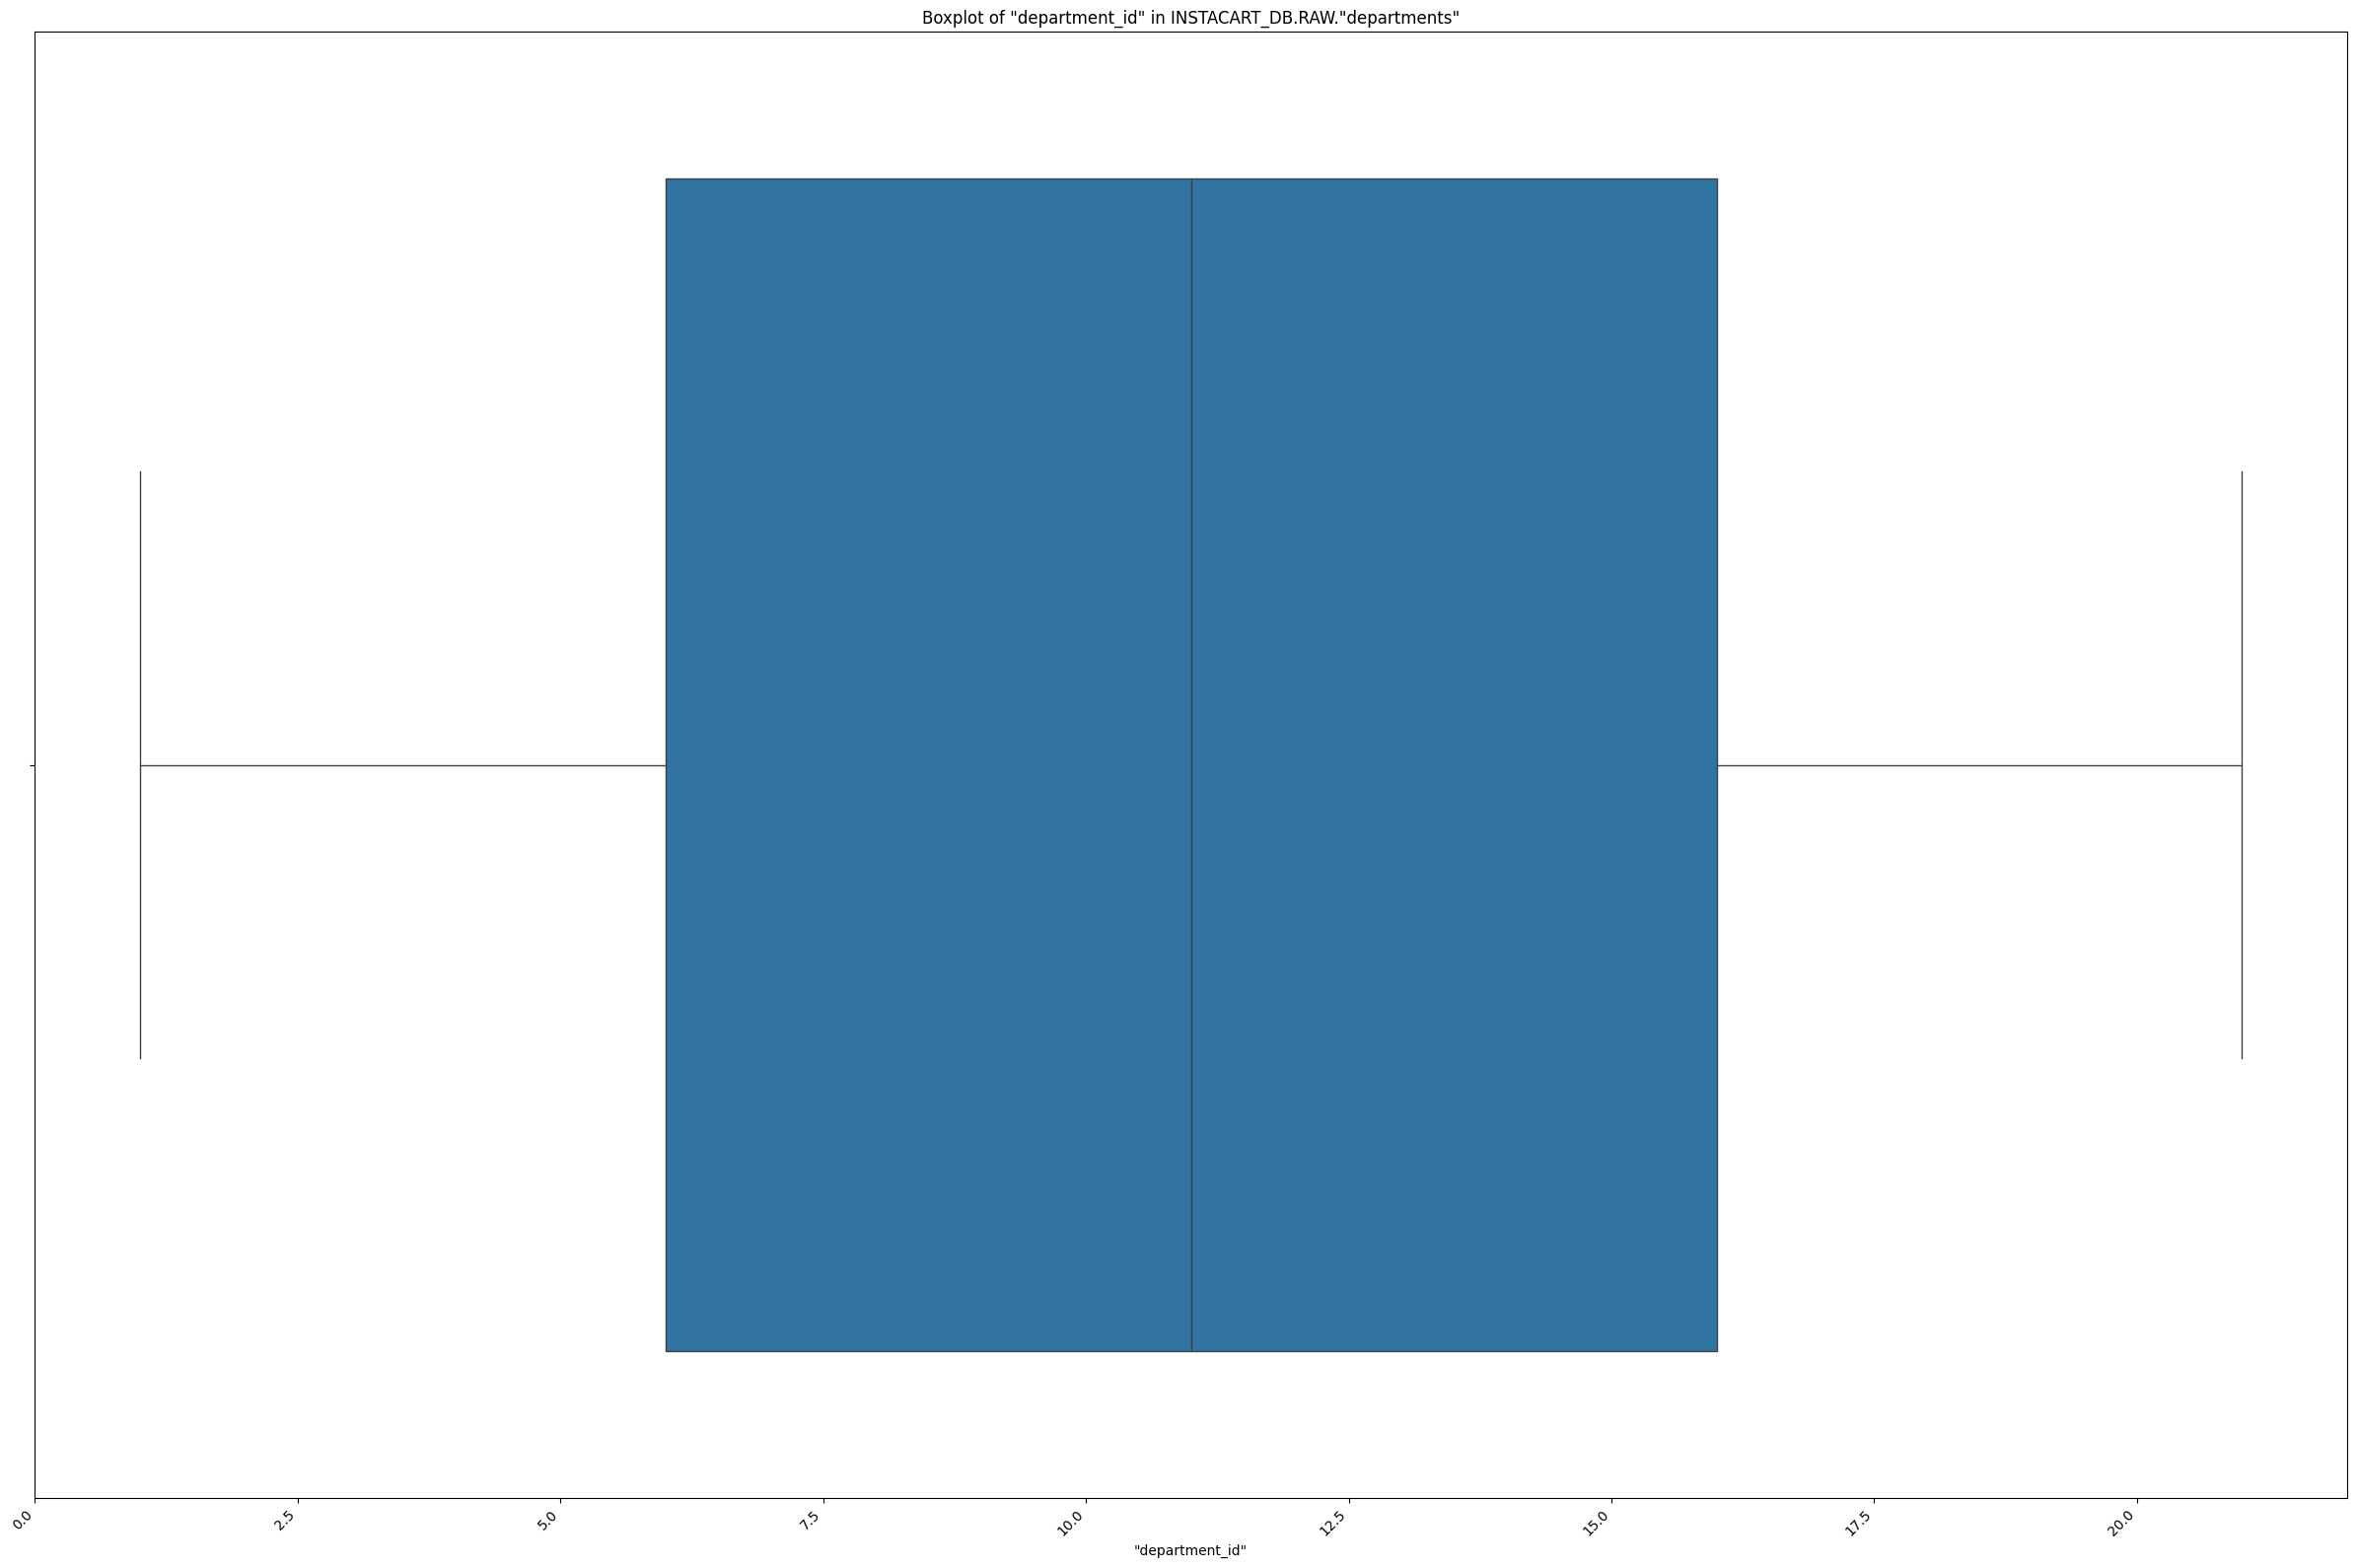

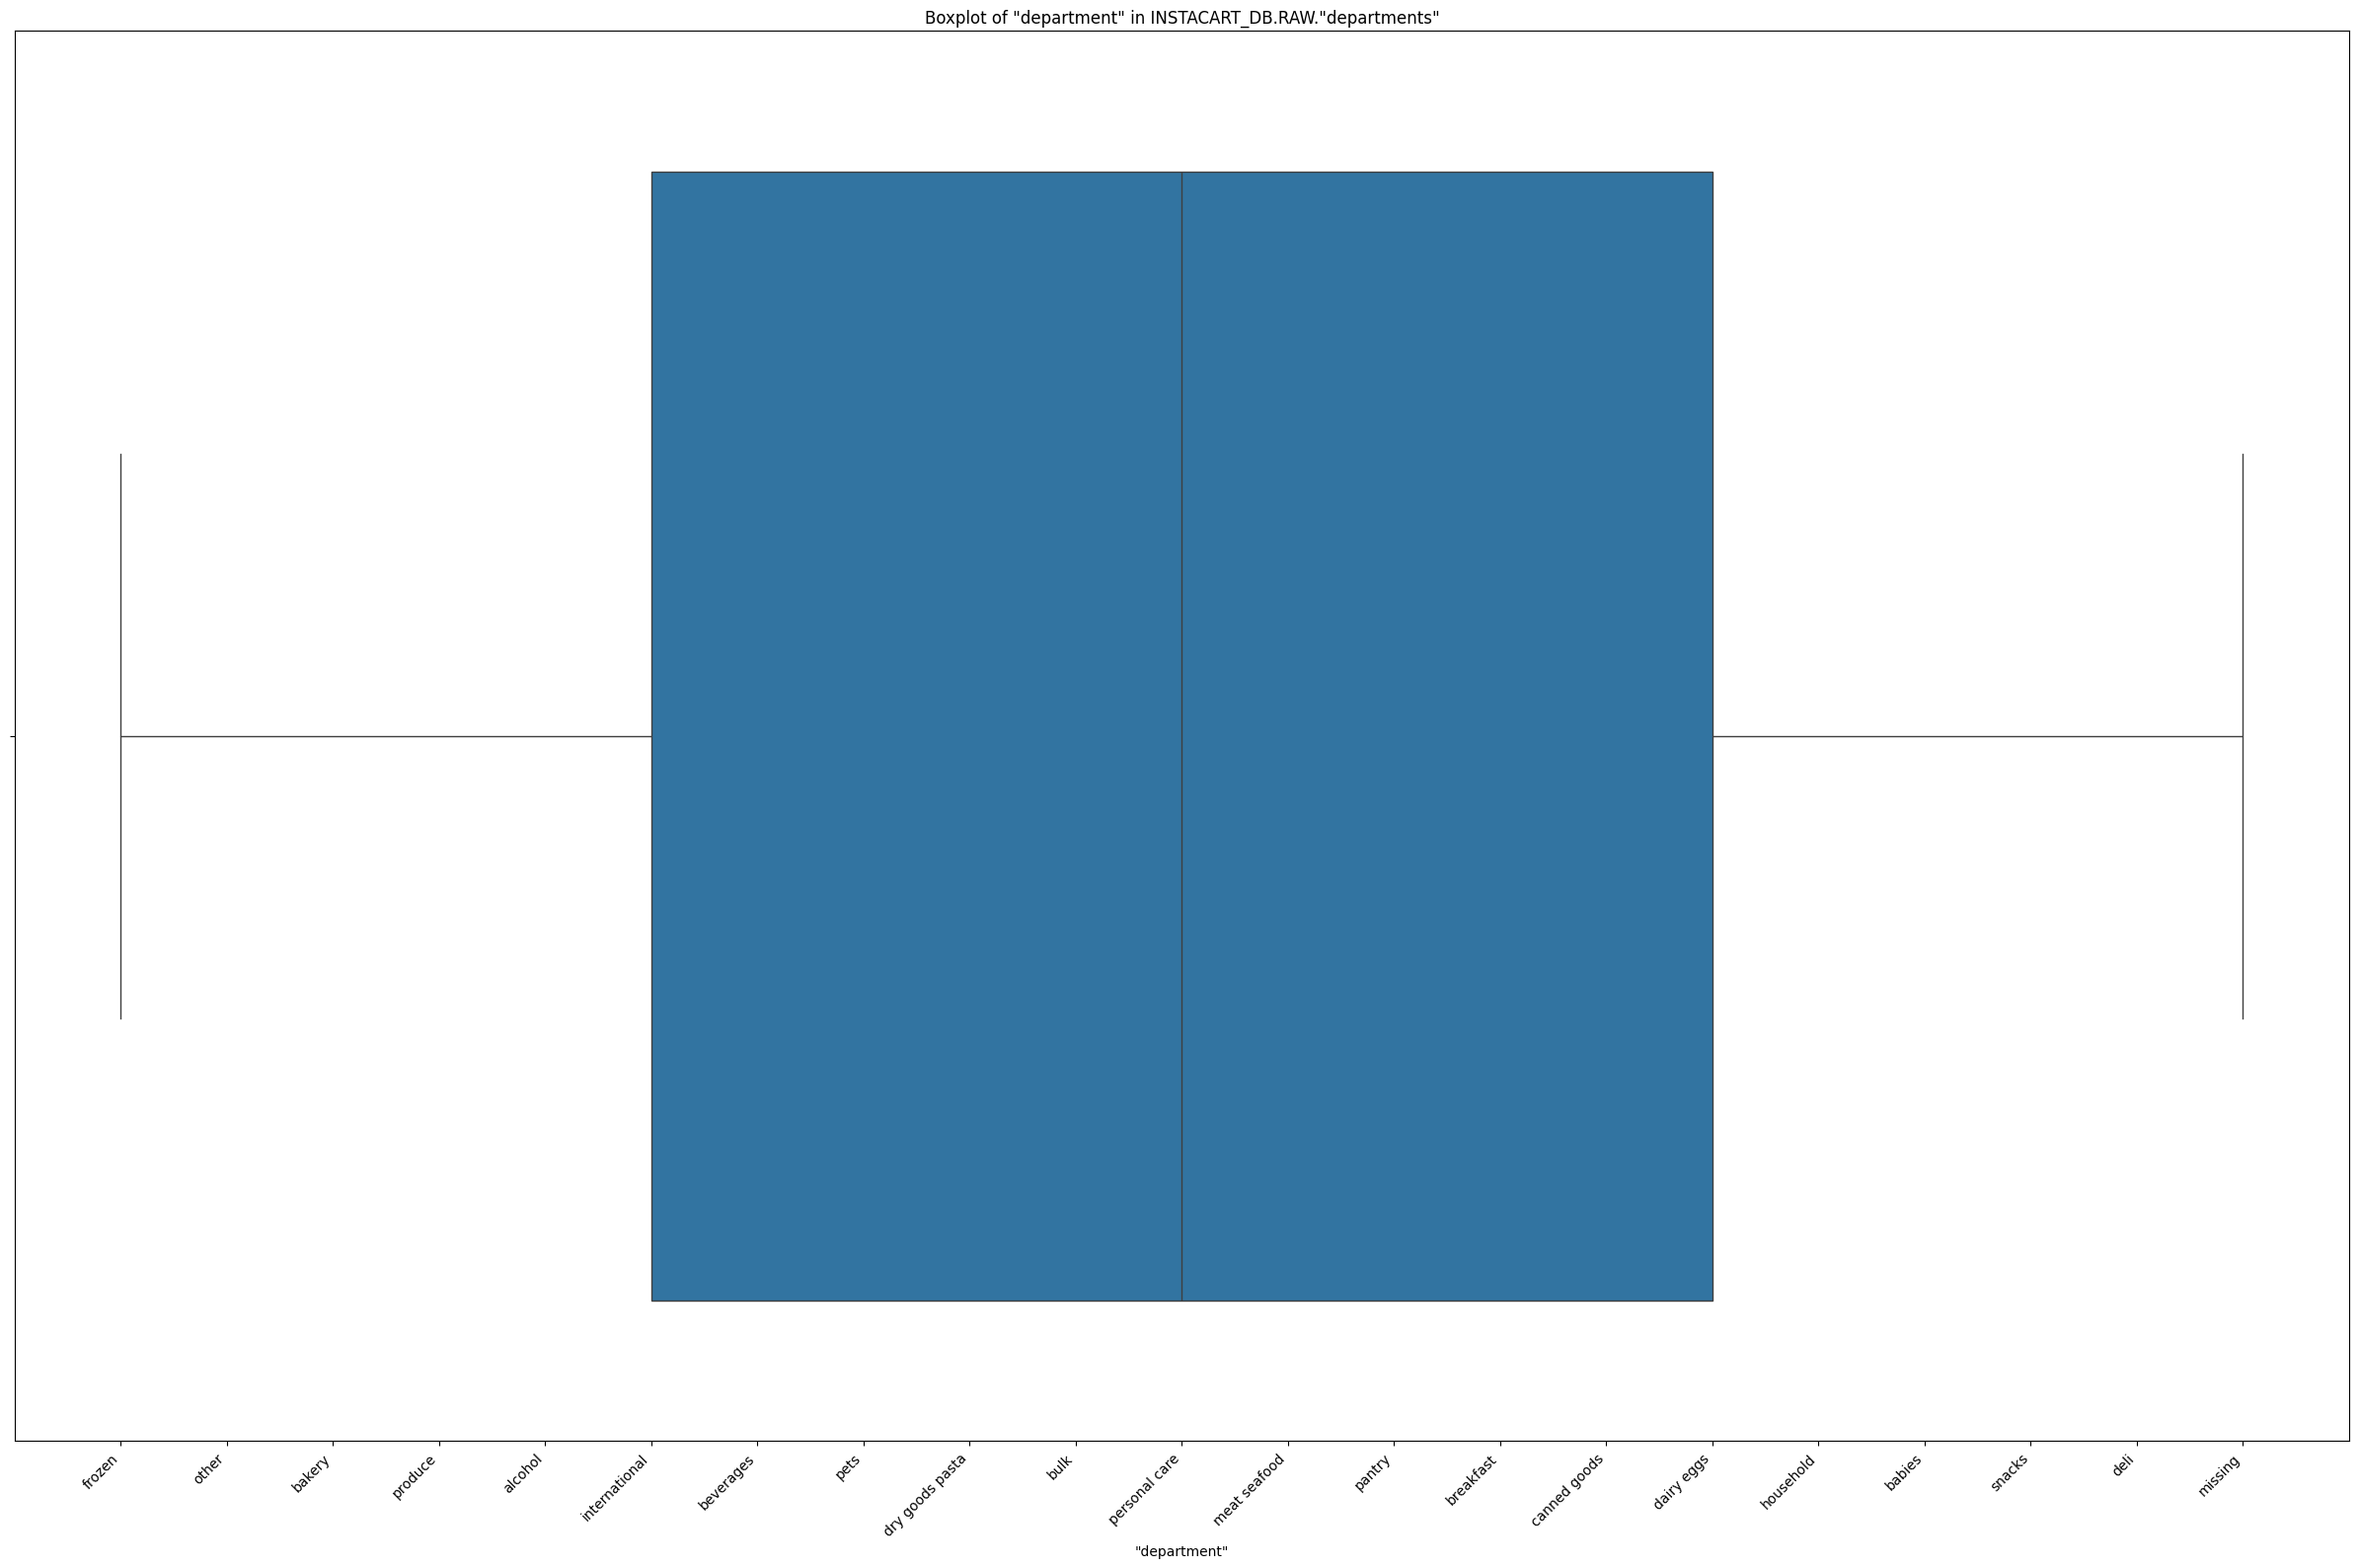

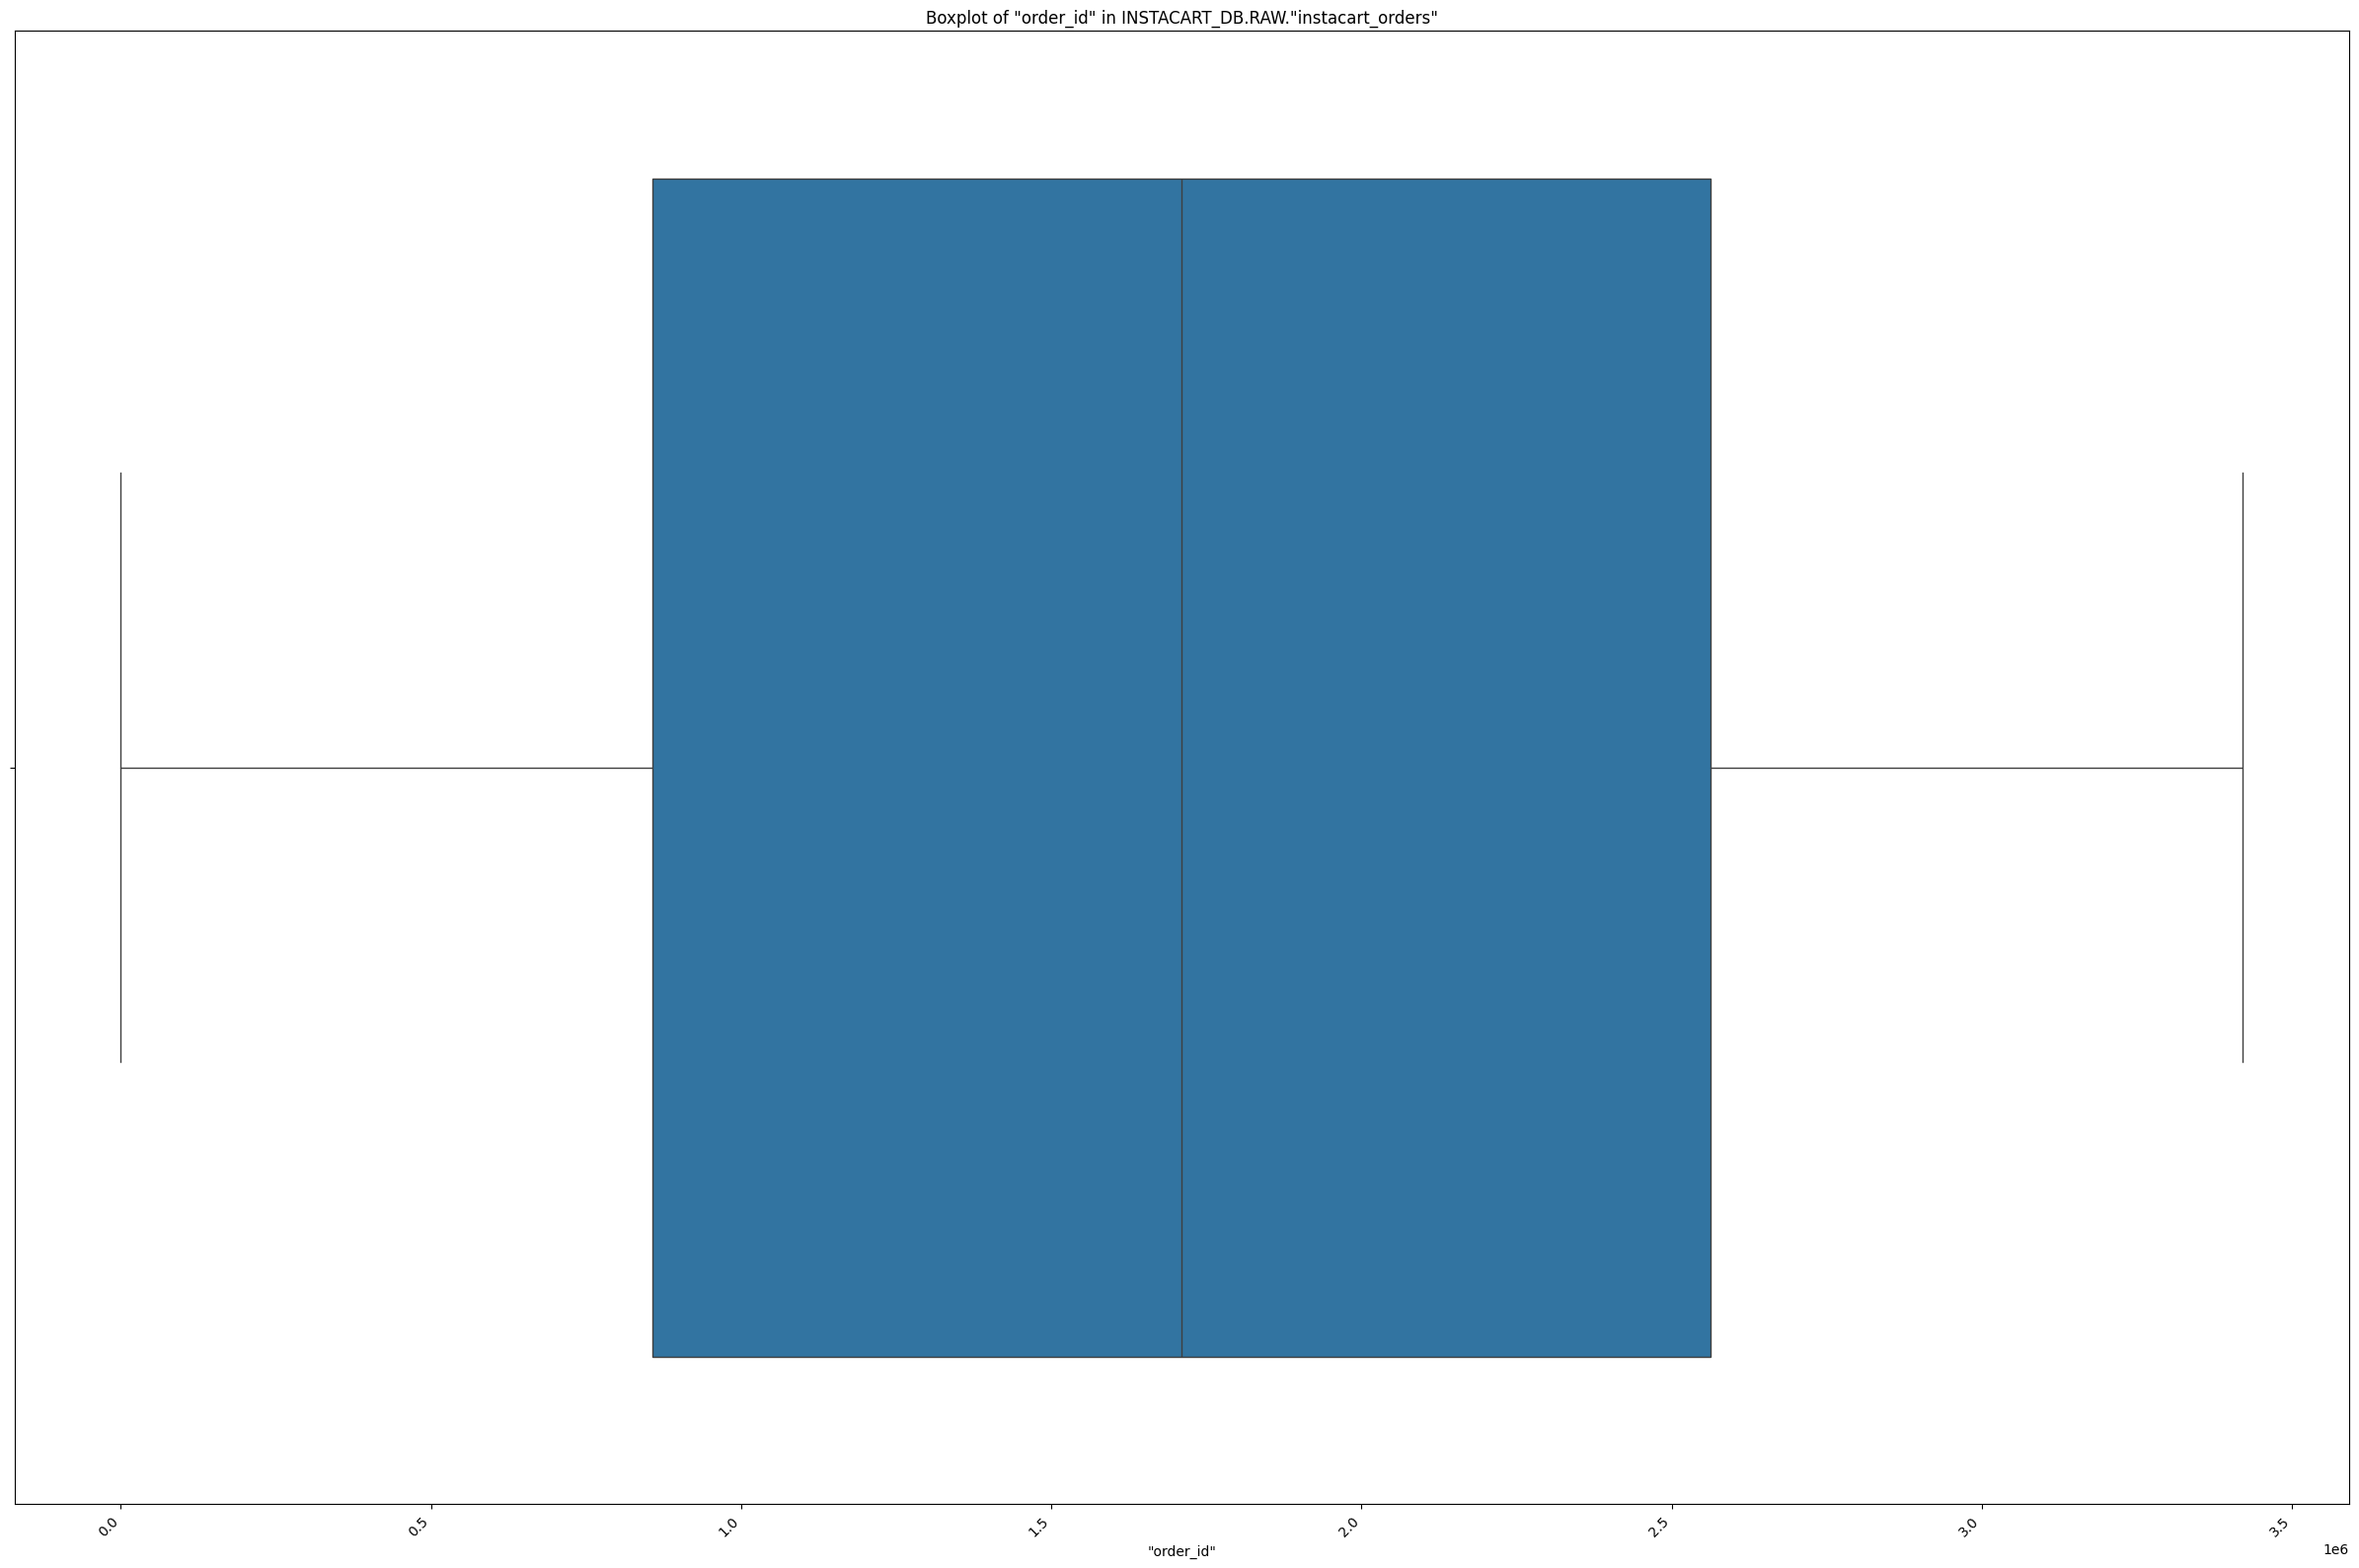

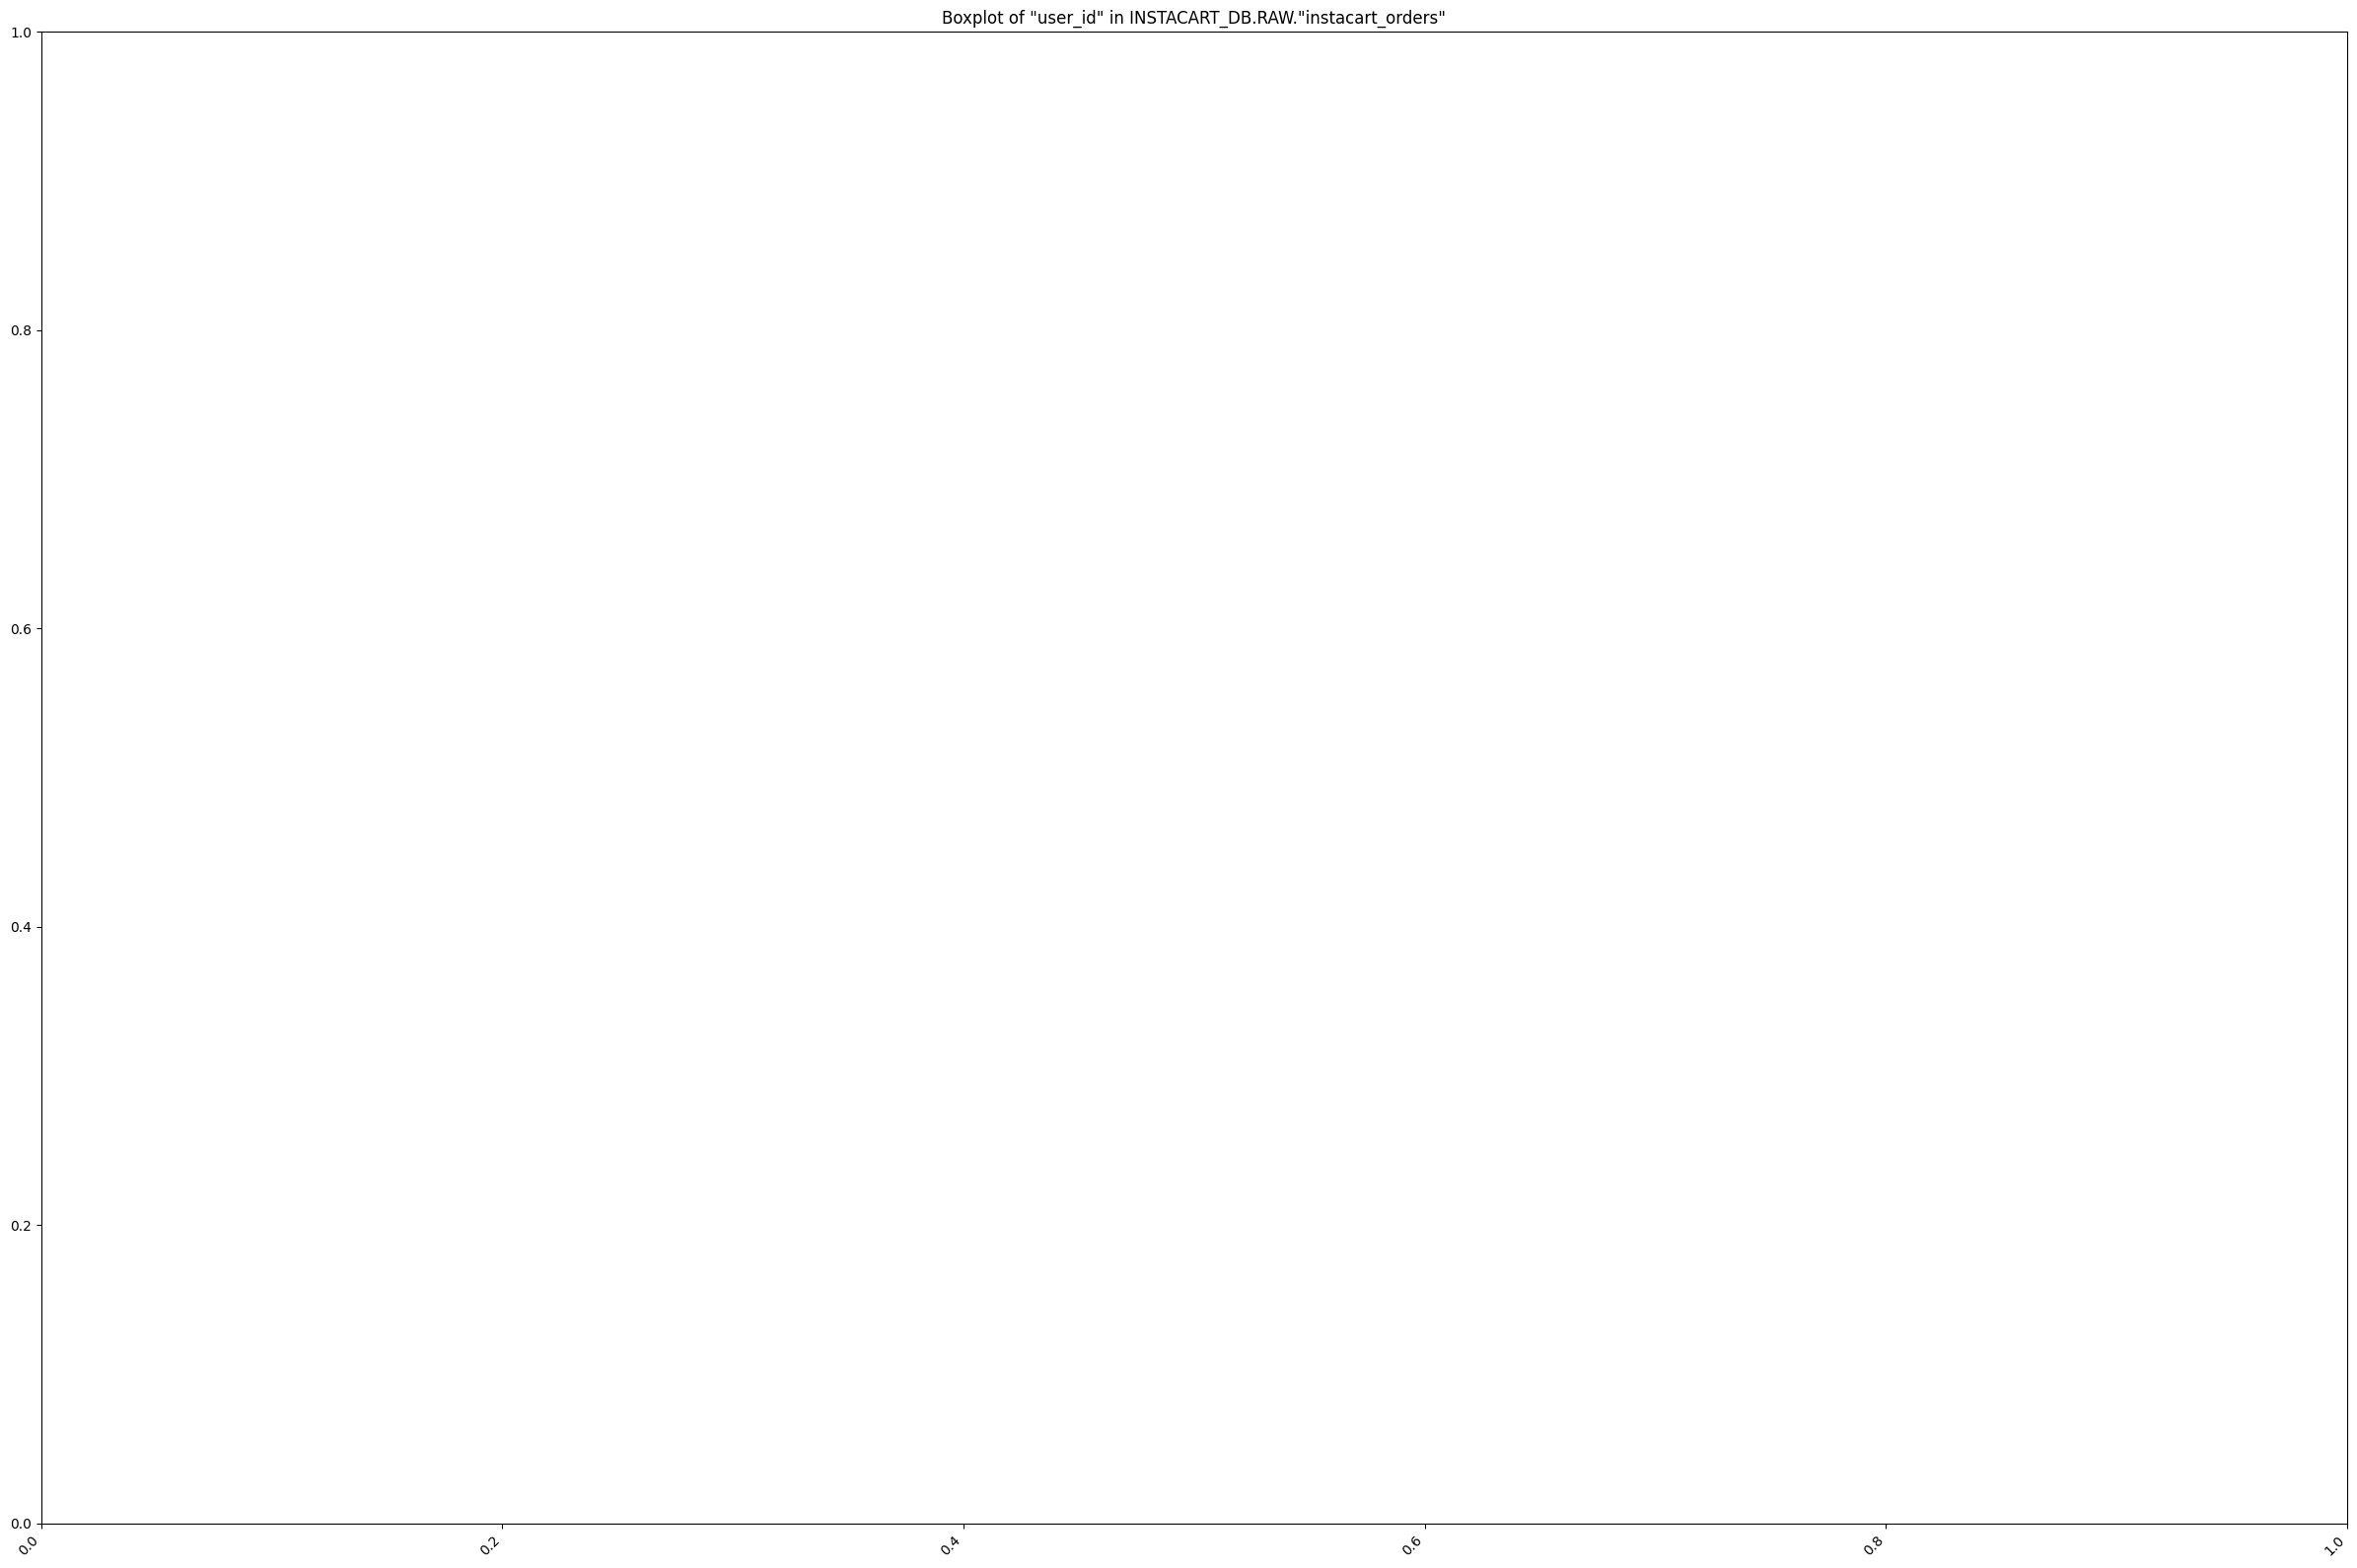

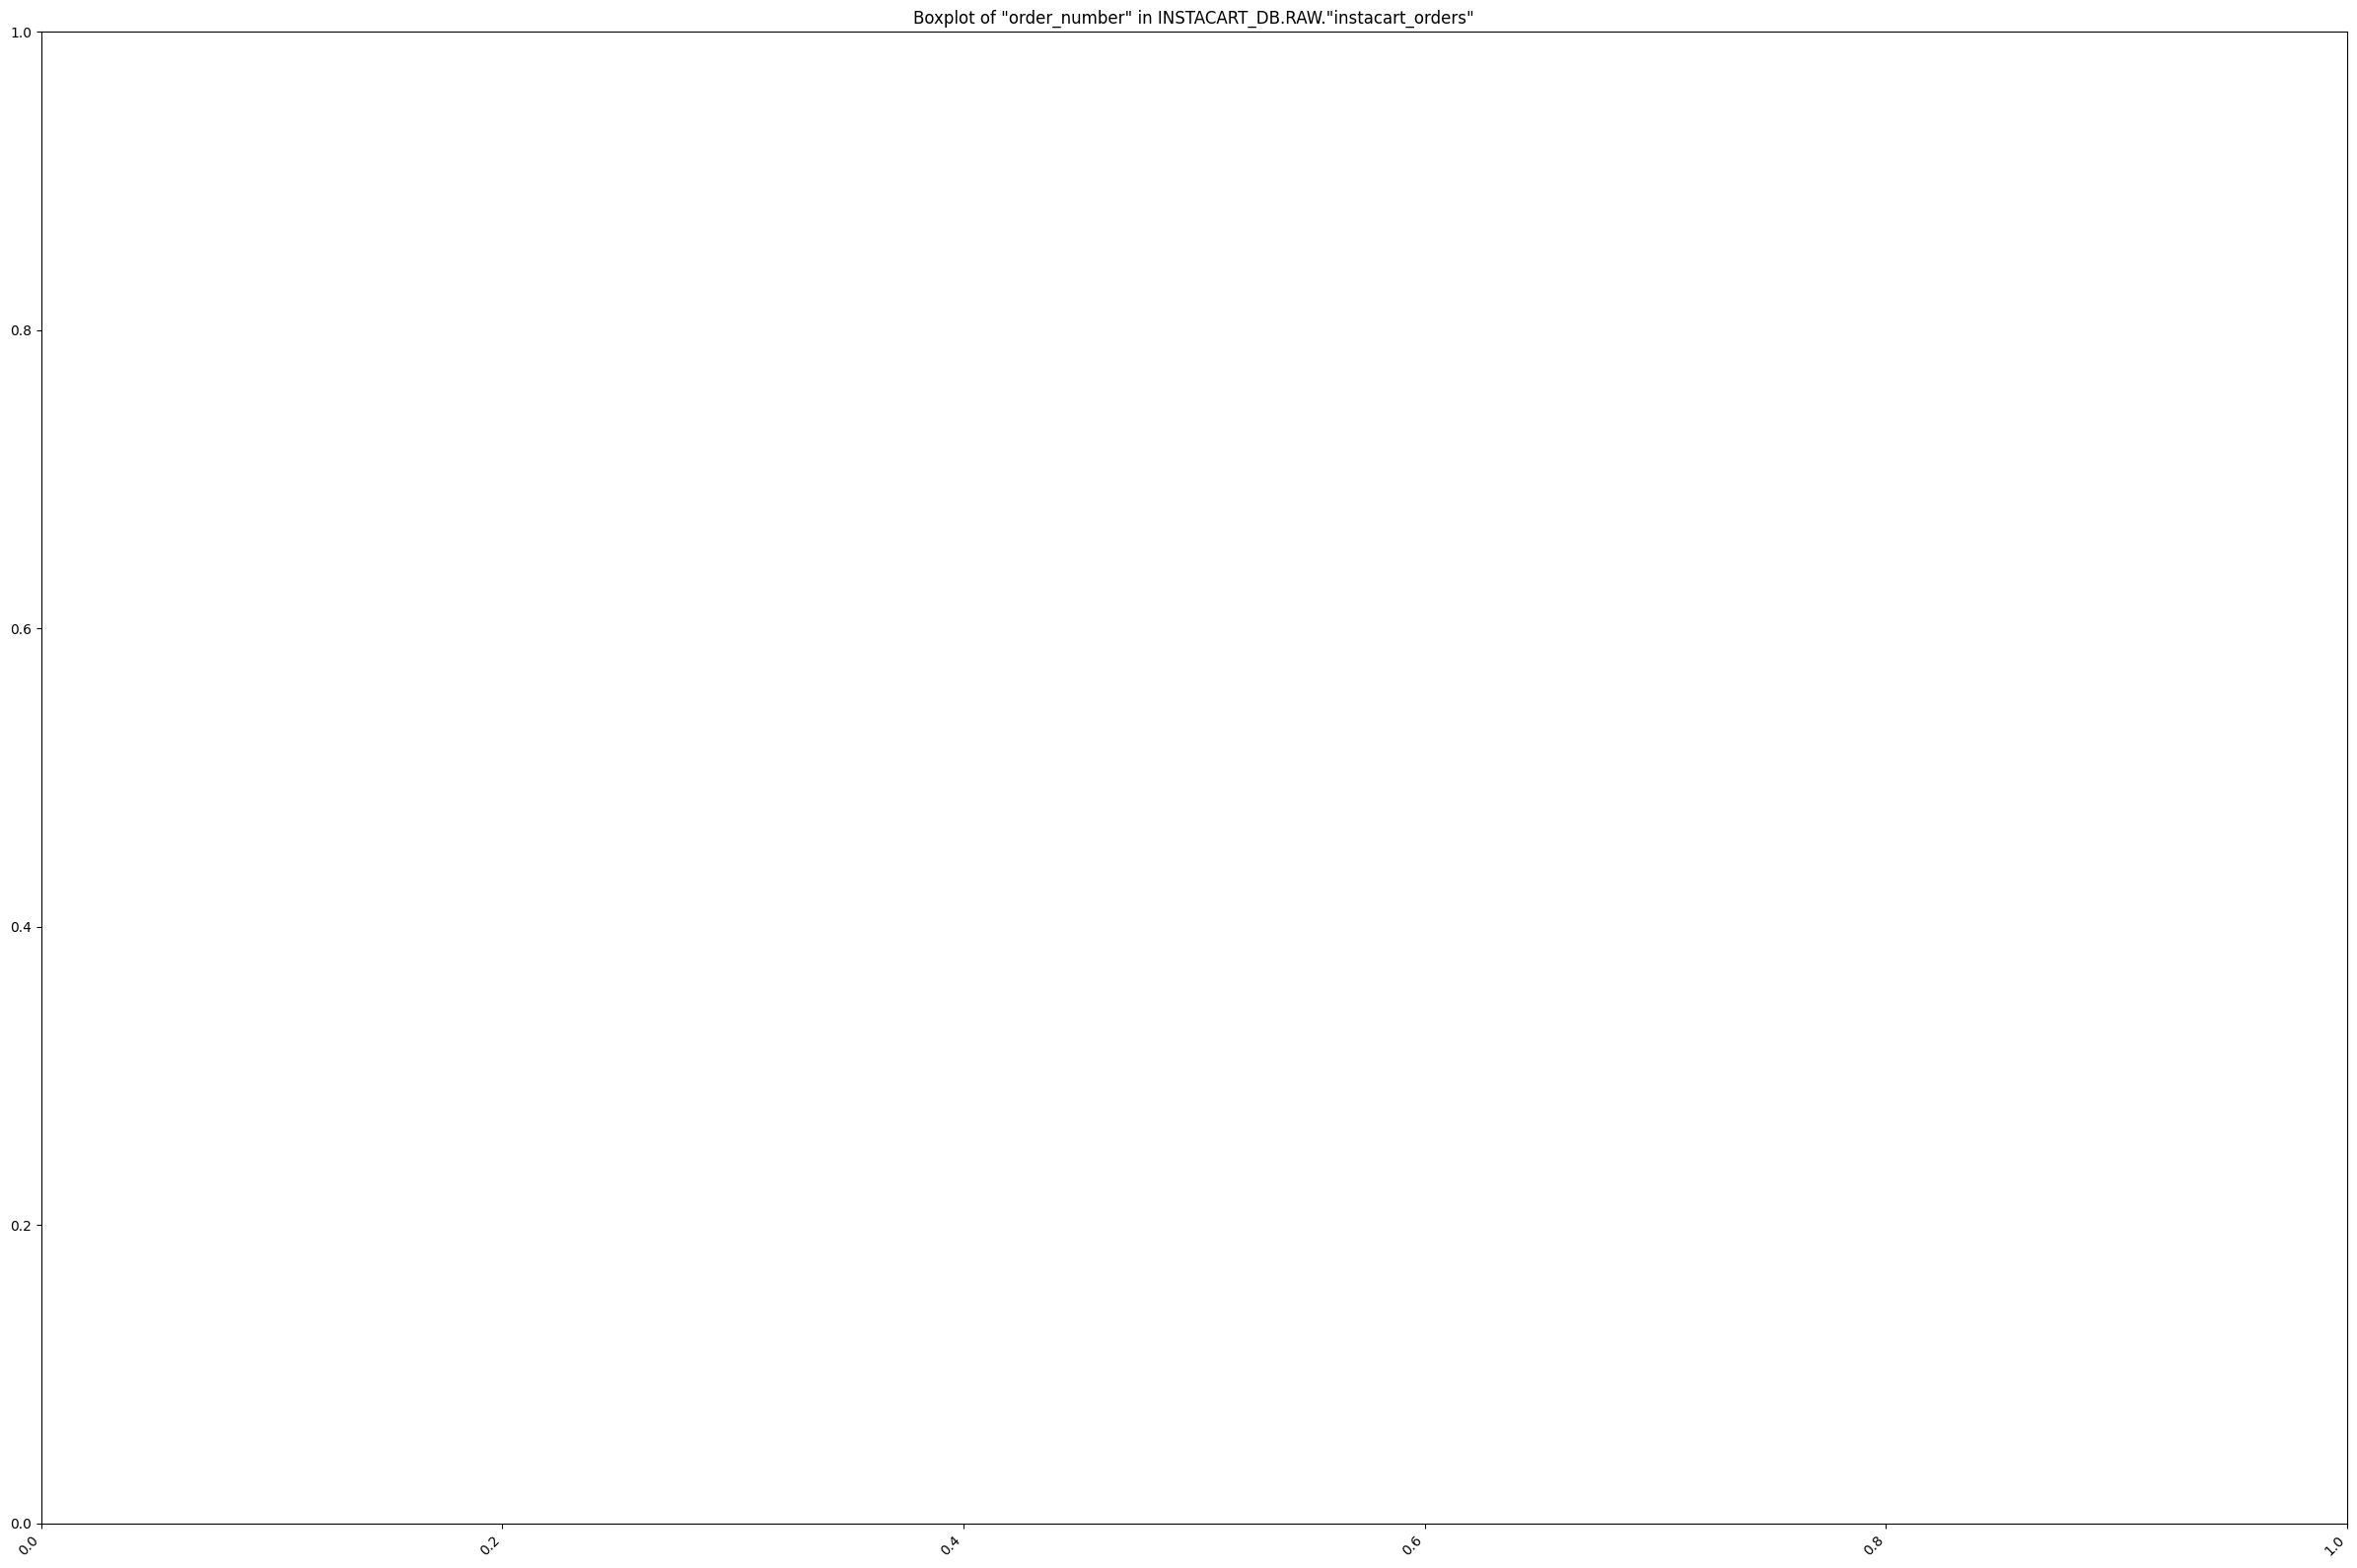

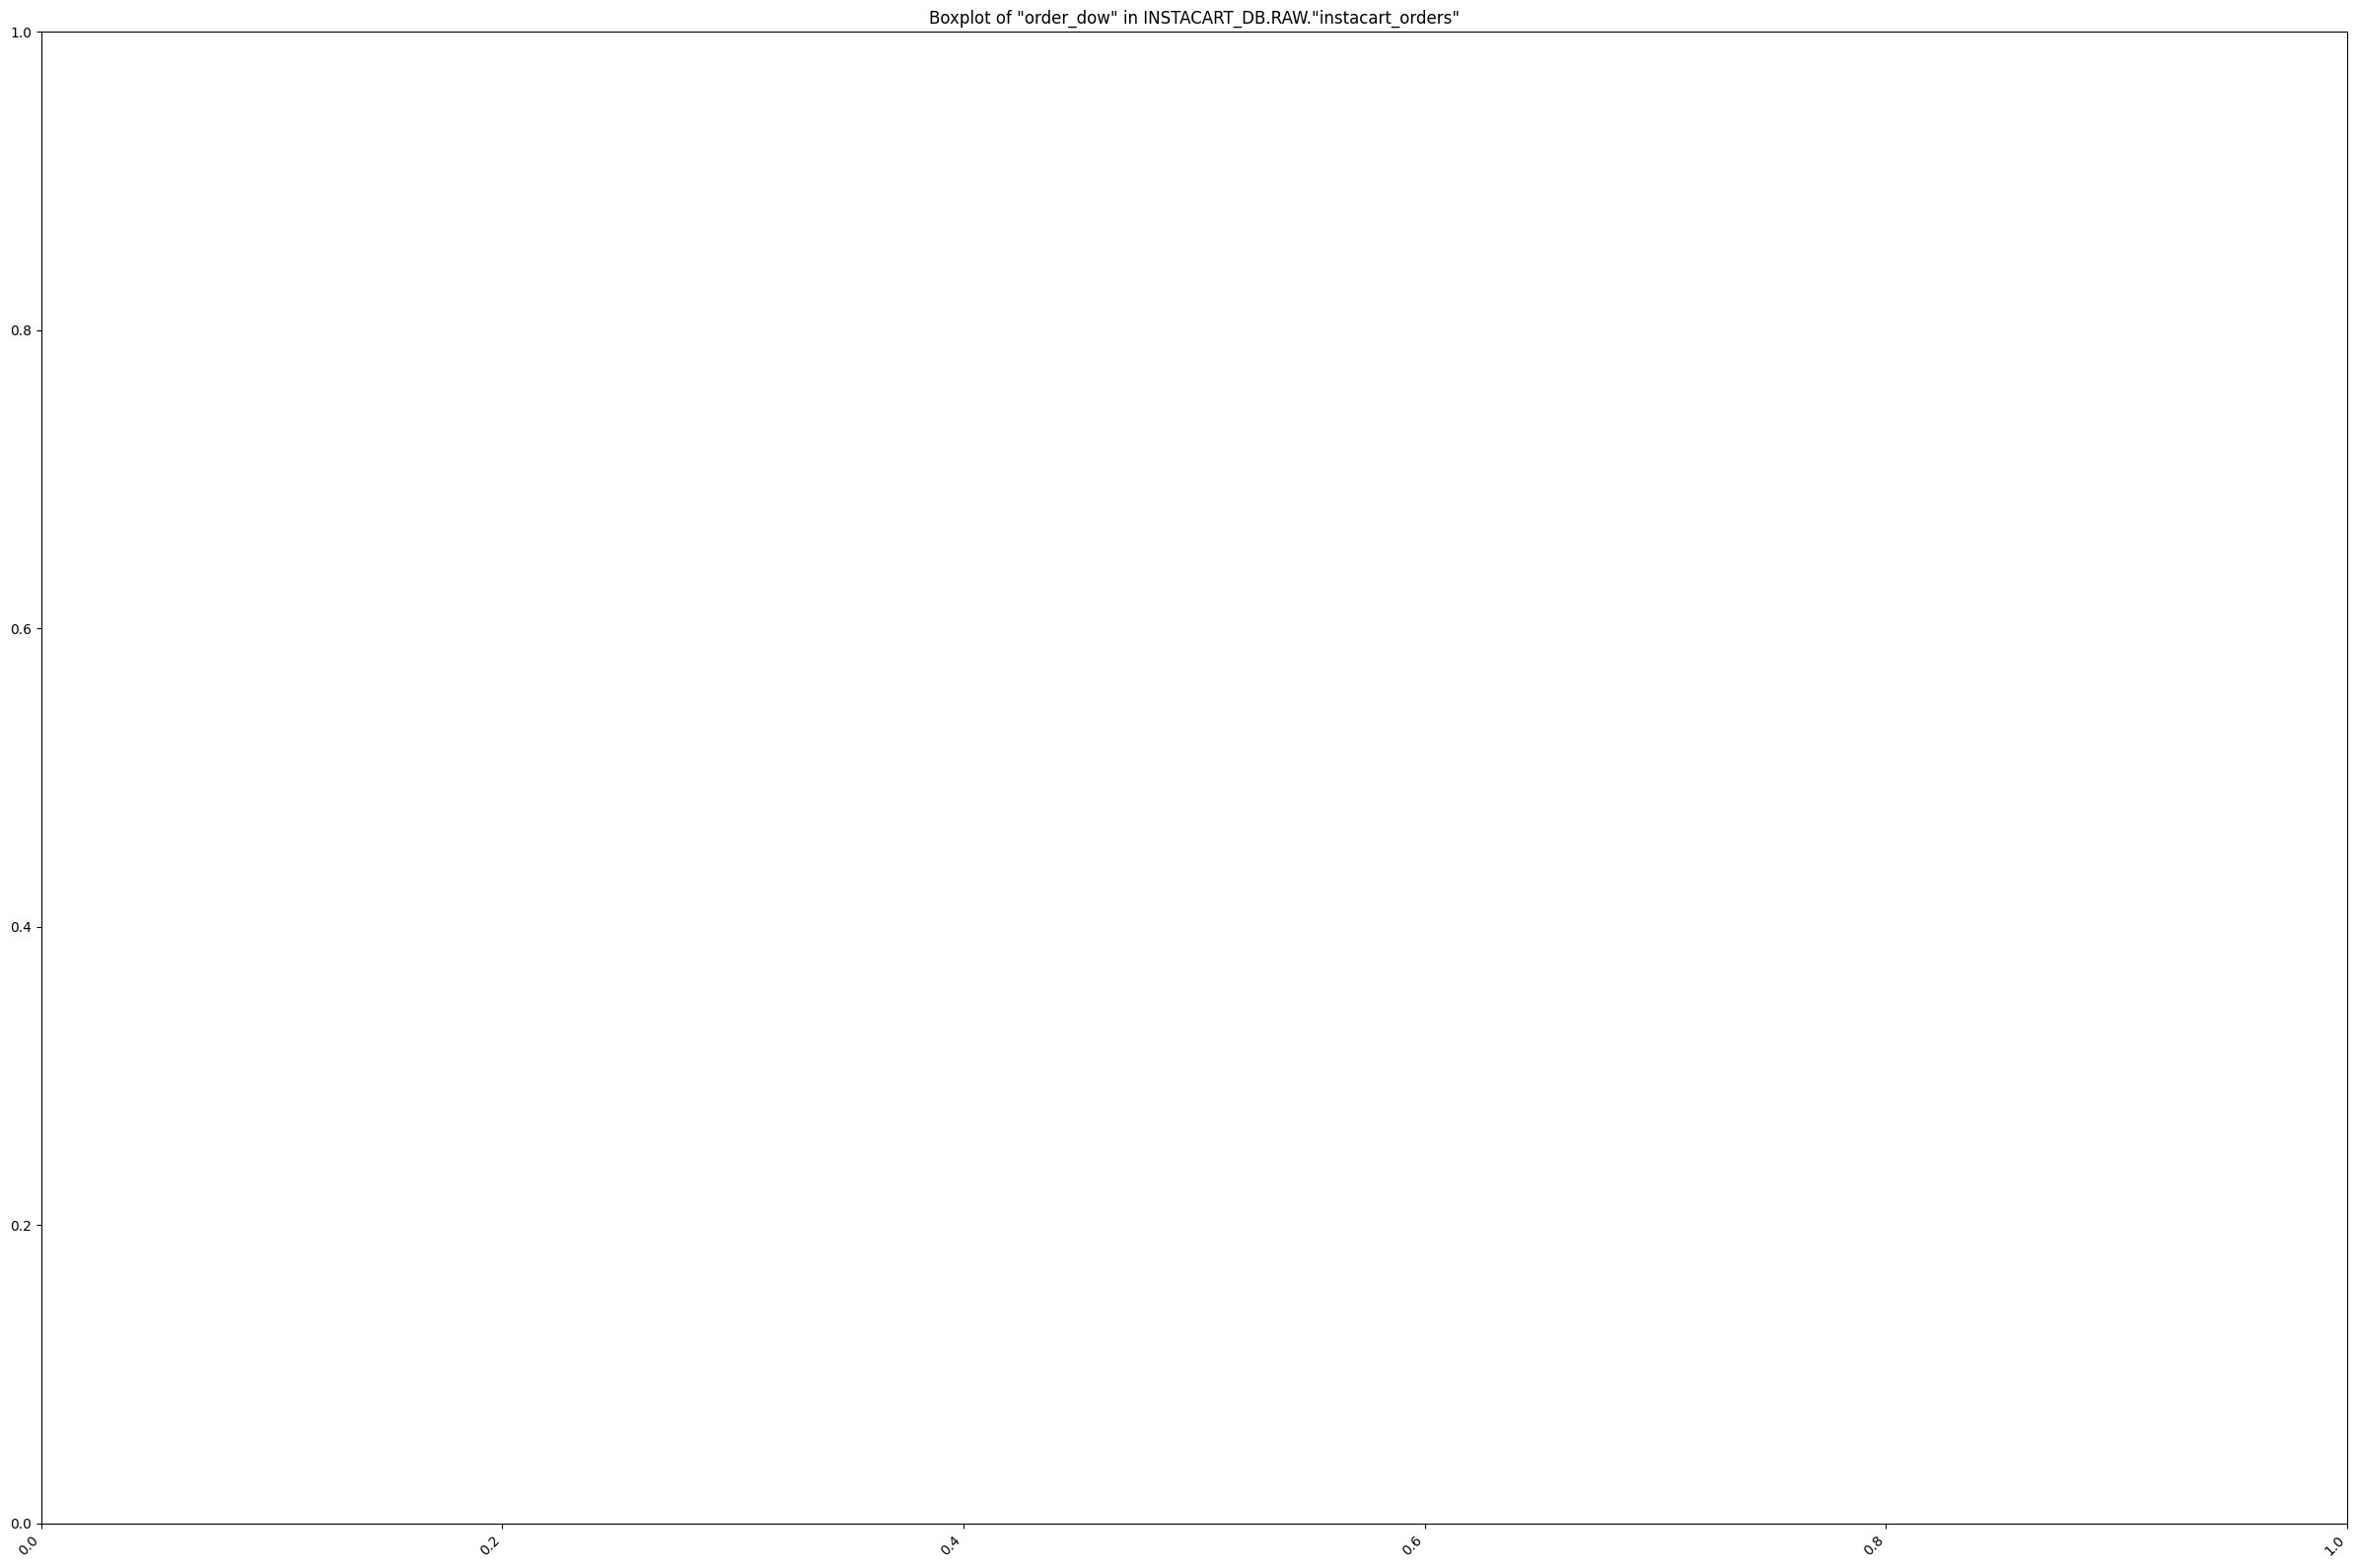

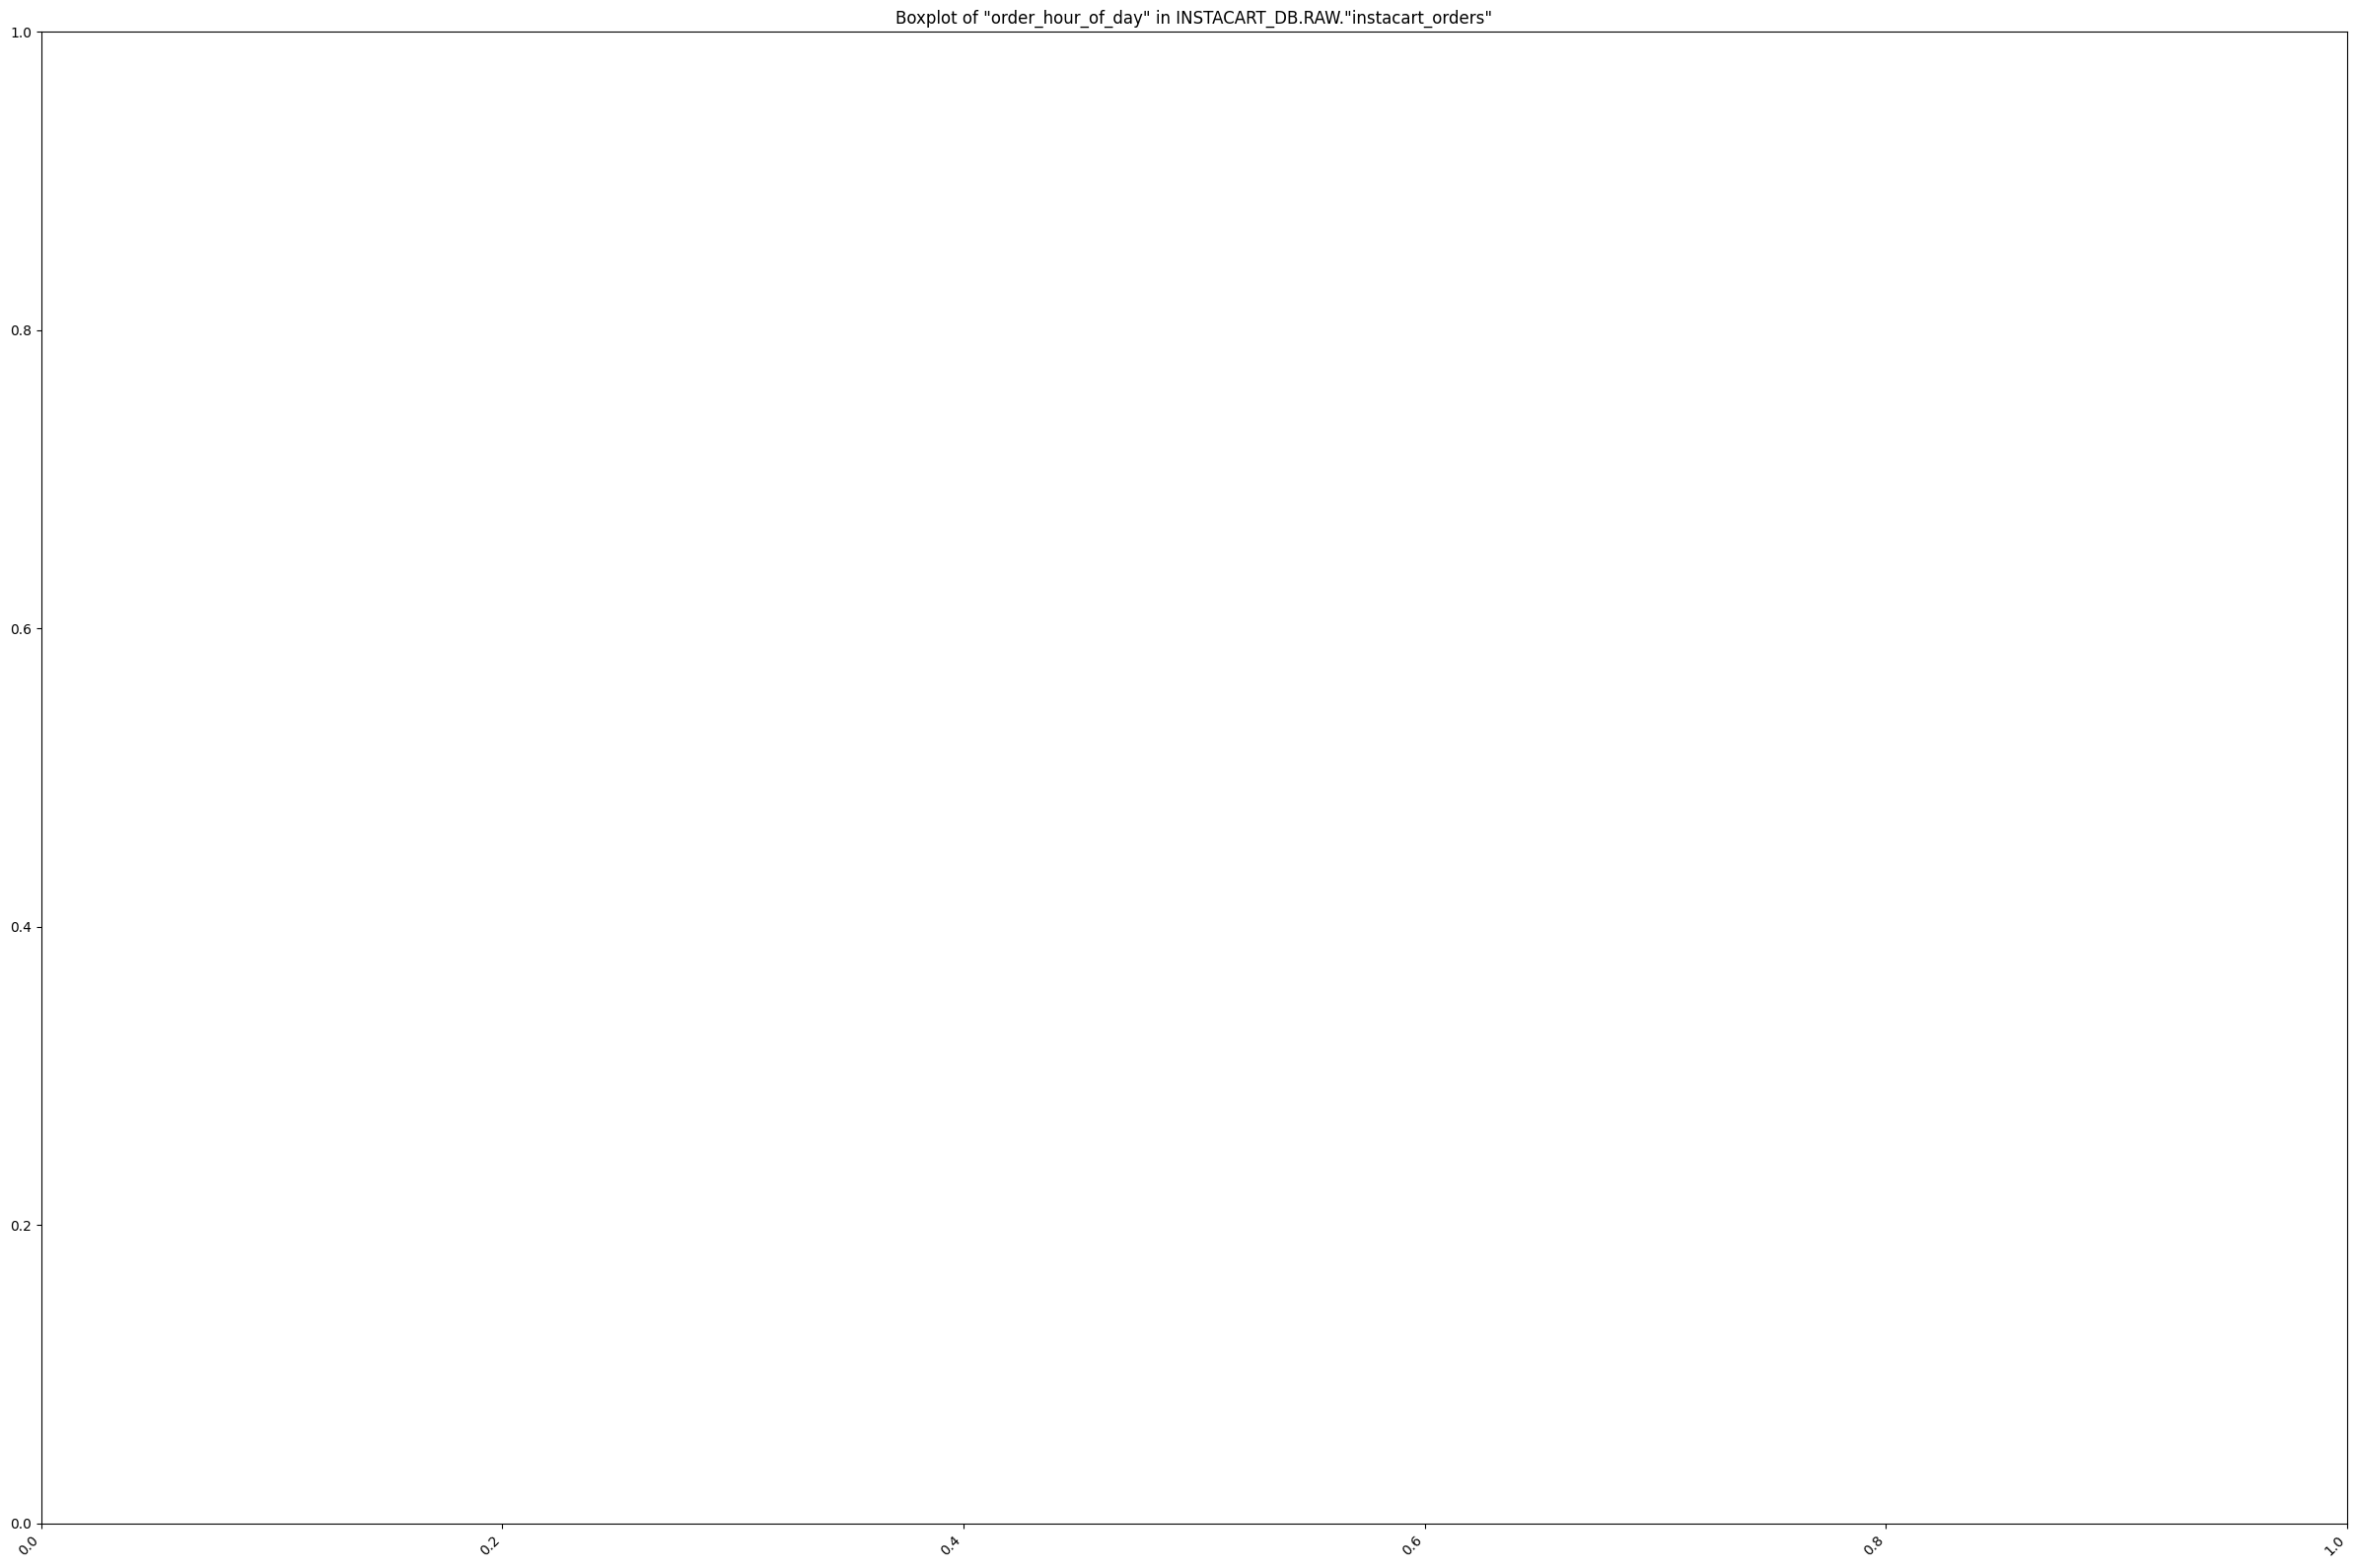

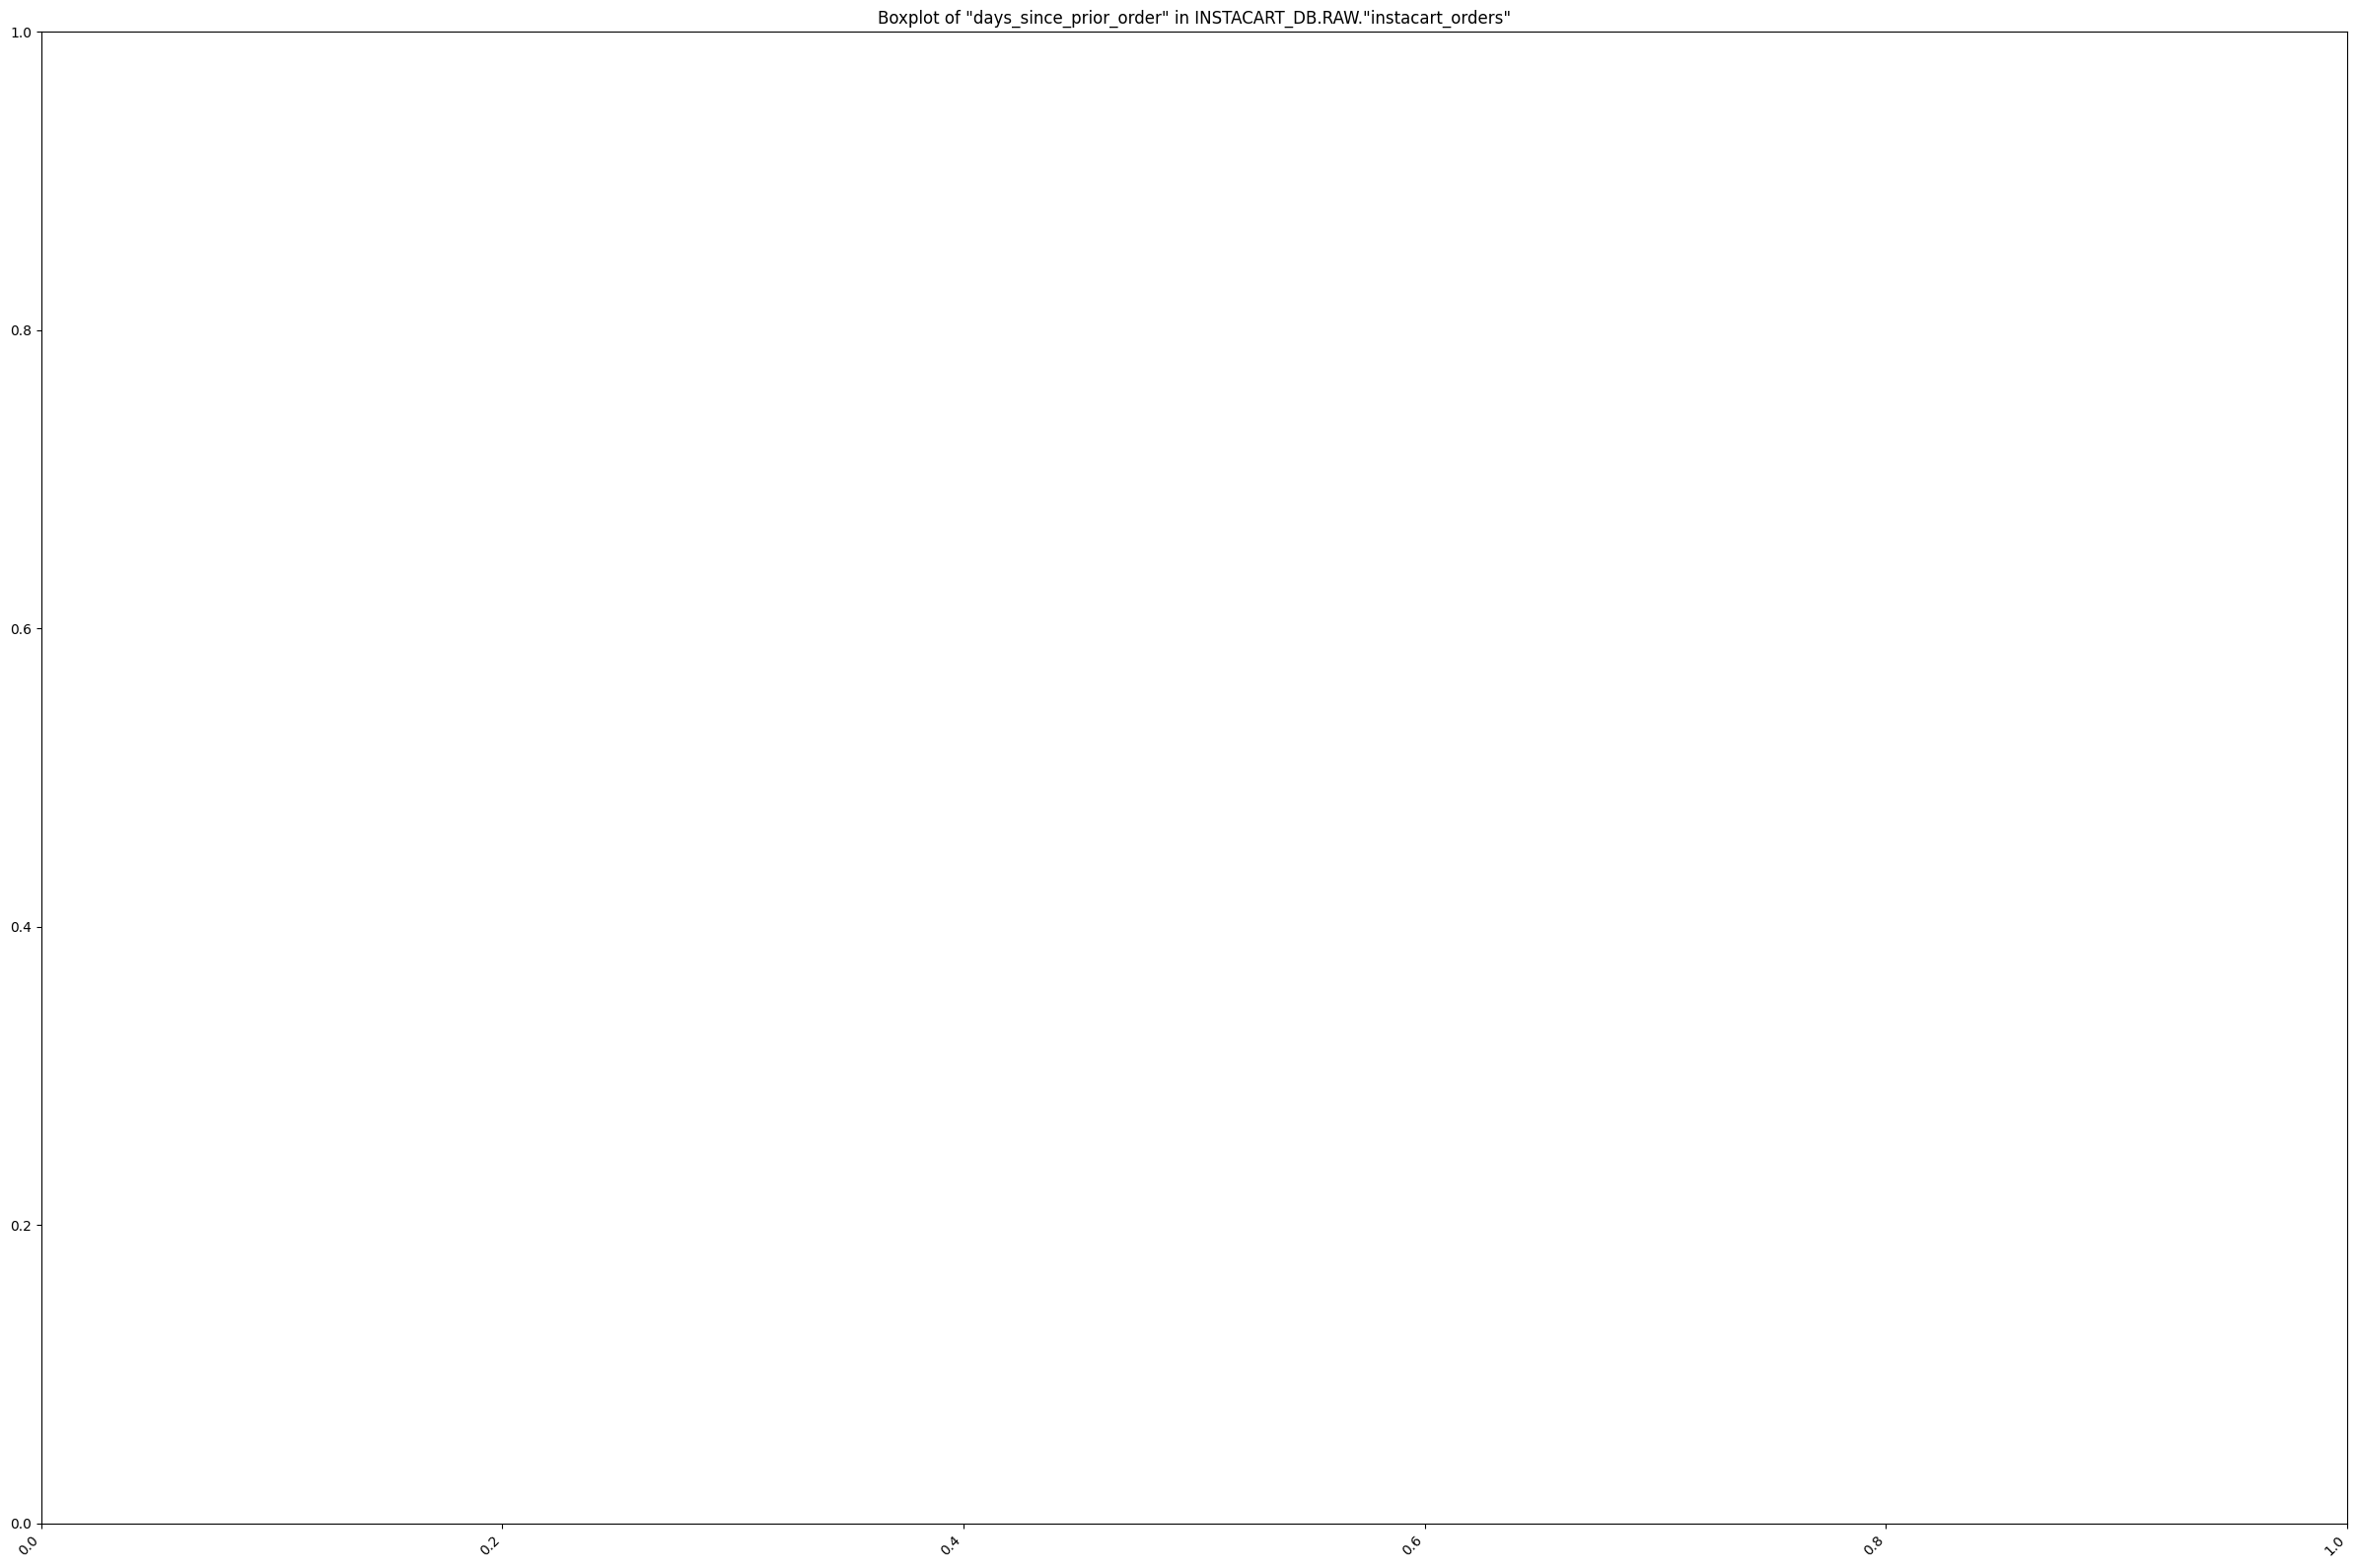

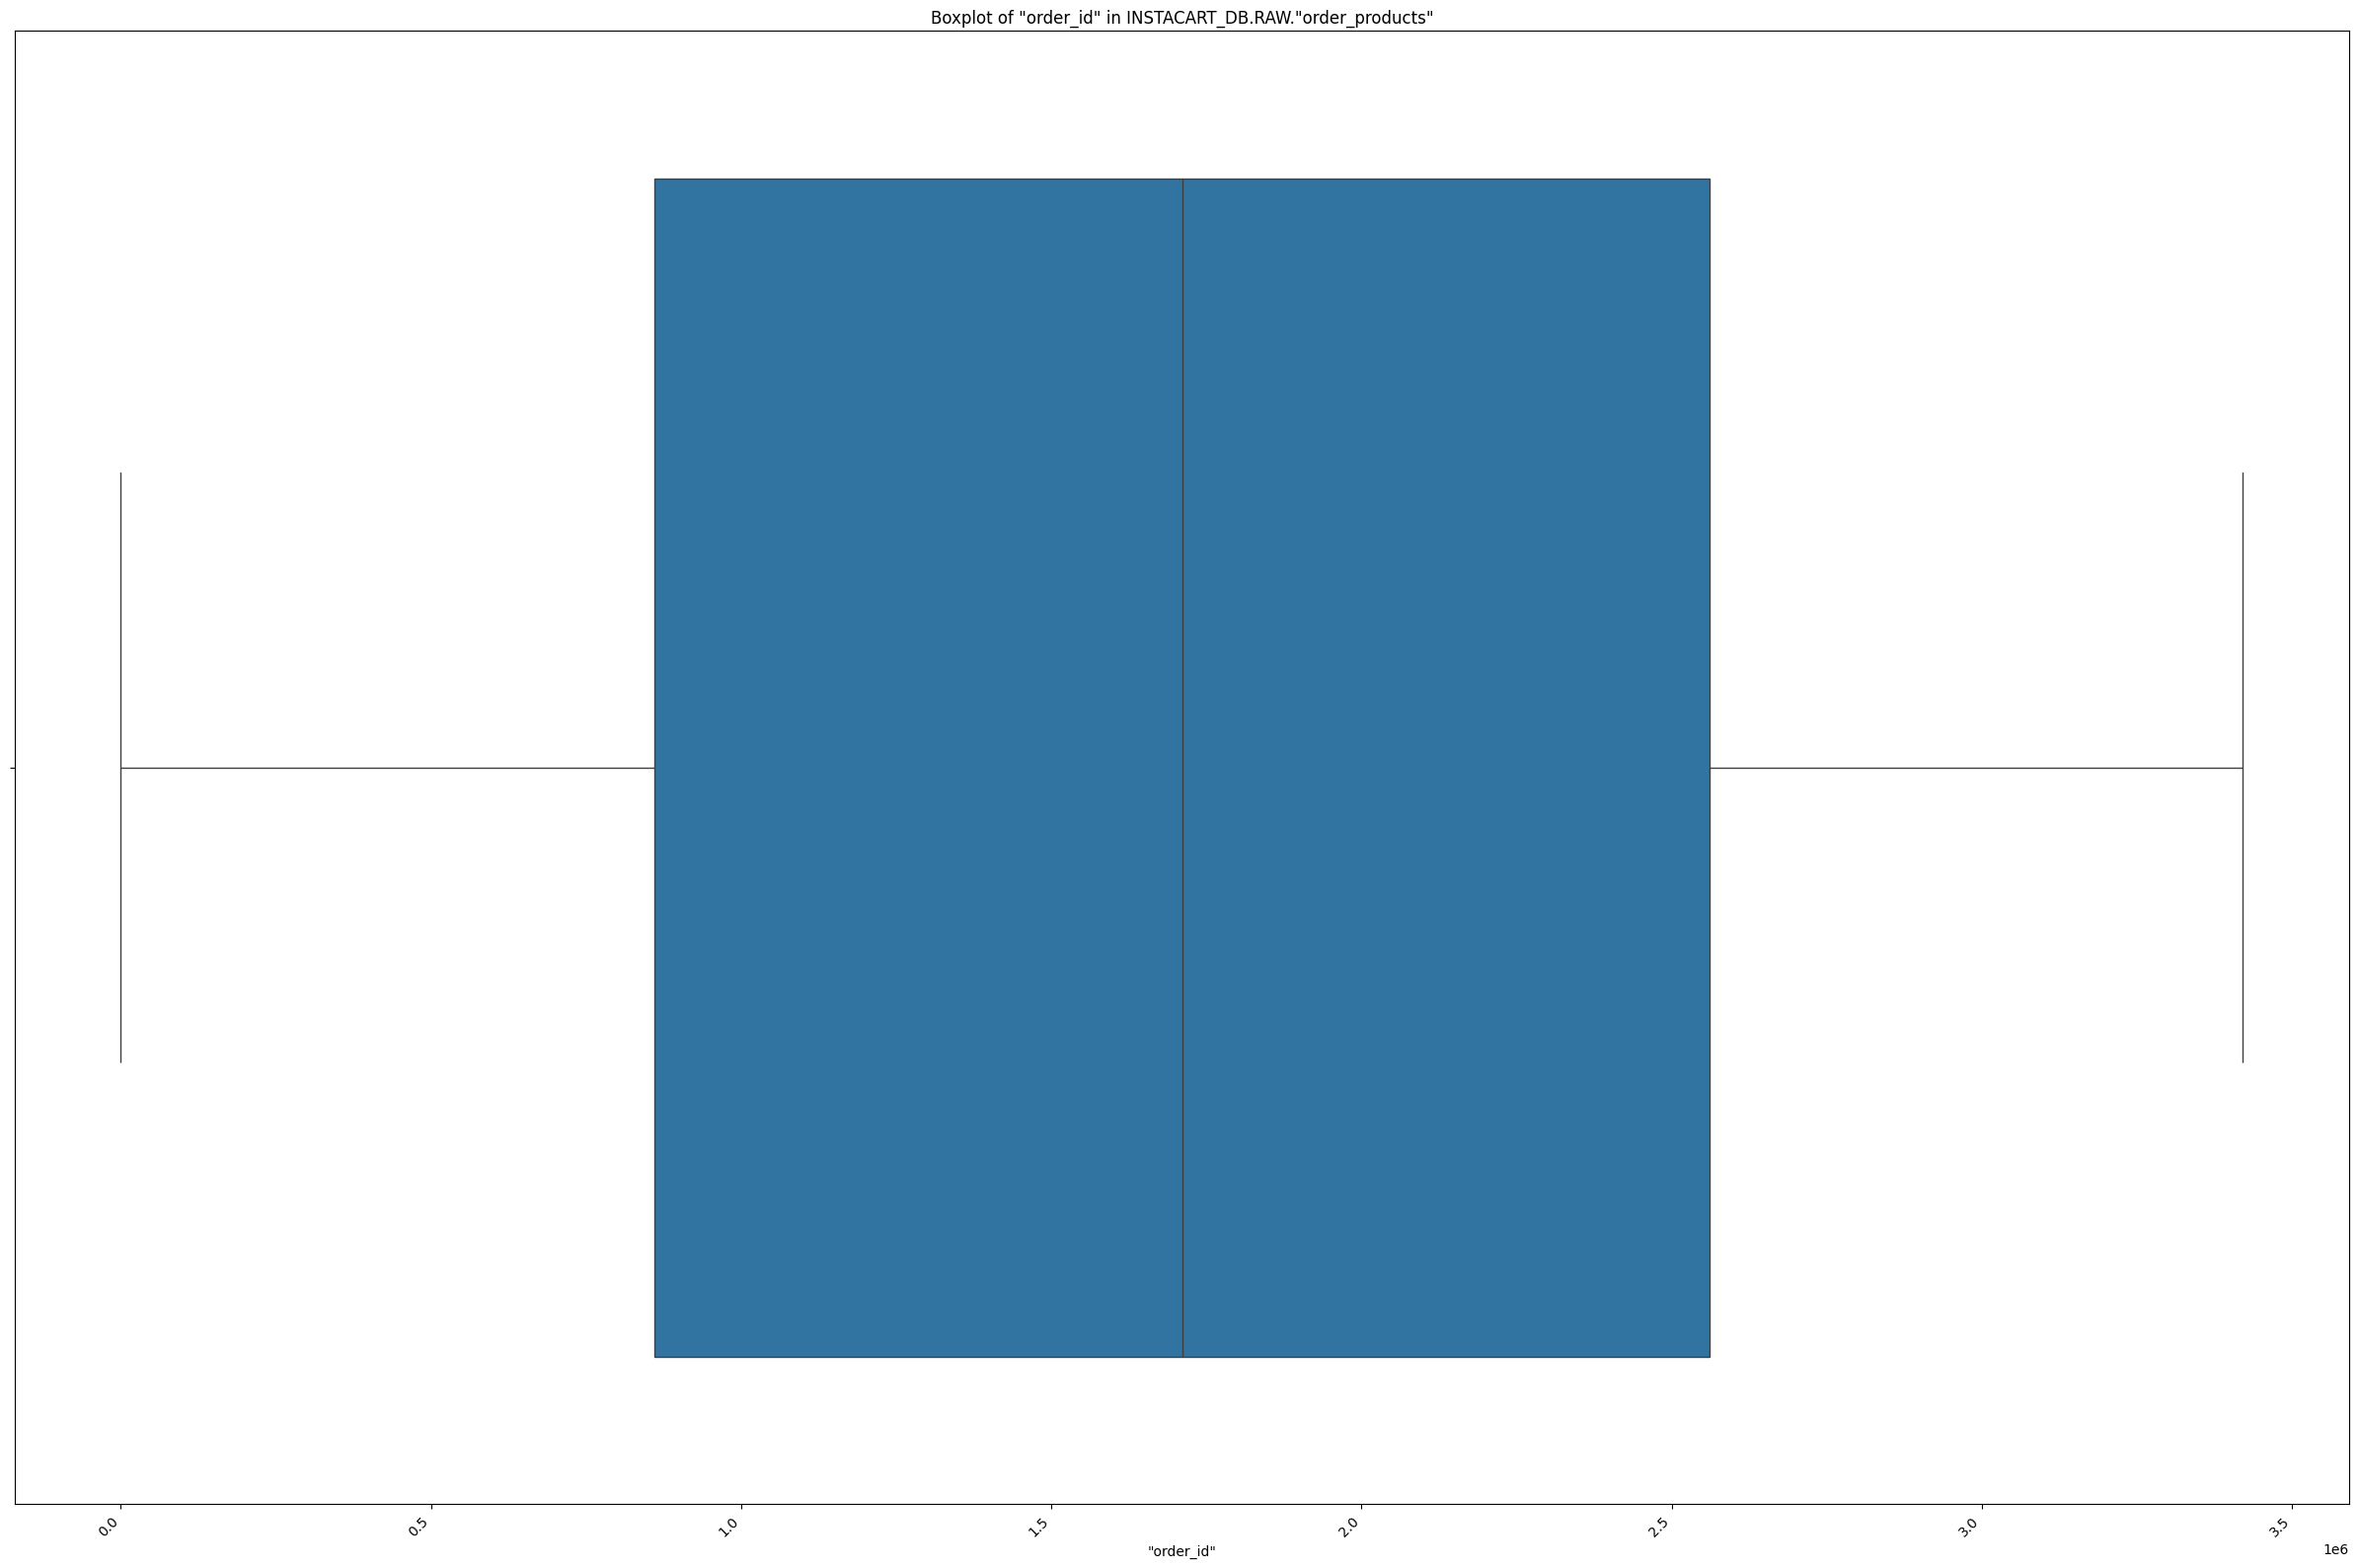

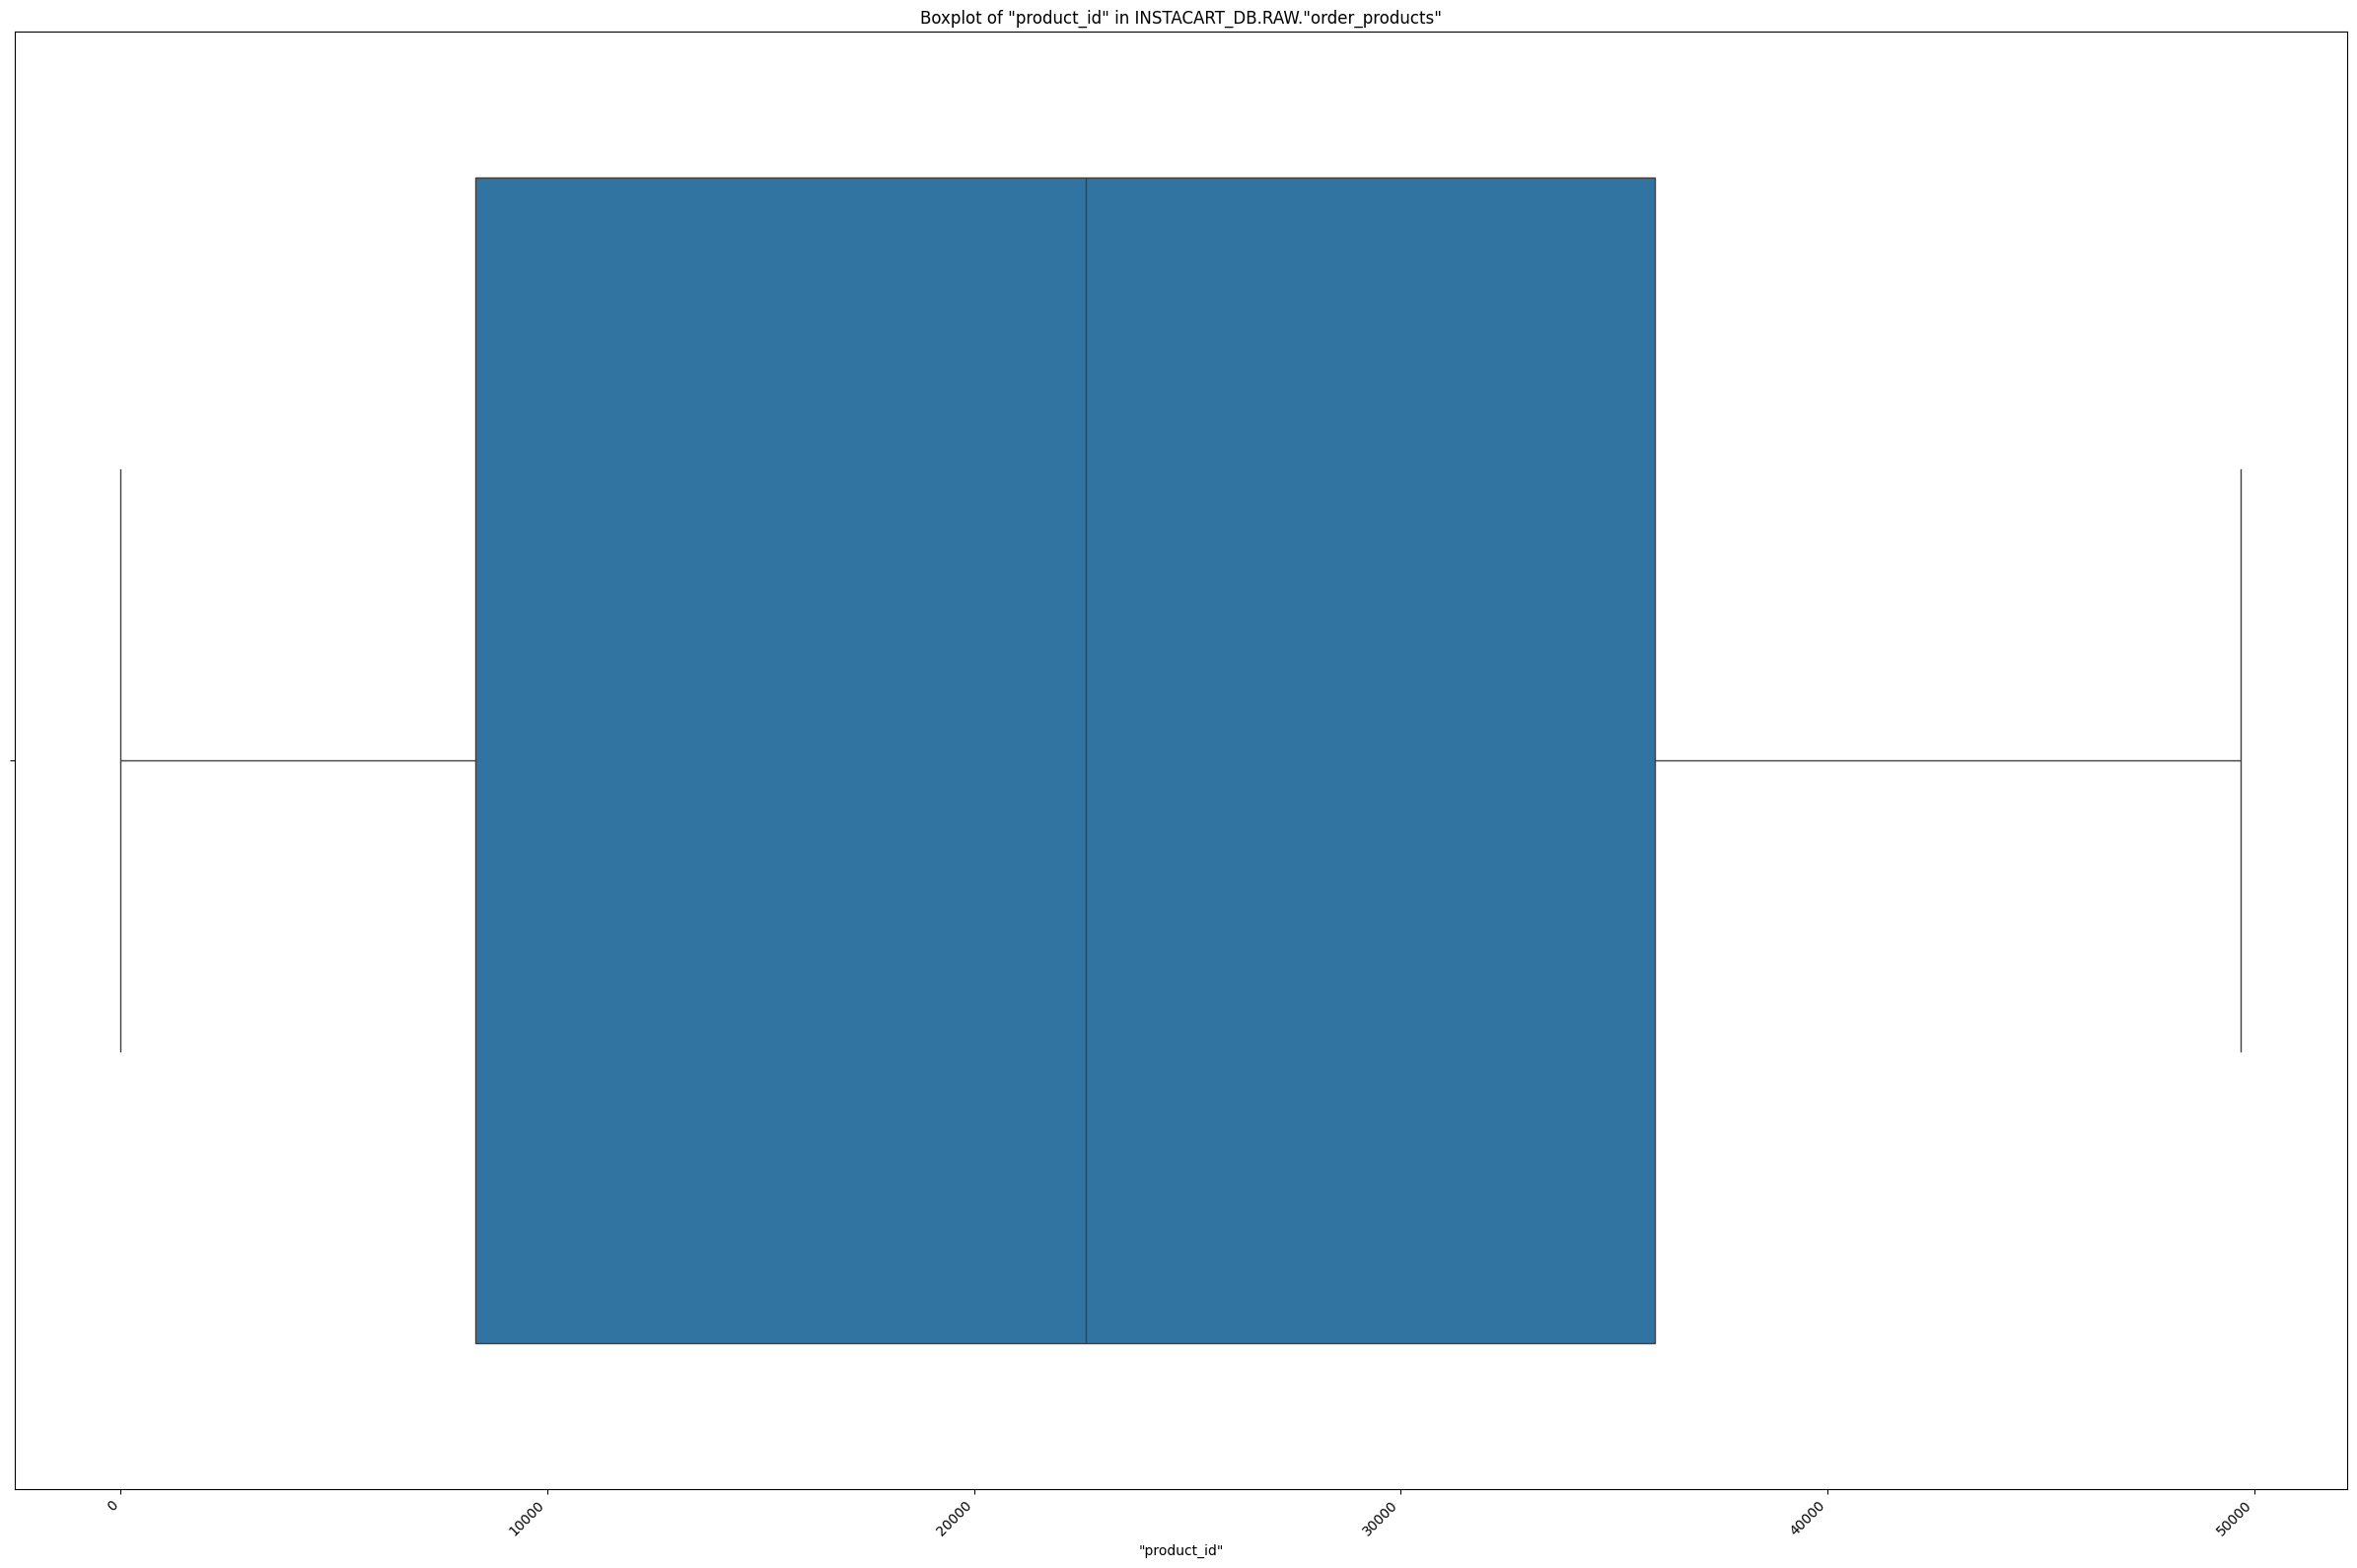

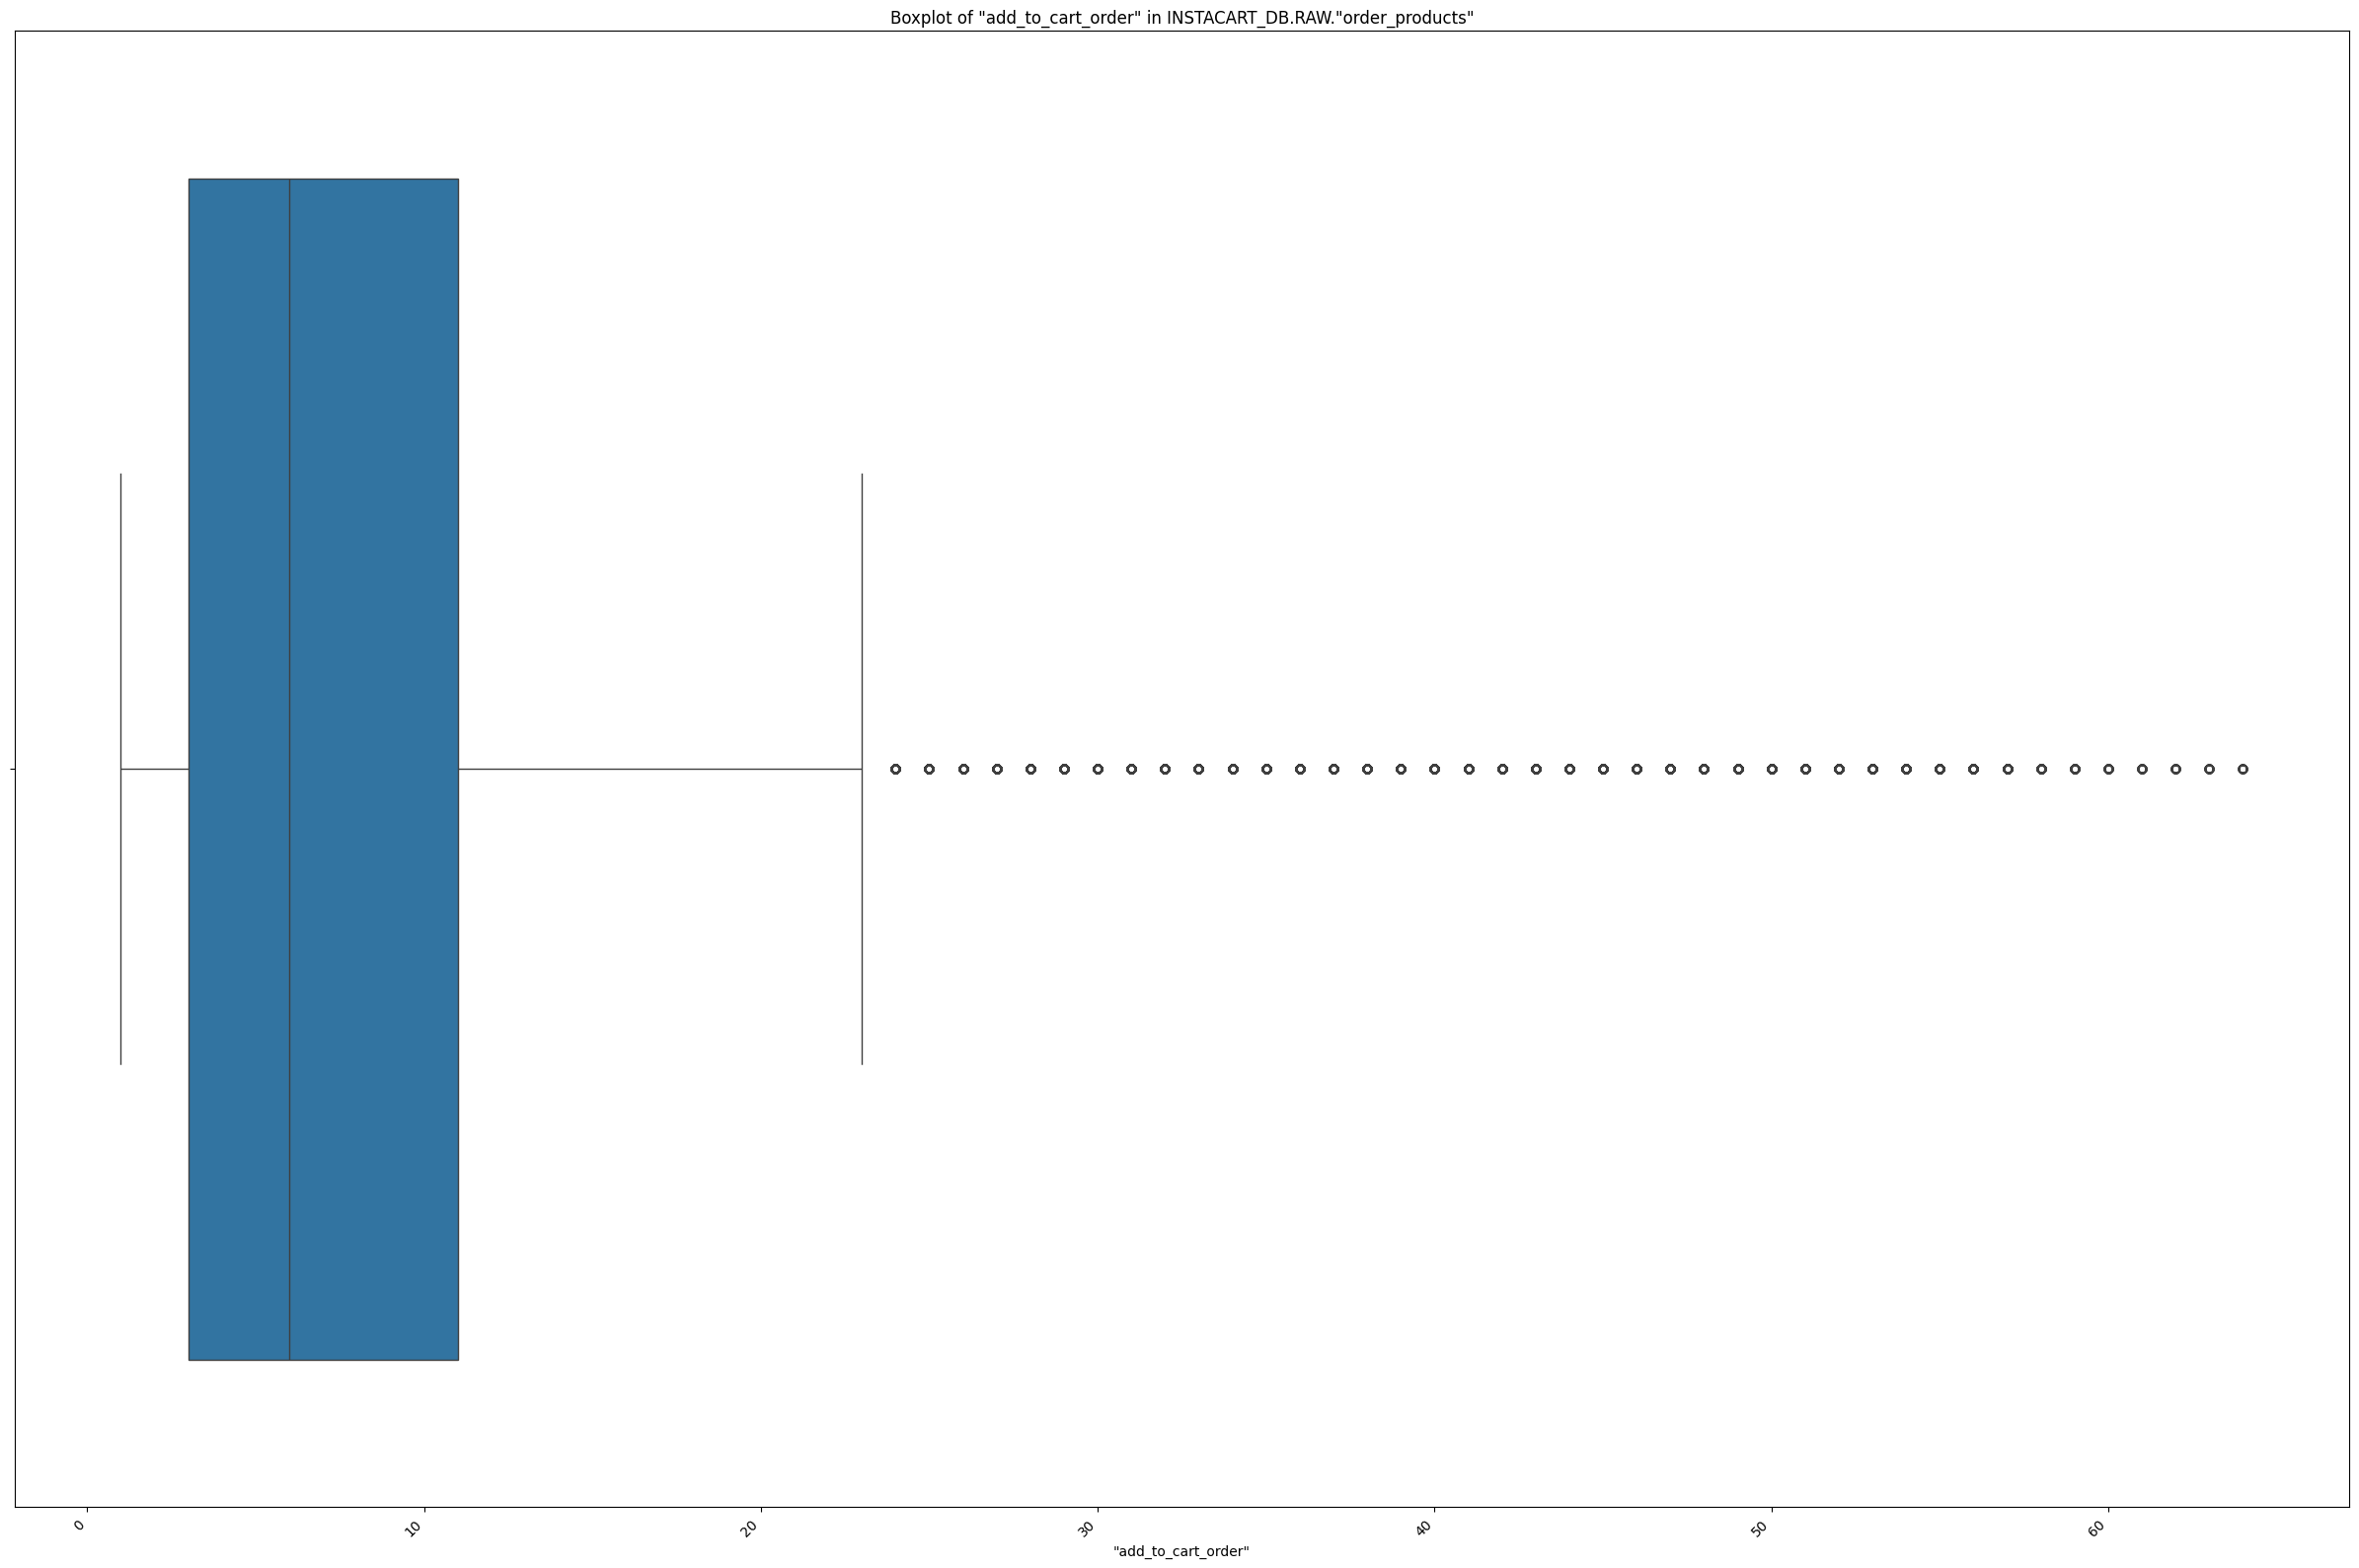

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define the tables and their columns
tables = [
    "INSTACART_DB.RAW.\"instacart_orders\"",
    "INSTACART_DB.RAW.\"departments\"",
    "INSTACART_DB.RAW.\"aisles\"",
    "INSTACART_DB.RAW.\"order_products\"",
    "INSTACART_DB.RAW.\"products\""
]

# Define the columns of interest for each table
table_columns = {
    "INSTACART_DB.RAW.\"aisles\"": ["\"aisle_id\"", "\"aisle\""],
    "INSTACART_DB.RAW.\"departments\"": ["\"department_id\"", "\"department\""],
    "INSTACART_DB.RAW.\"instacart_orders\"": ["\"order_id\"", "\"user_id\"", "\"order_number\"", "\"order_dow\"", "\"order_hour_of_day\"", "\"days_since_prior_order\""],
    "INSTACART_DB.RAW.\"order_products\"": ["\"order_id\"", "\"product_id\"", "\"add_to_cart_order\"", "\"reordered\""],
    "INSTACART_DB.RAW.\"products\"": ["\"product_id\"", "\"product_name\"", "\"aisle_id\"", "\"department_id\""]
}

# Loop through each table and its columns
for table, cols in table_columns.items():
    for col in cols:
        query = f"SELECT {col} FROM {table} WHERE {col} IS NOT NULL"
        cur.execute(query)
        df = pd.DataFrame(cur.fetchall(), columns=[col])
        
        plt.figure(figsize=(24, 16))  # Increase figure size to fit more space for labels
        sns.boxplot(x=df[col])
        plt.title(f"Boxplot of {col} in {table}")
        
        # Rotate x-axis labels if necessary
        plt.xticks(rotation=45, ha='right', fontsize=10)  # Adjust rotation and font size
        
        # Adjust the space at the bottom to avoid overlap
        plt.subplots_adjust(bottom=0.25)
        
        # Optional: Apply line breaks to long labels if necessary
        labels = plt.gca().get_xticklabels()
        max_label_length = 100  # Maximum label length before wrapping (can be adjusted)
        for i, label in enumerate(labels):
            if len(label.get_text()) > max_label_length:
                new_text = '\n'.join([label.get_text()[i:i+max_label_length] for i in range(0, len(label.get_text()), max_label_length)])
                label.set_text(new_text)

        # Adjust layout to make sure everything fits
        plt.tight_layout()
        
        plt.show()


In [ ]:
H) Visualizing Distributions (Histograms for Numerical Columns)

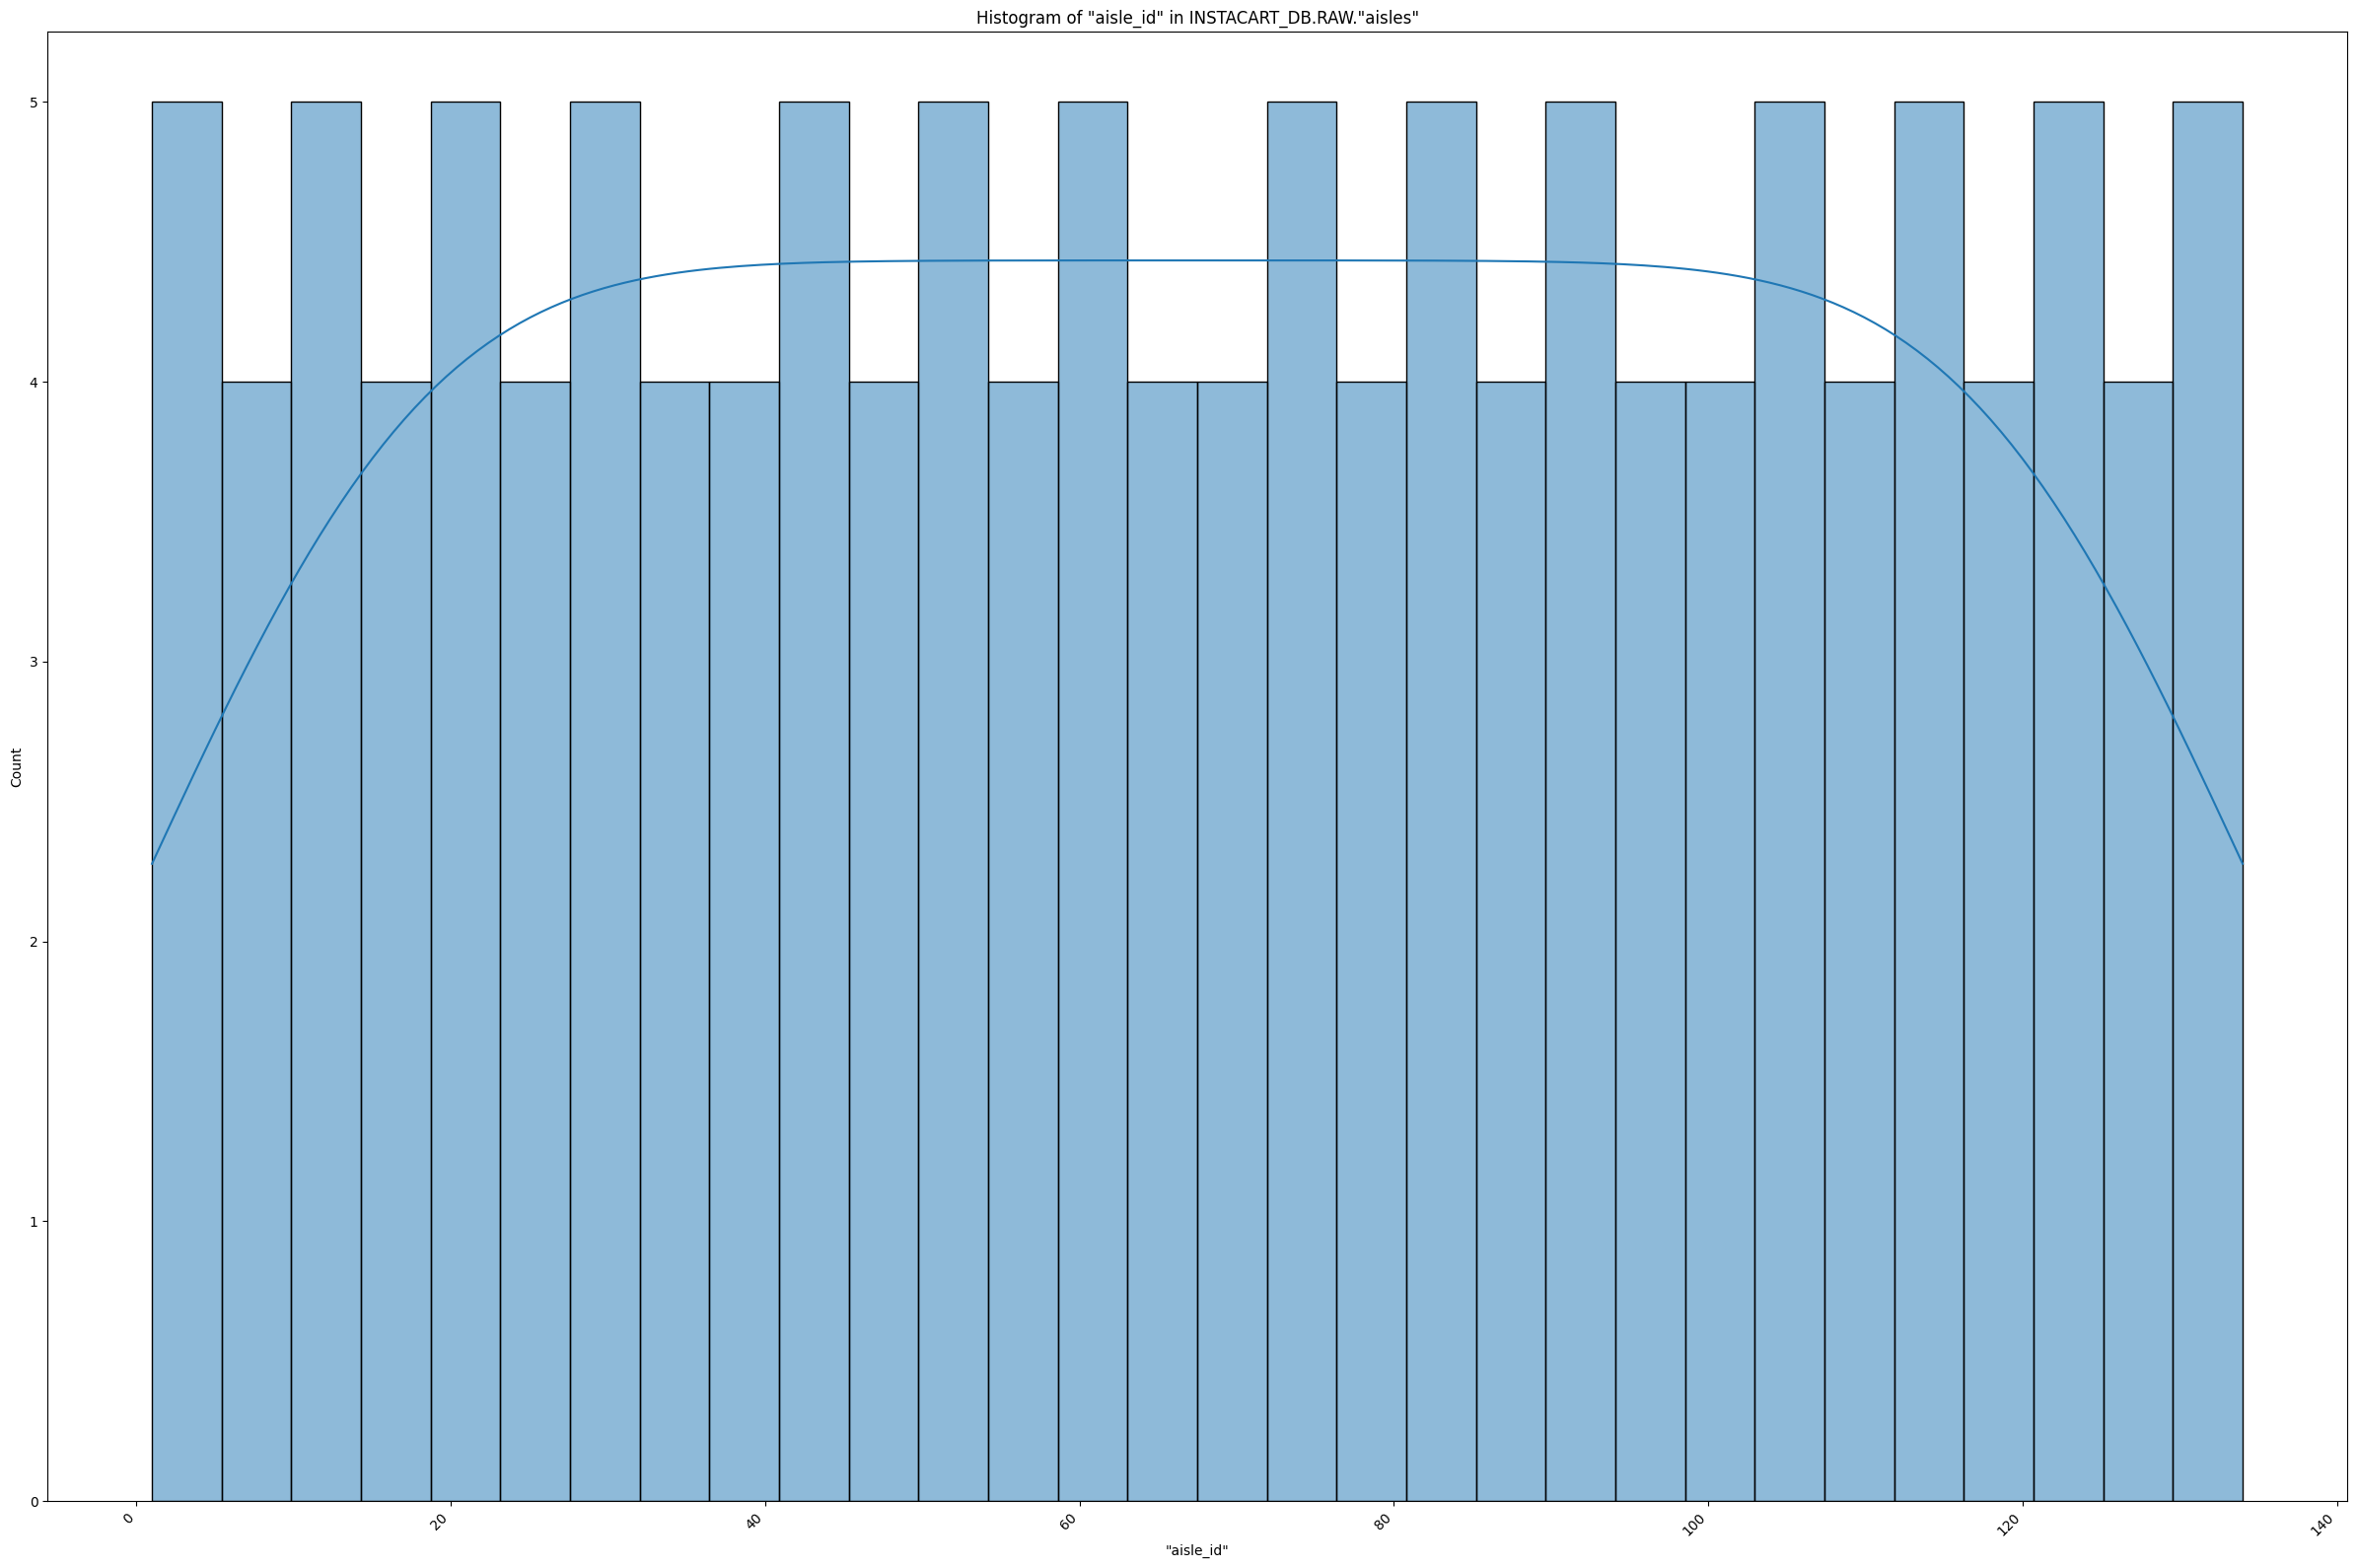

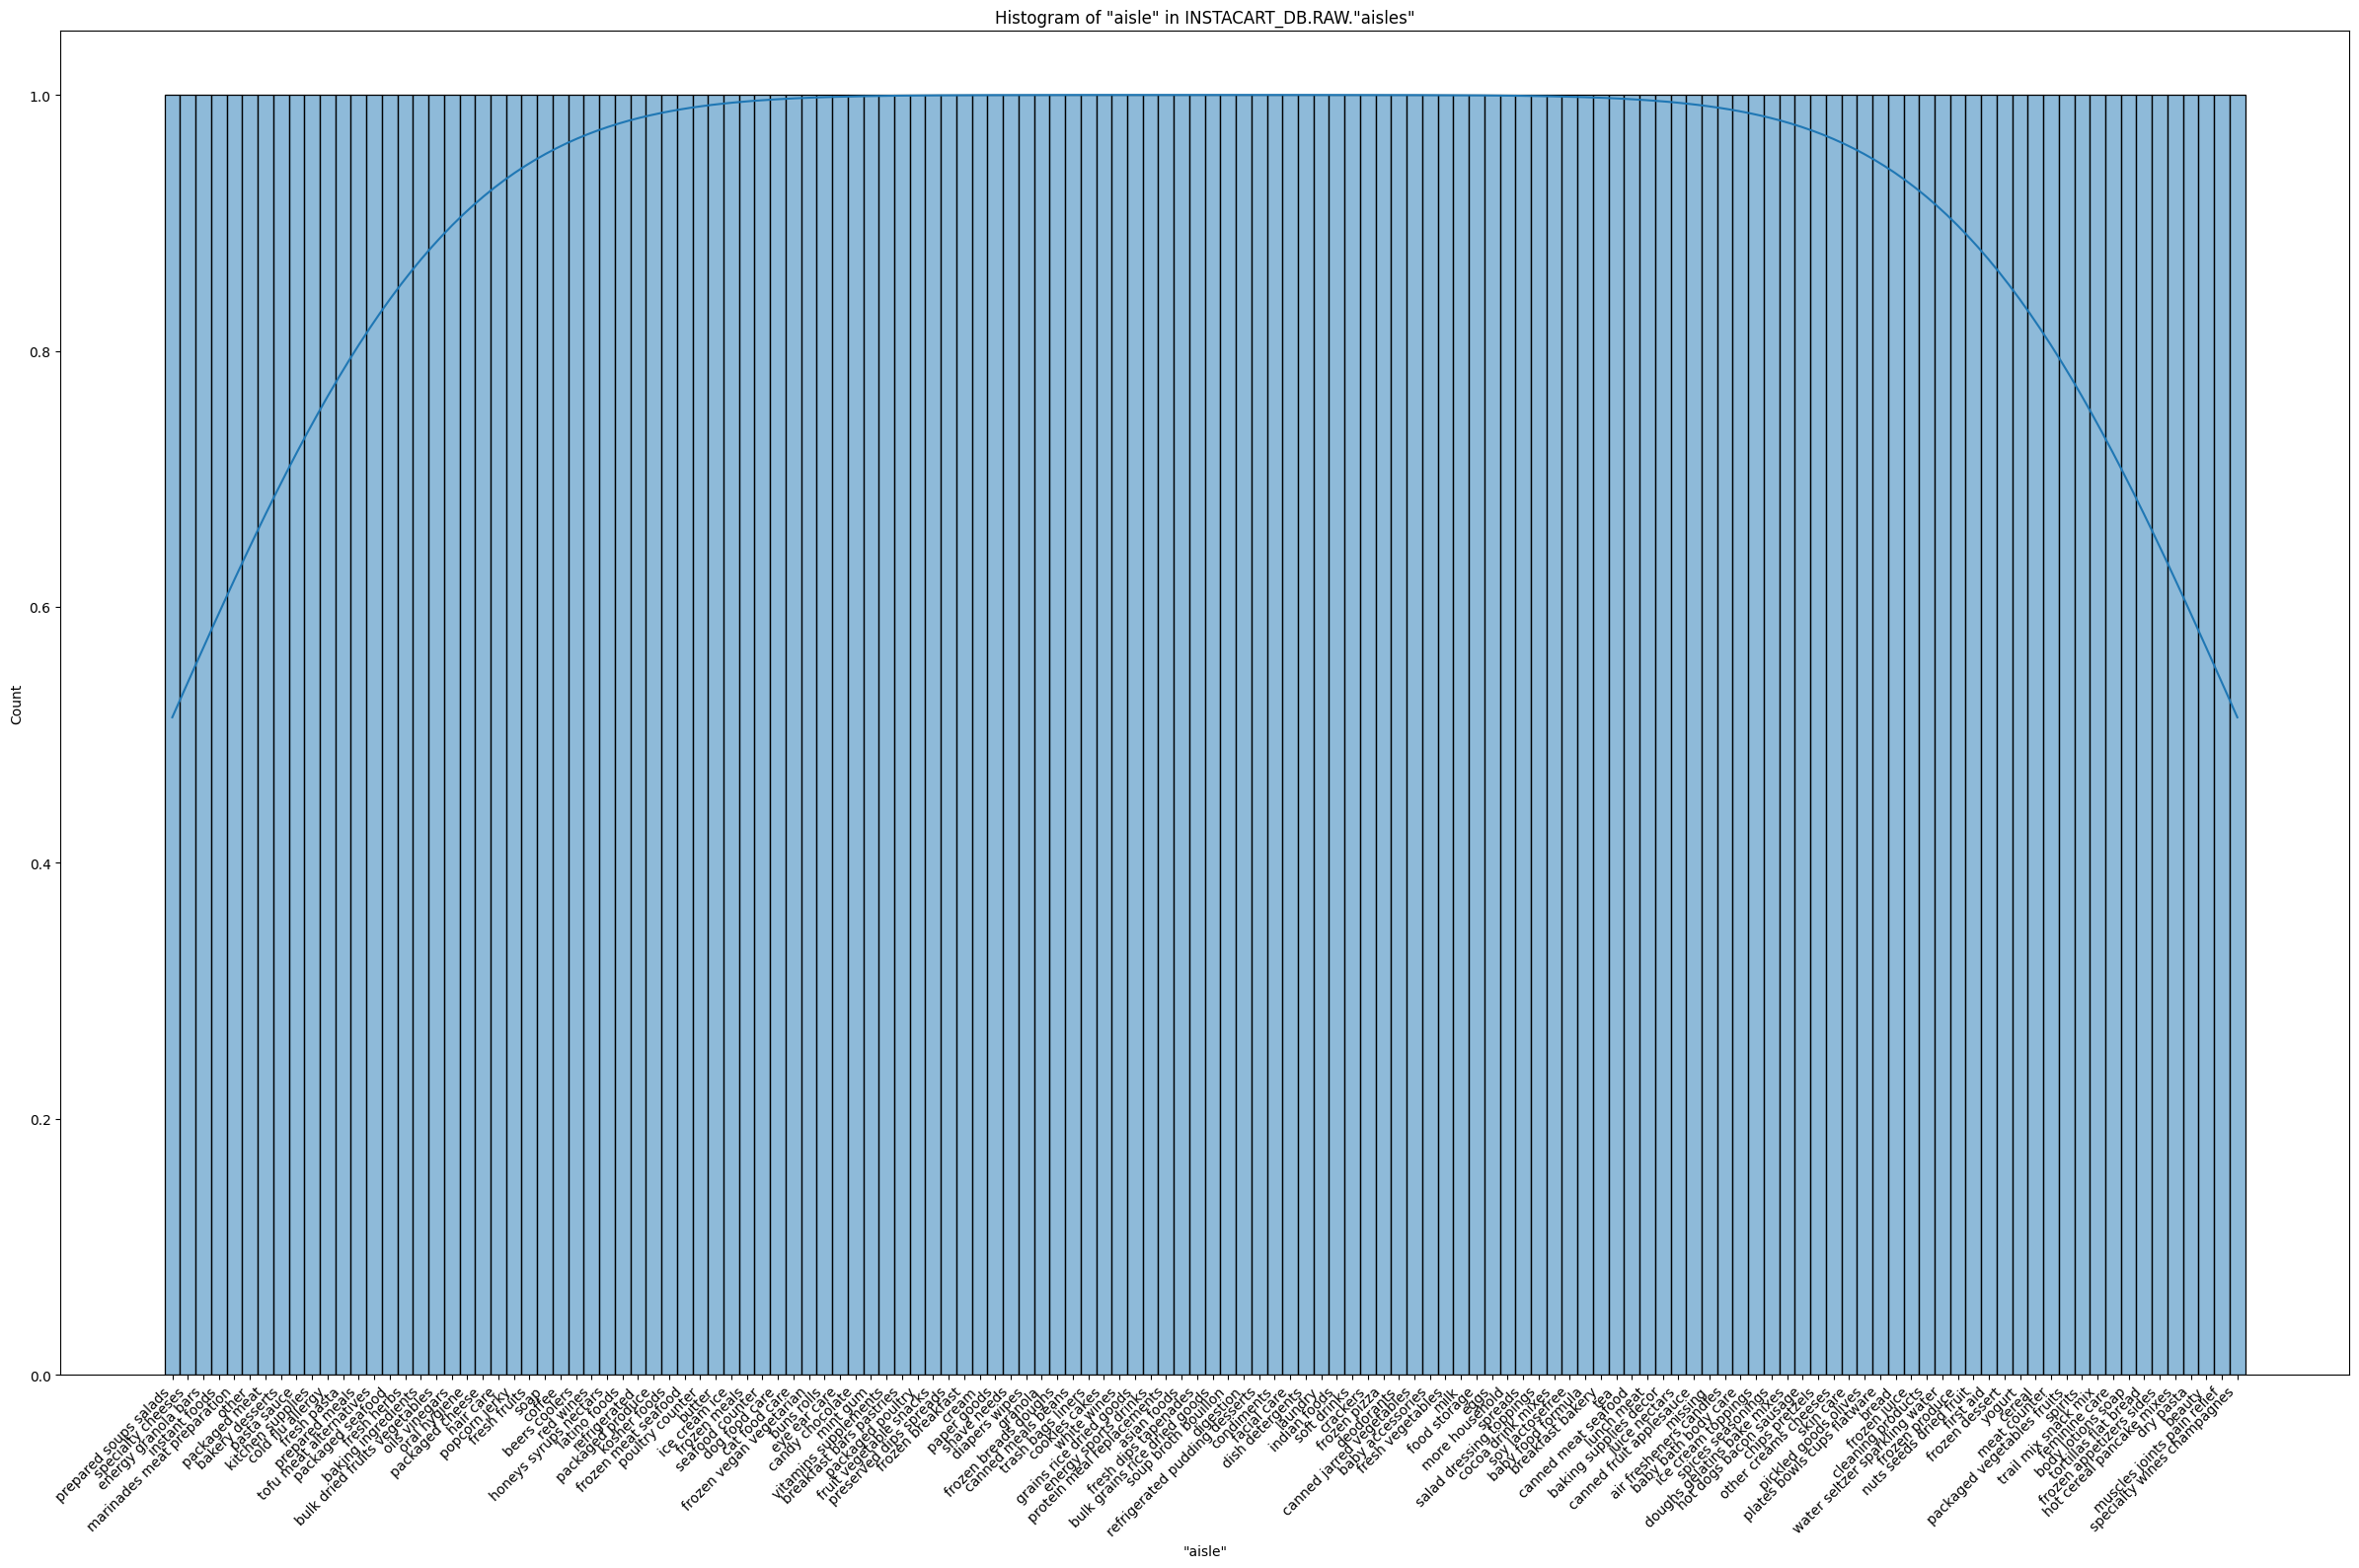

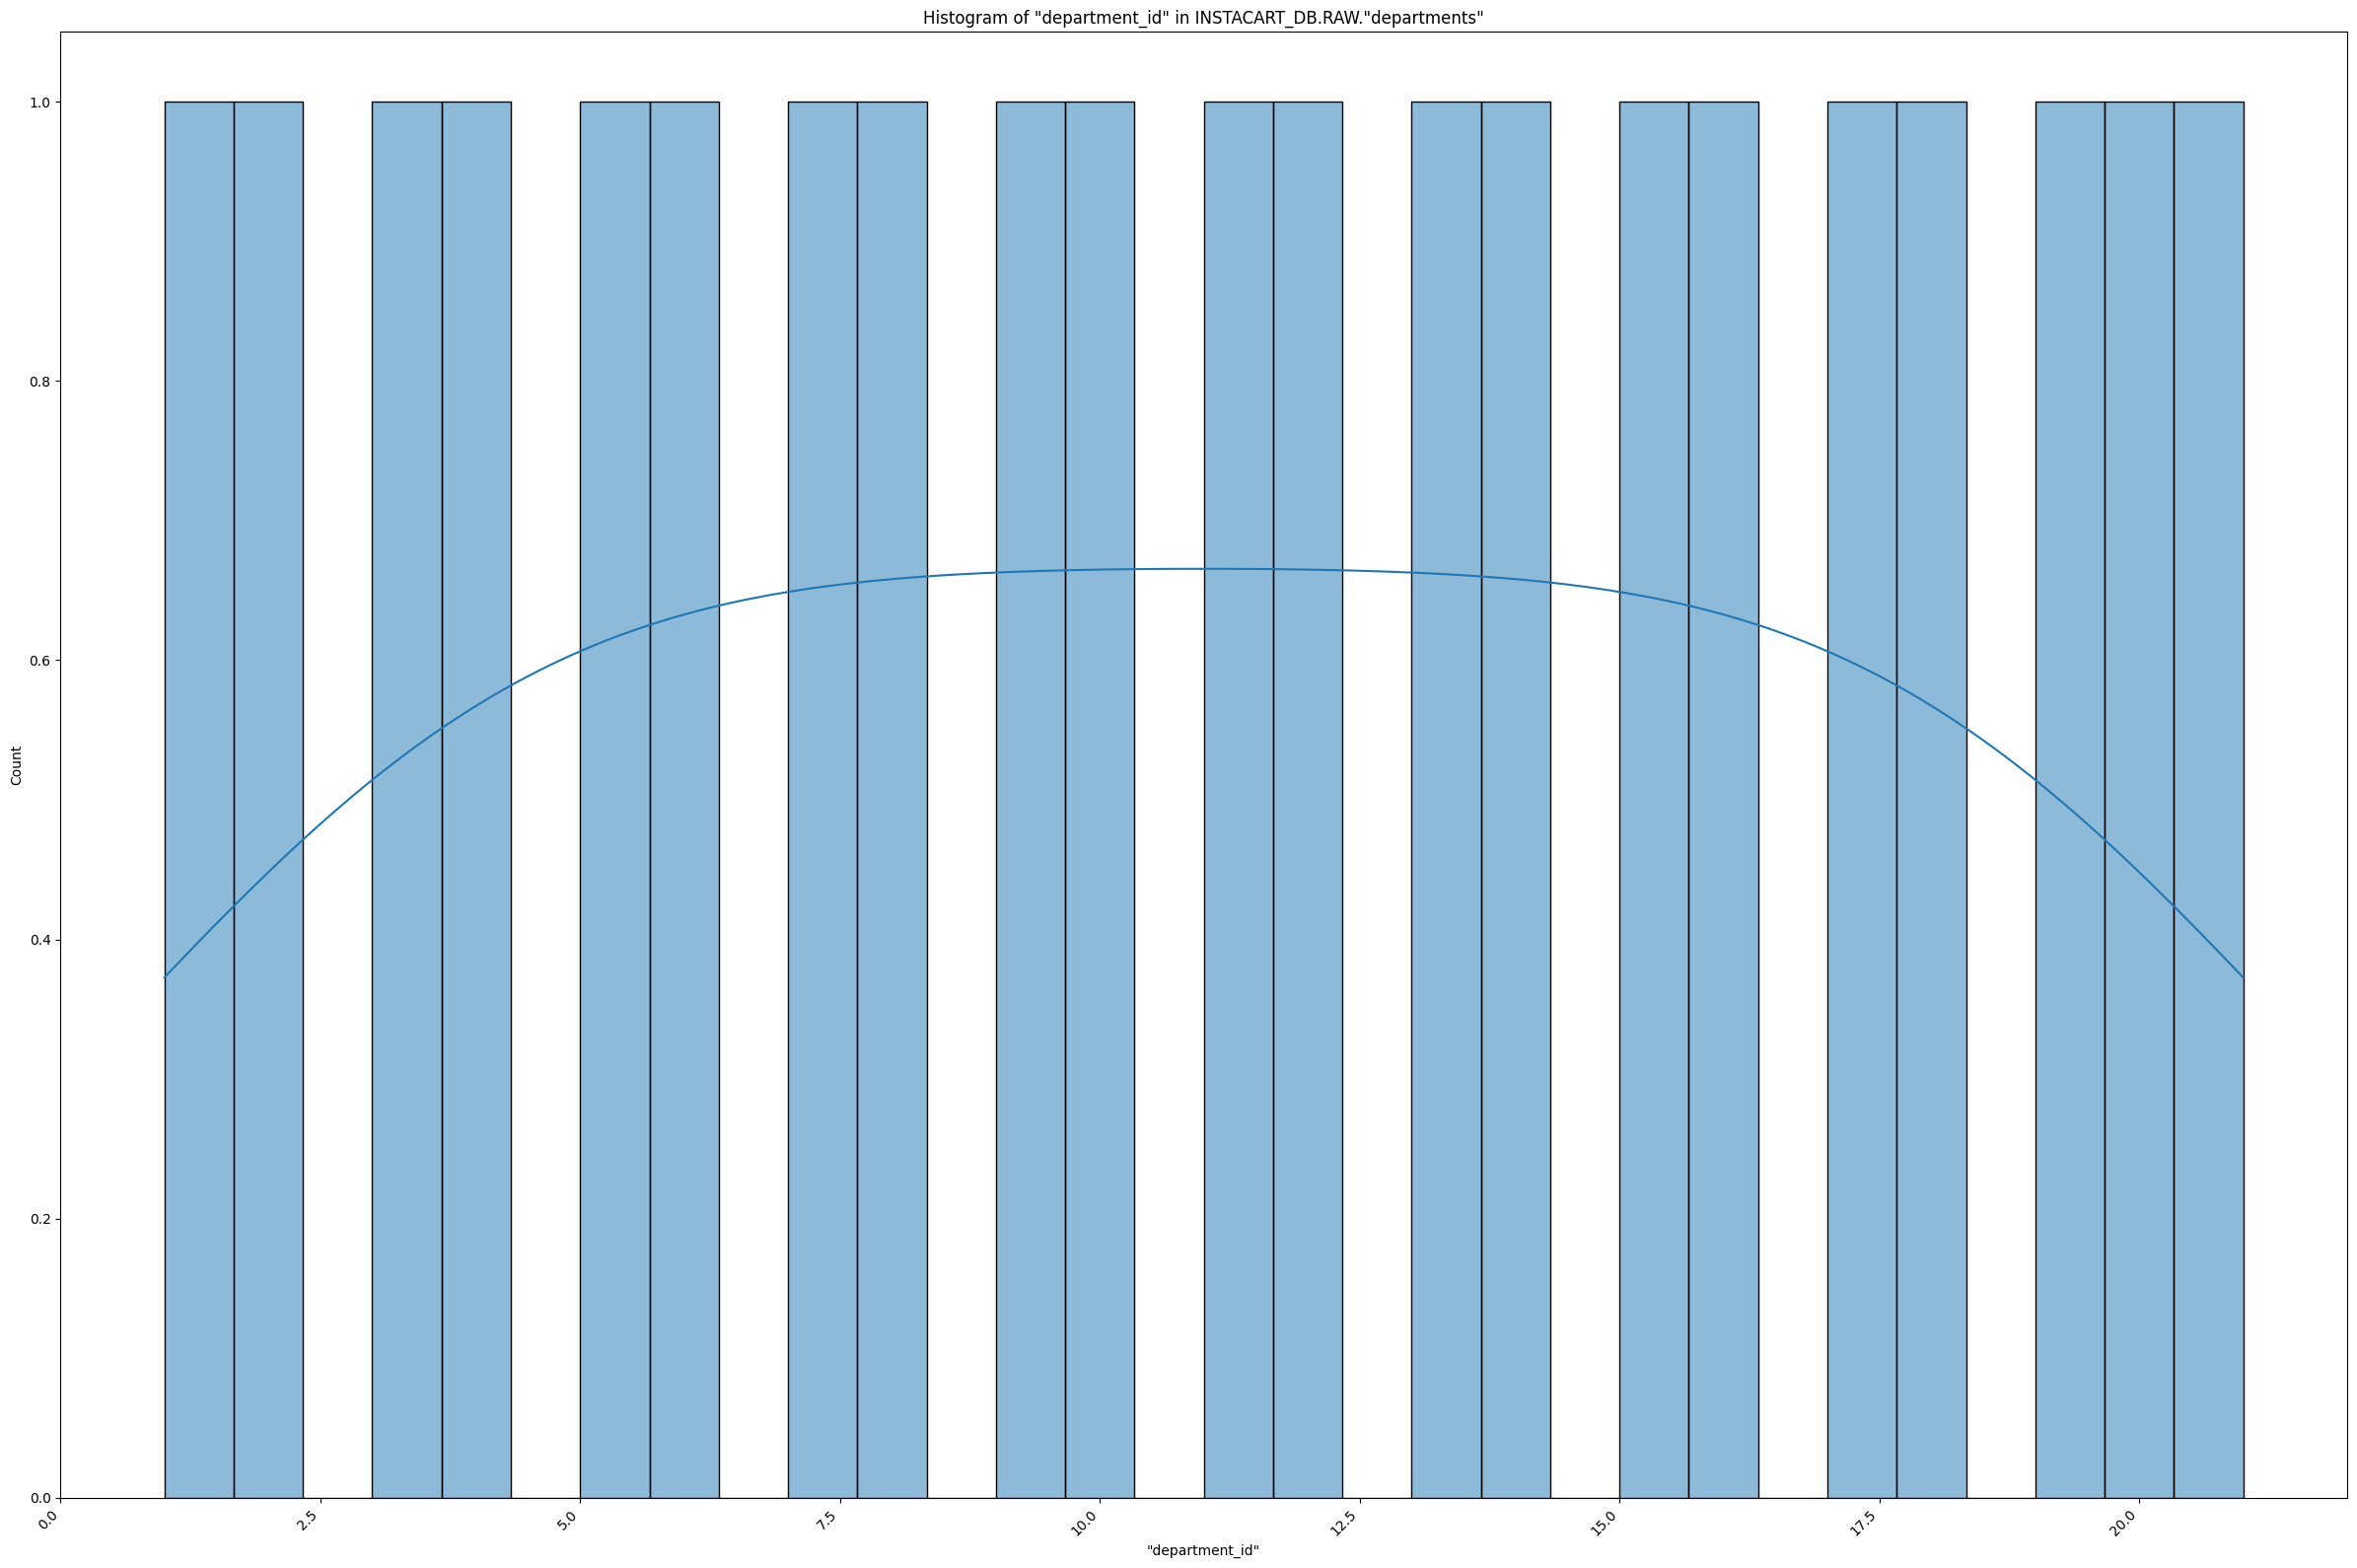

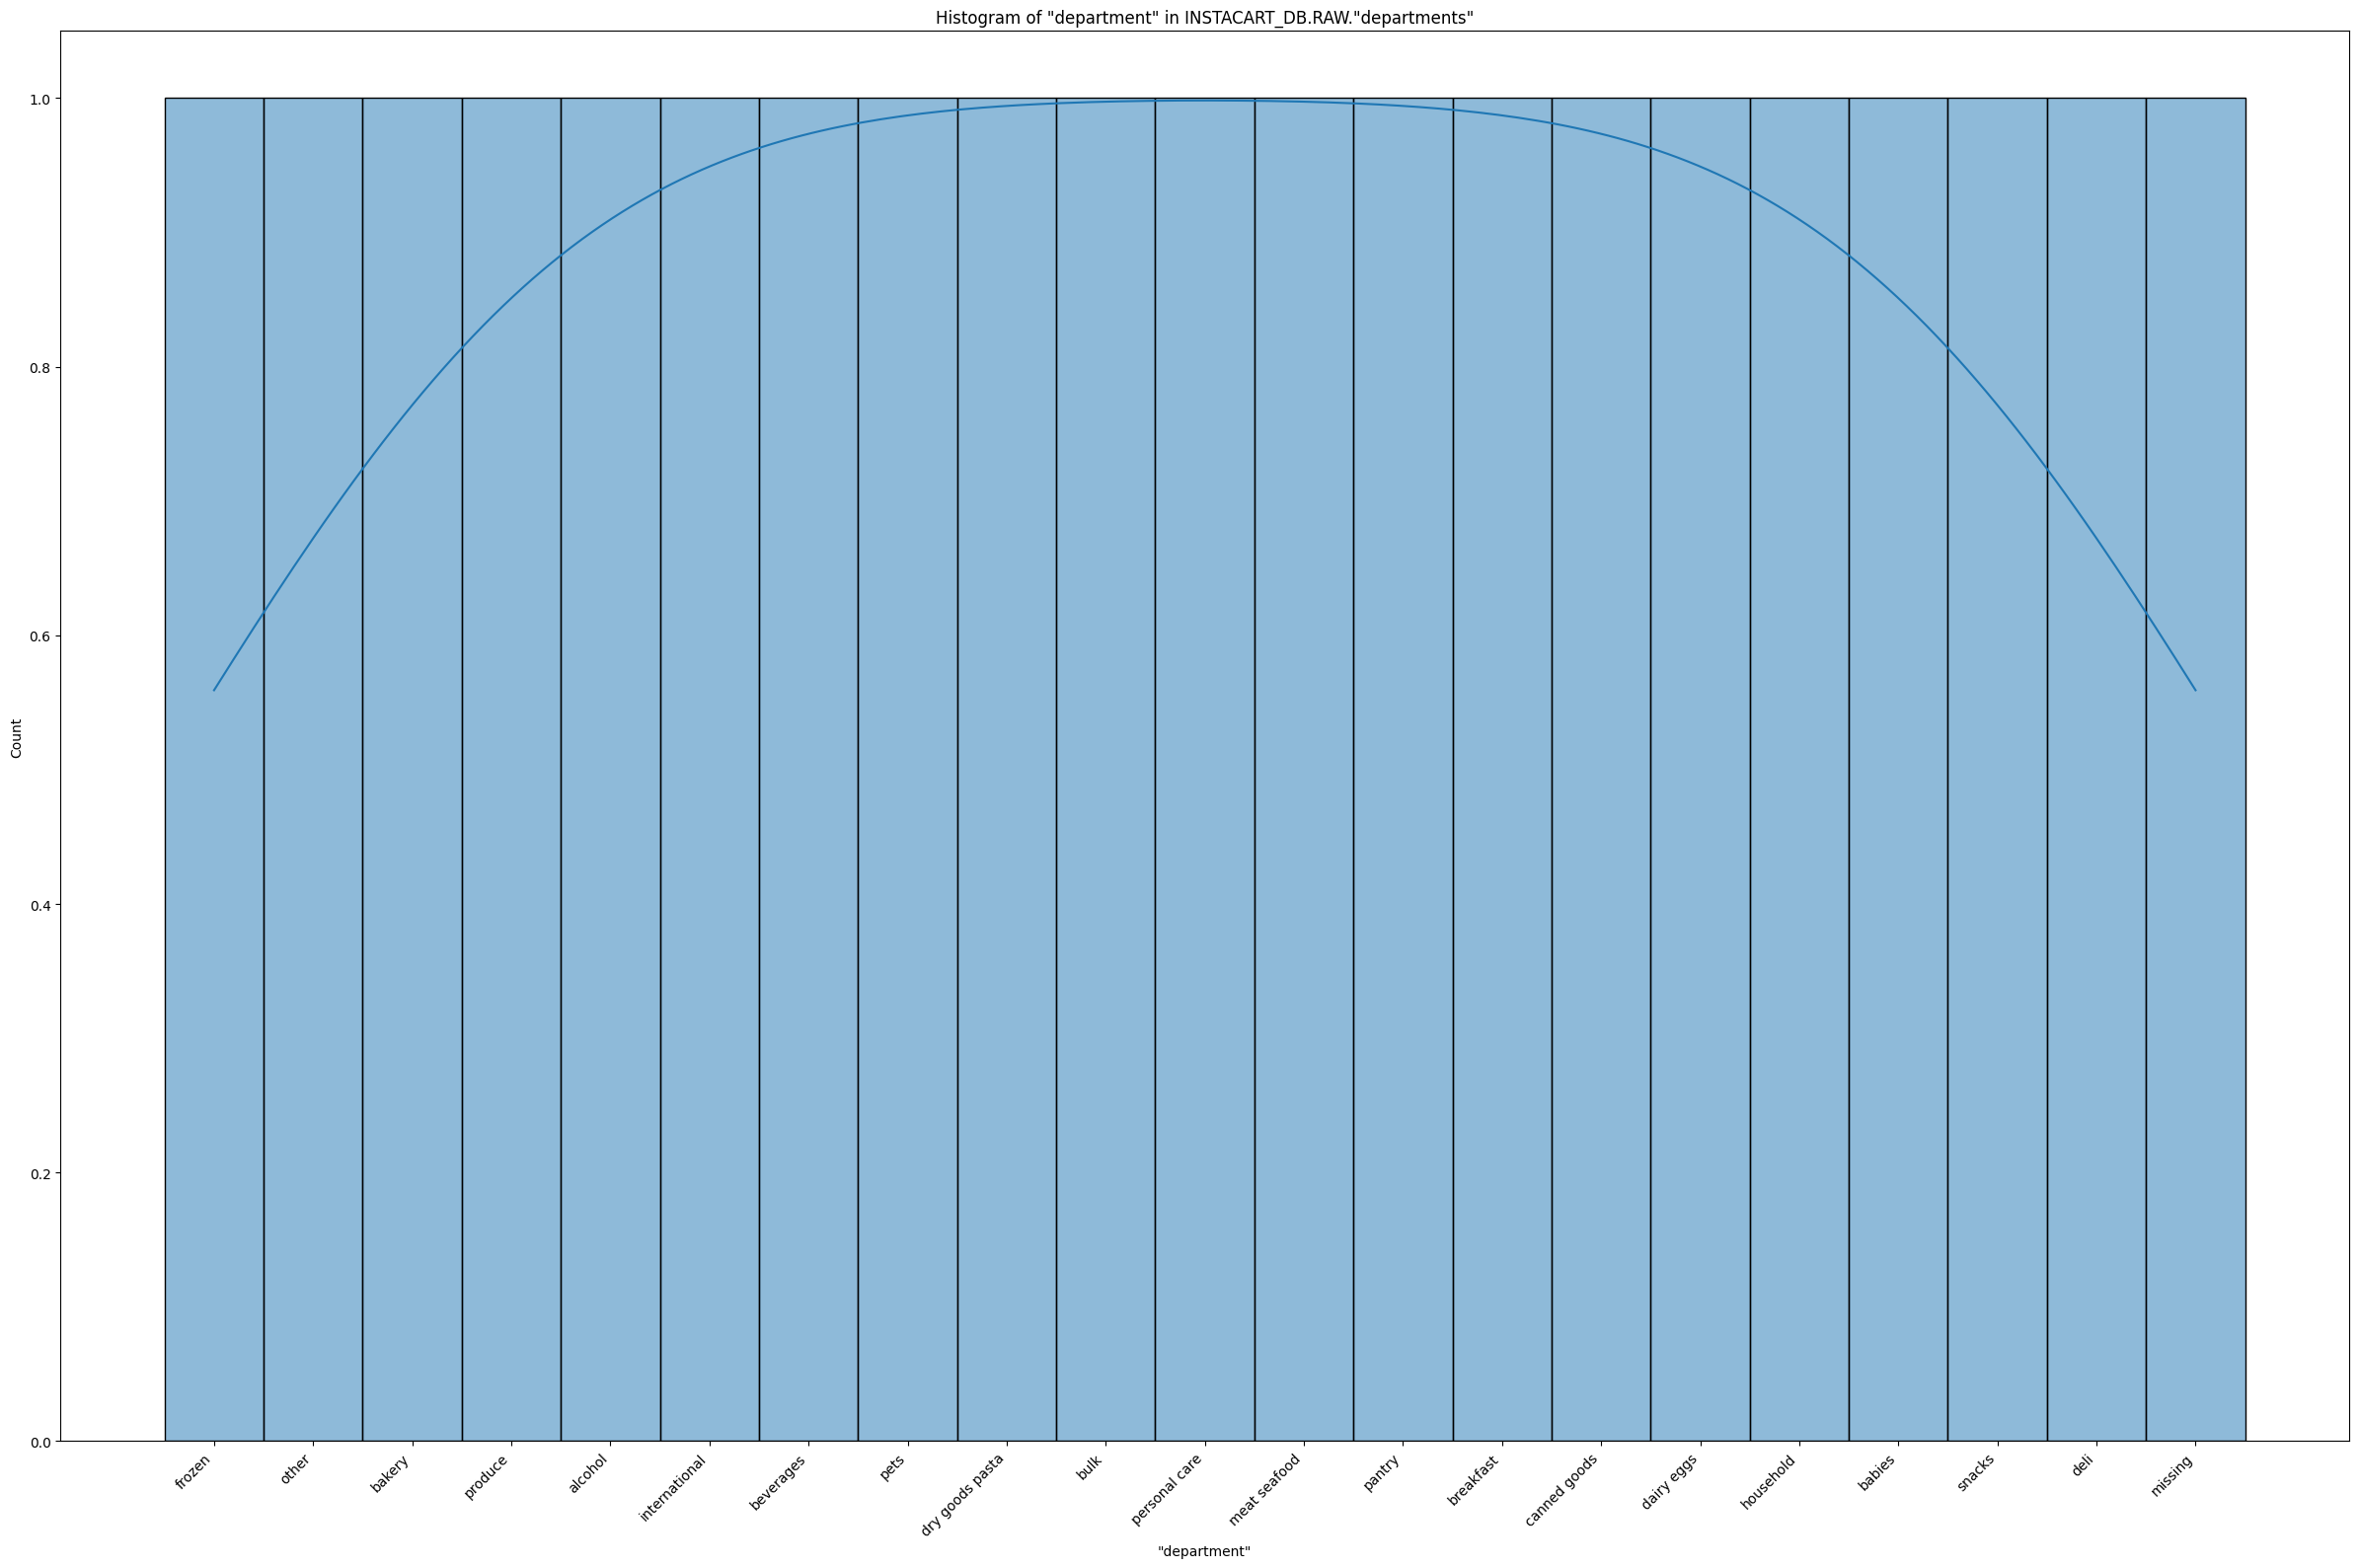

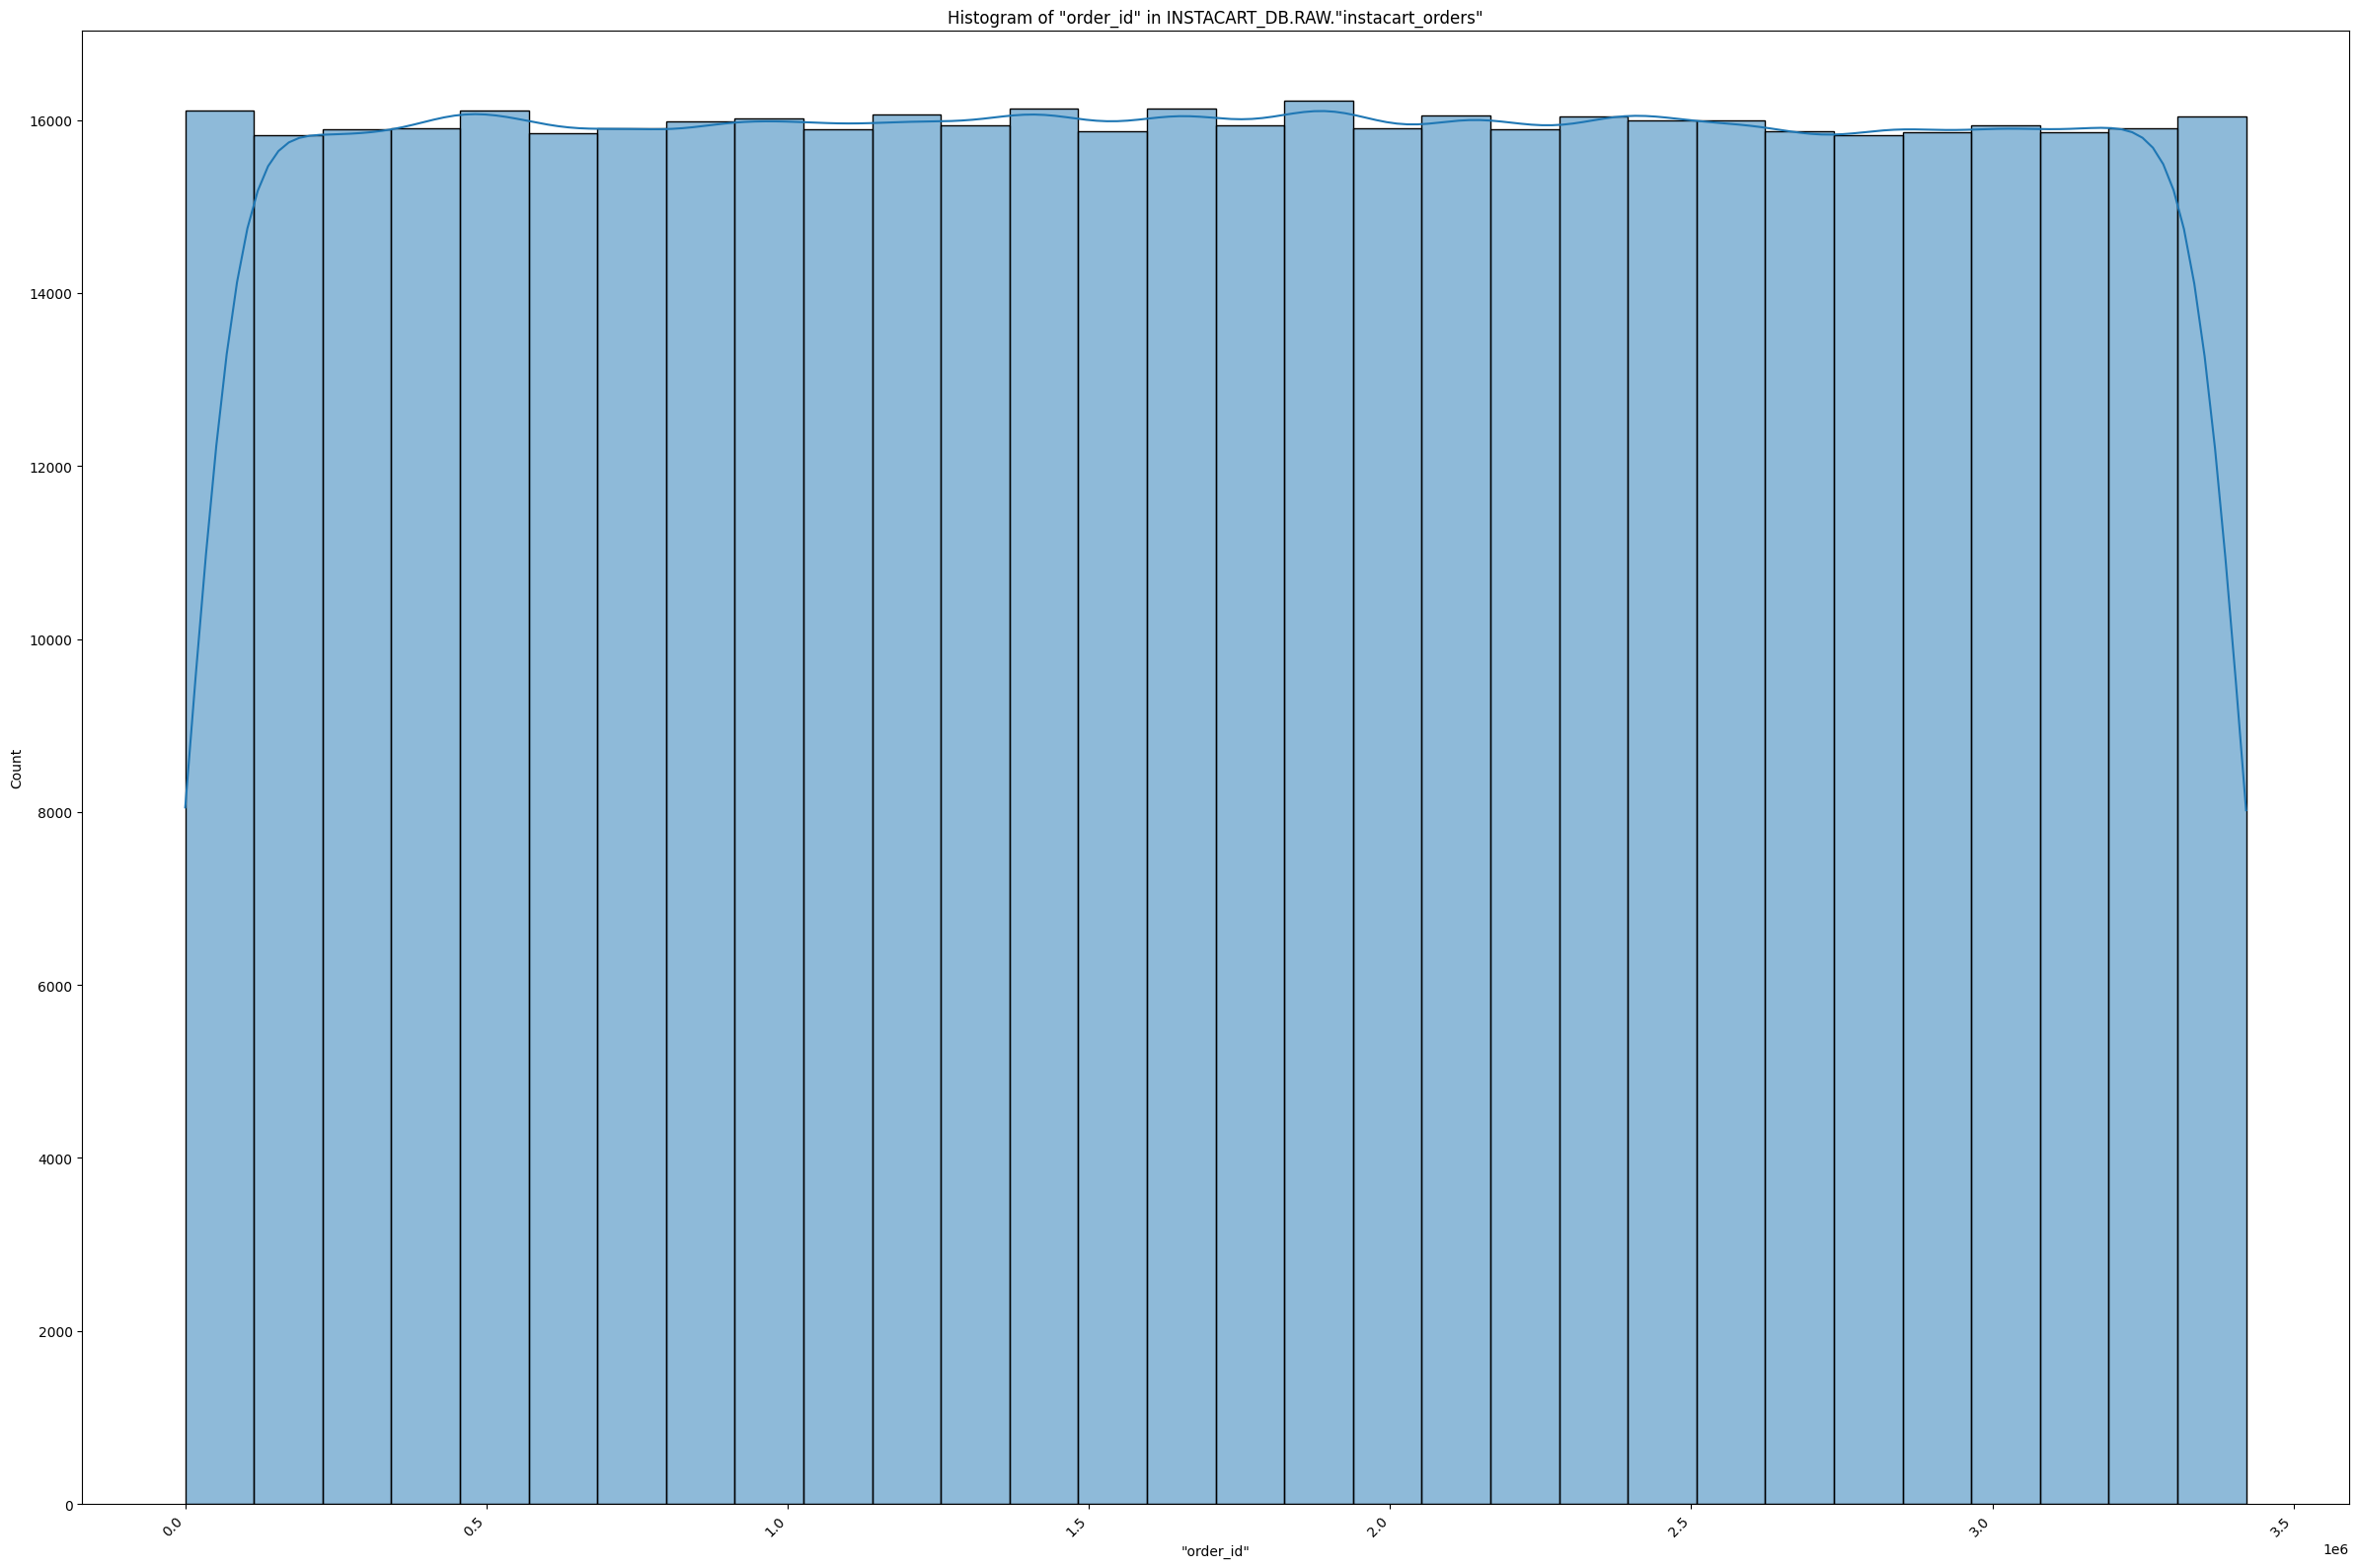

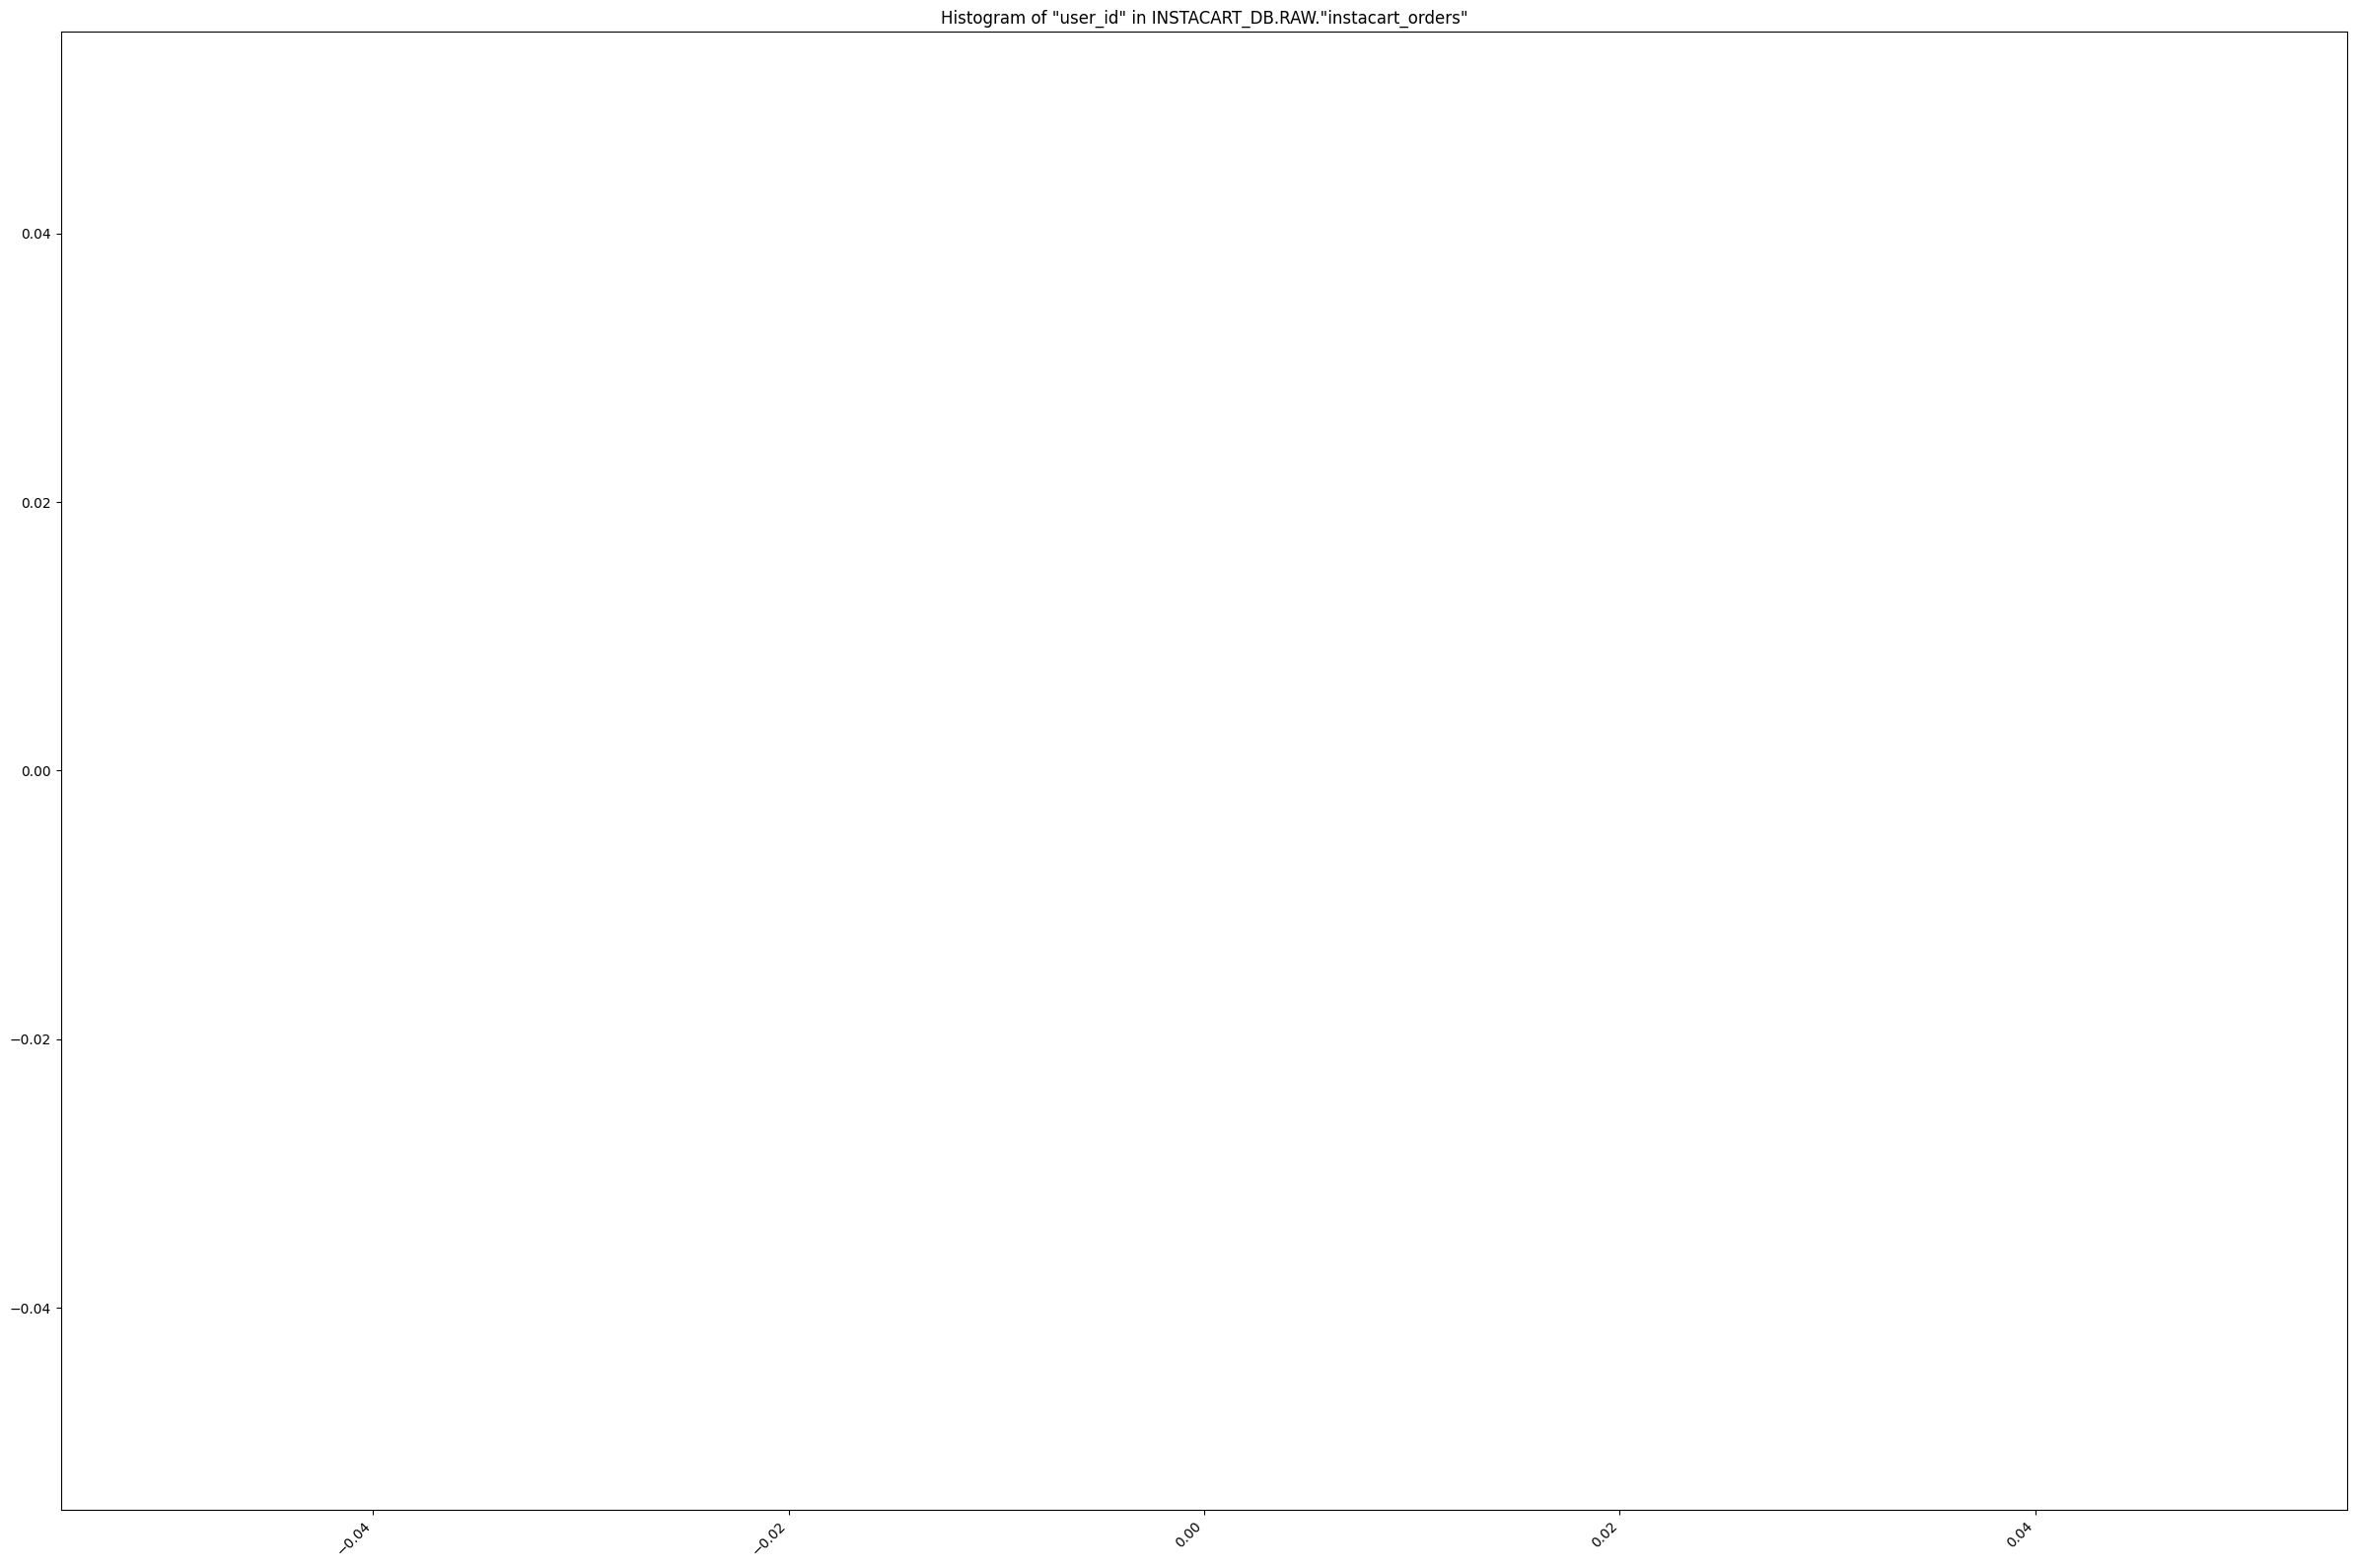

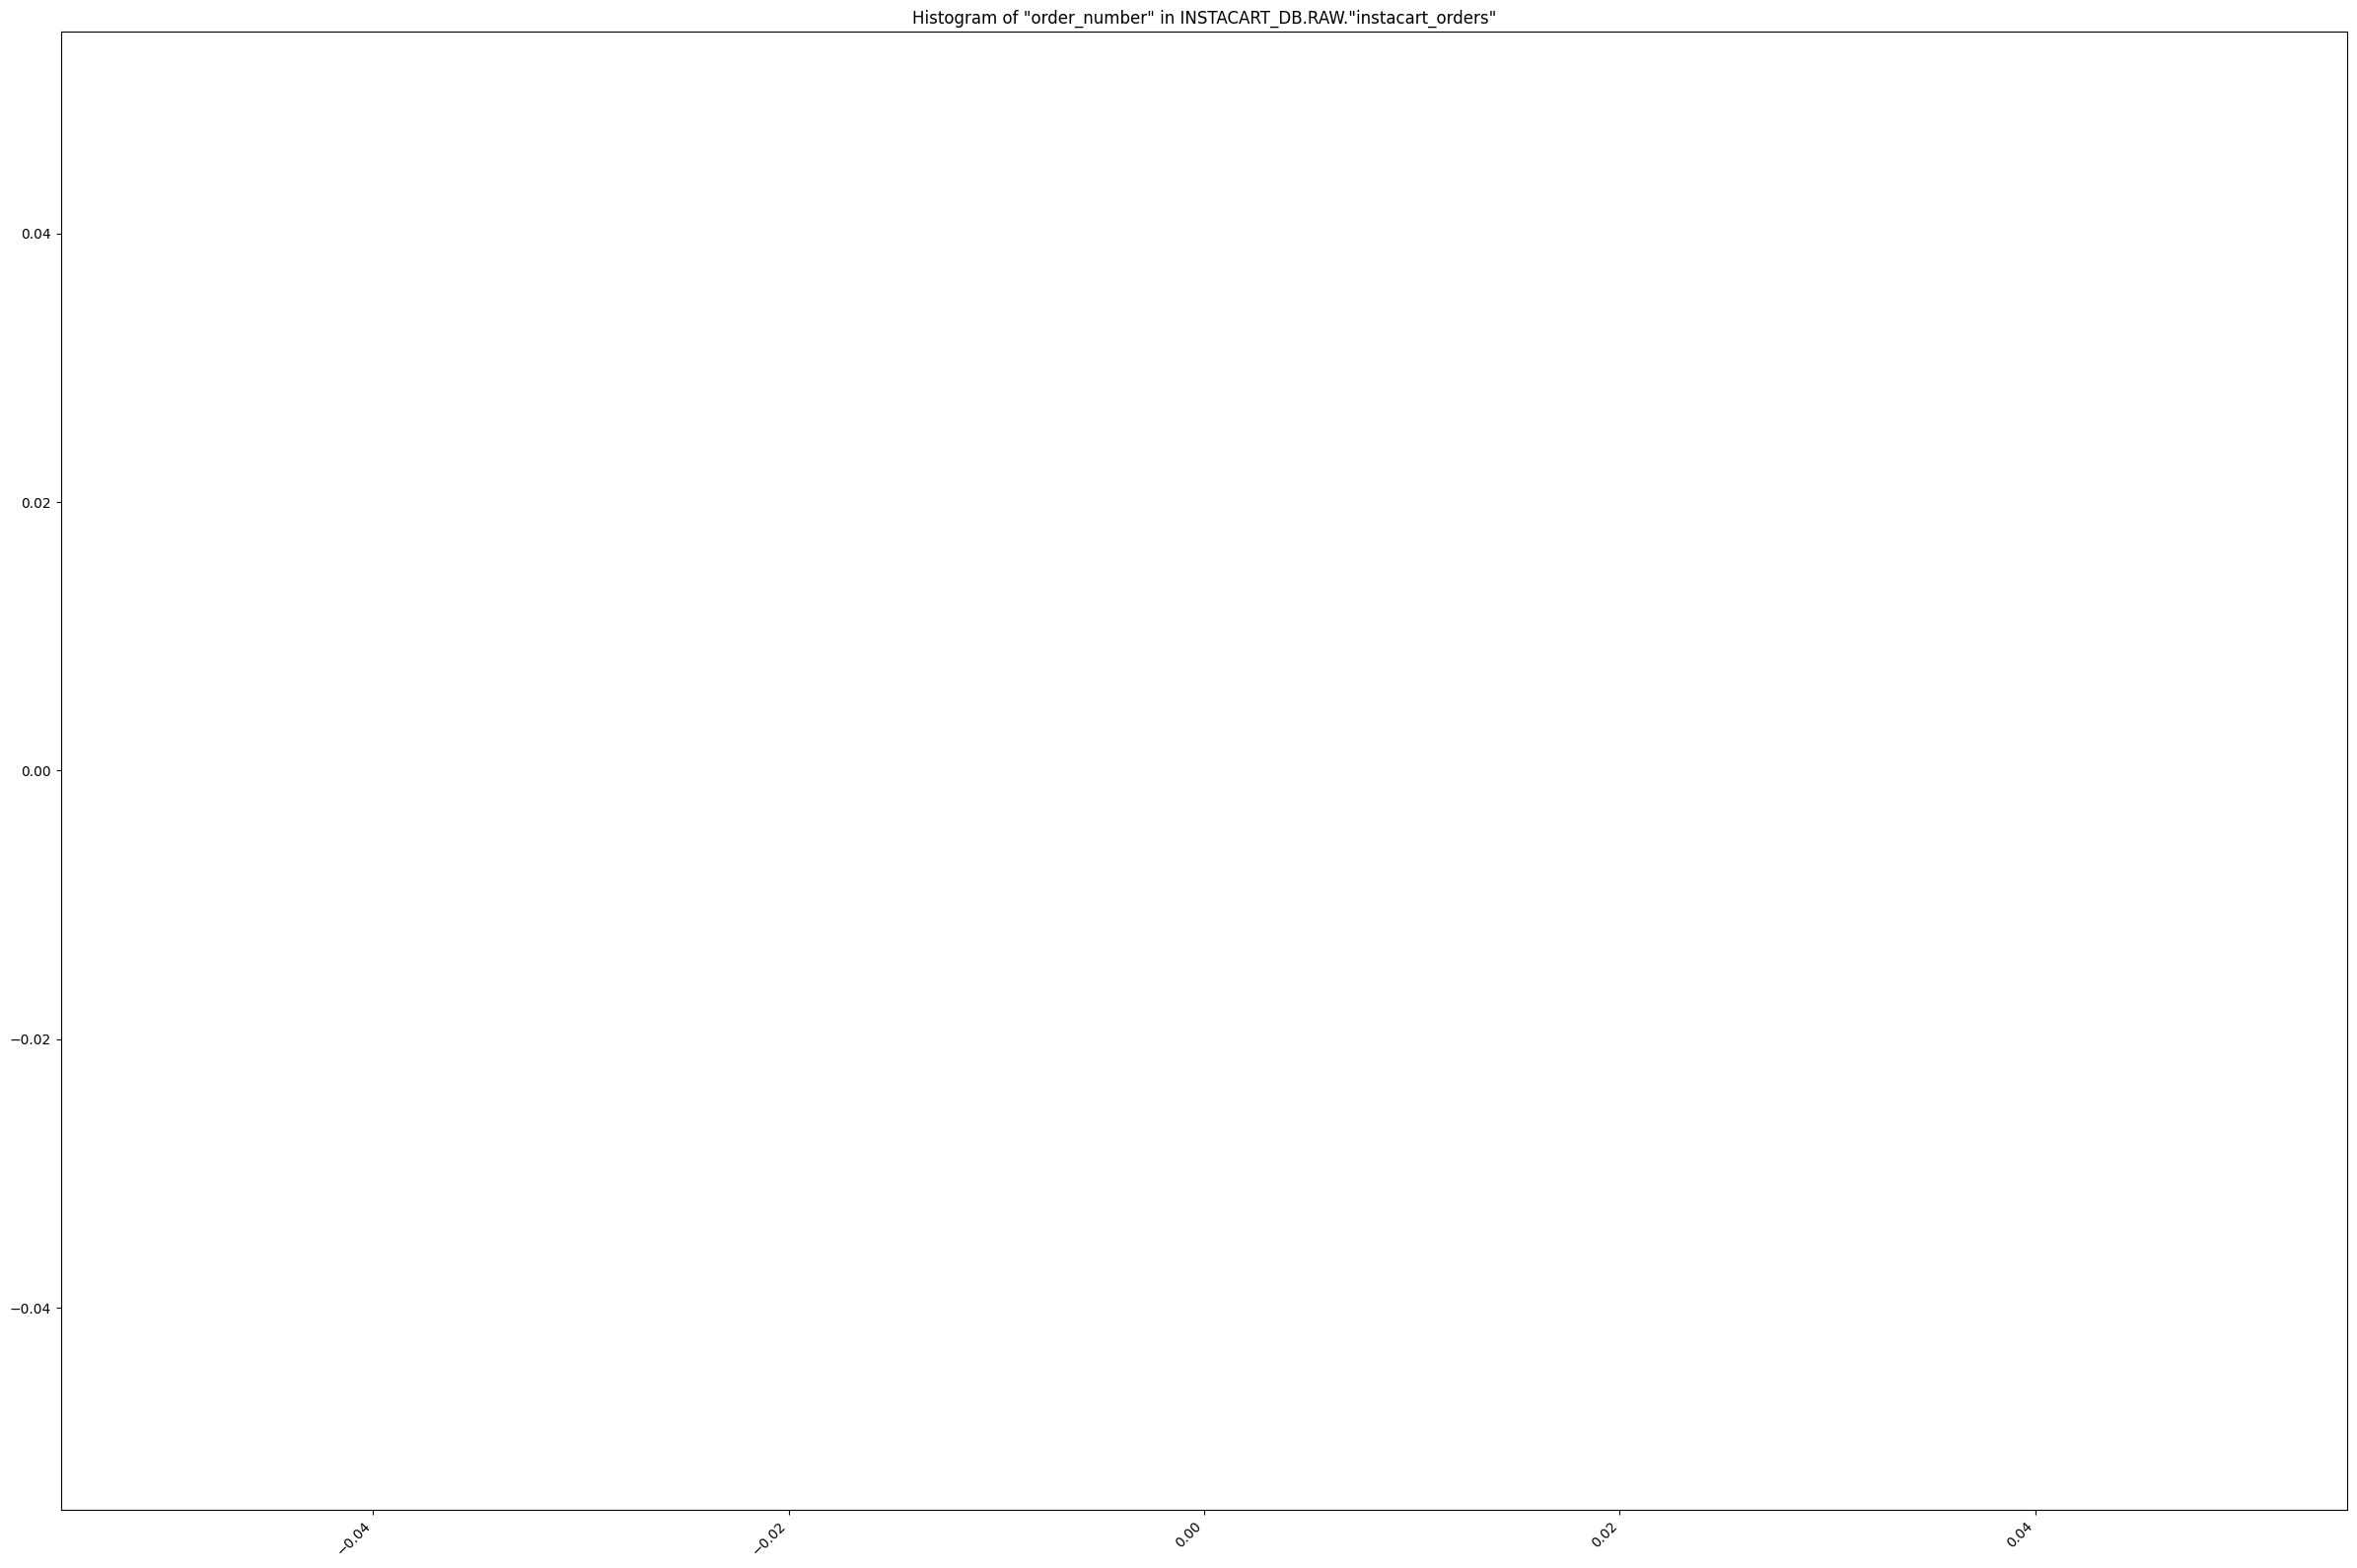

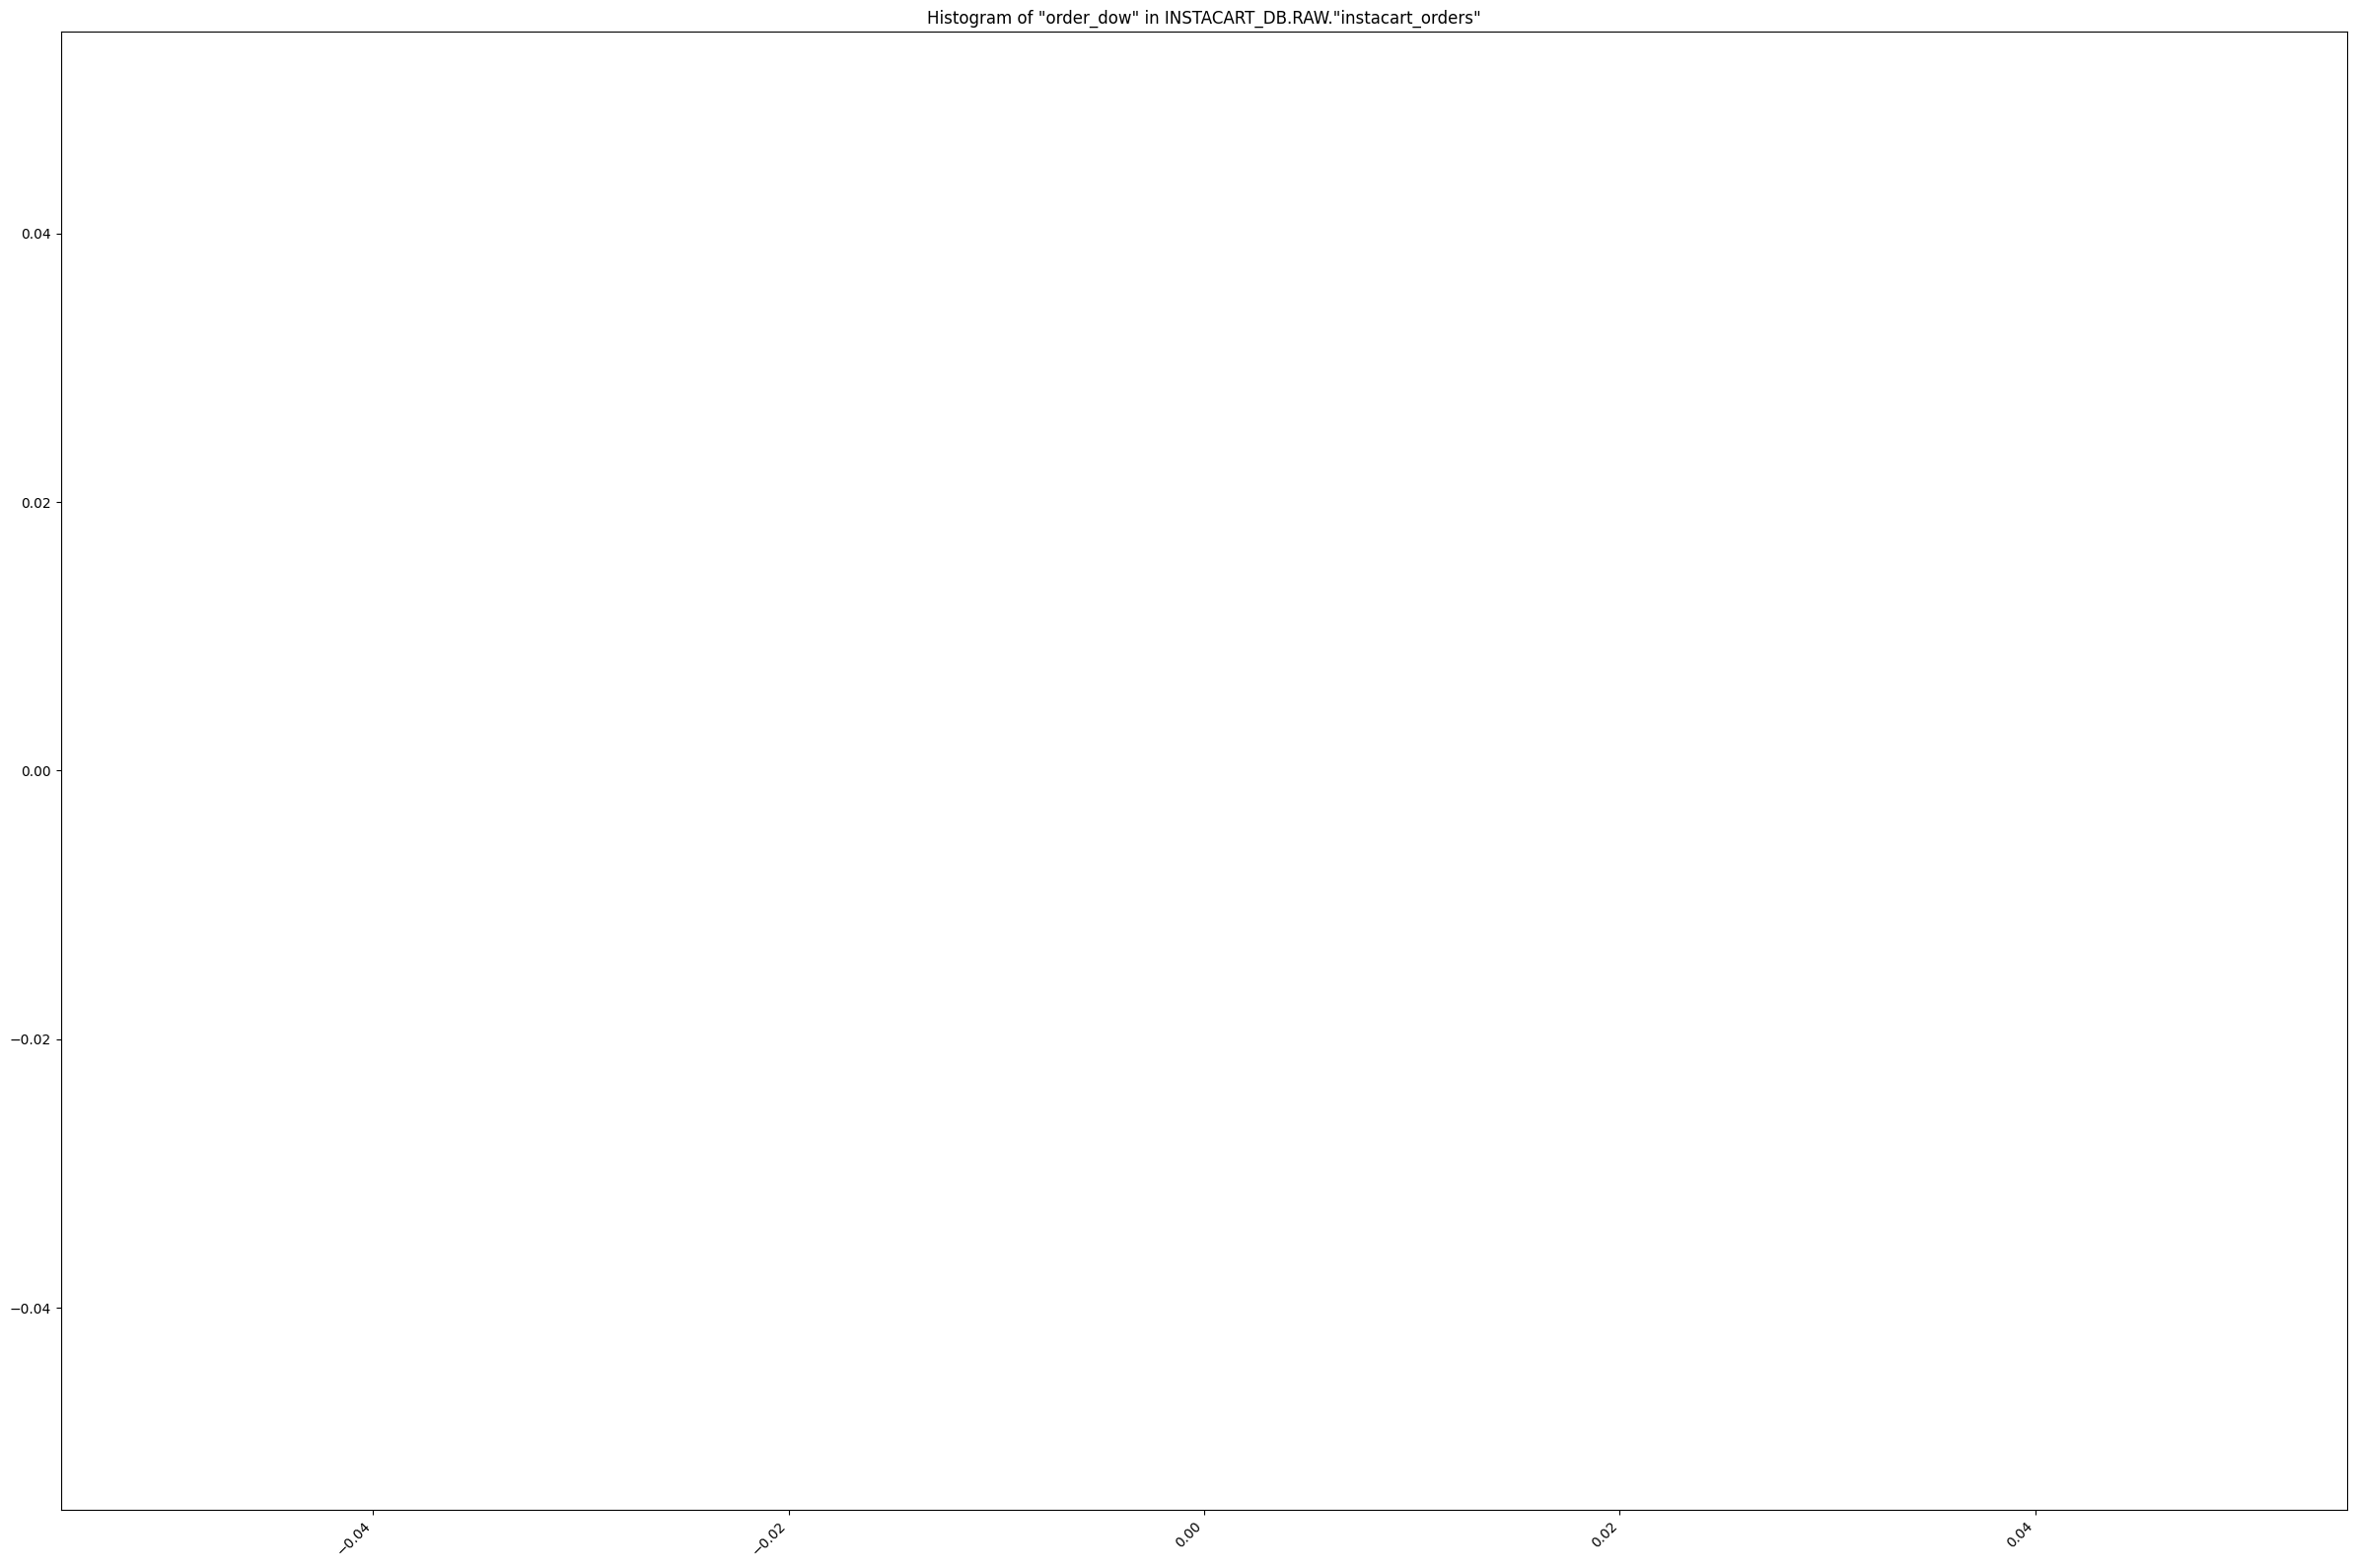

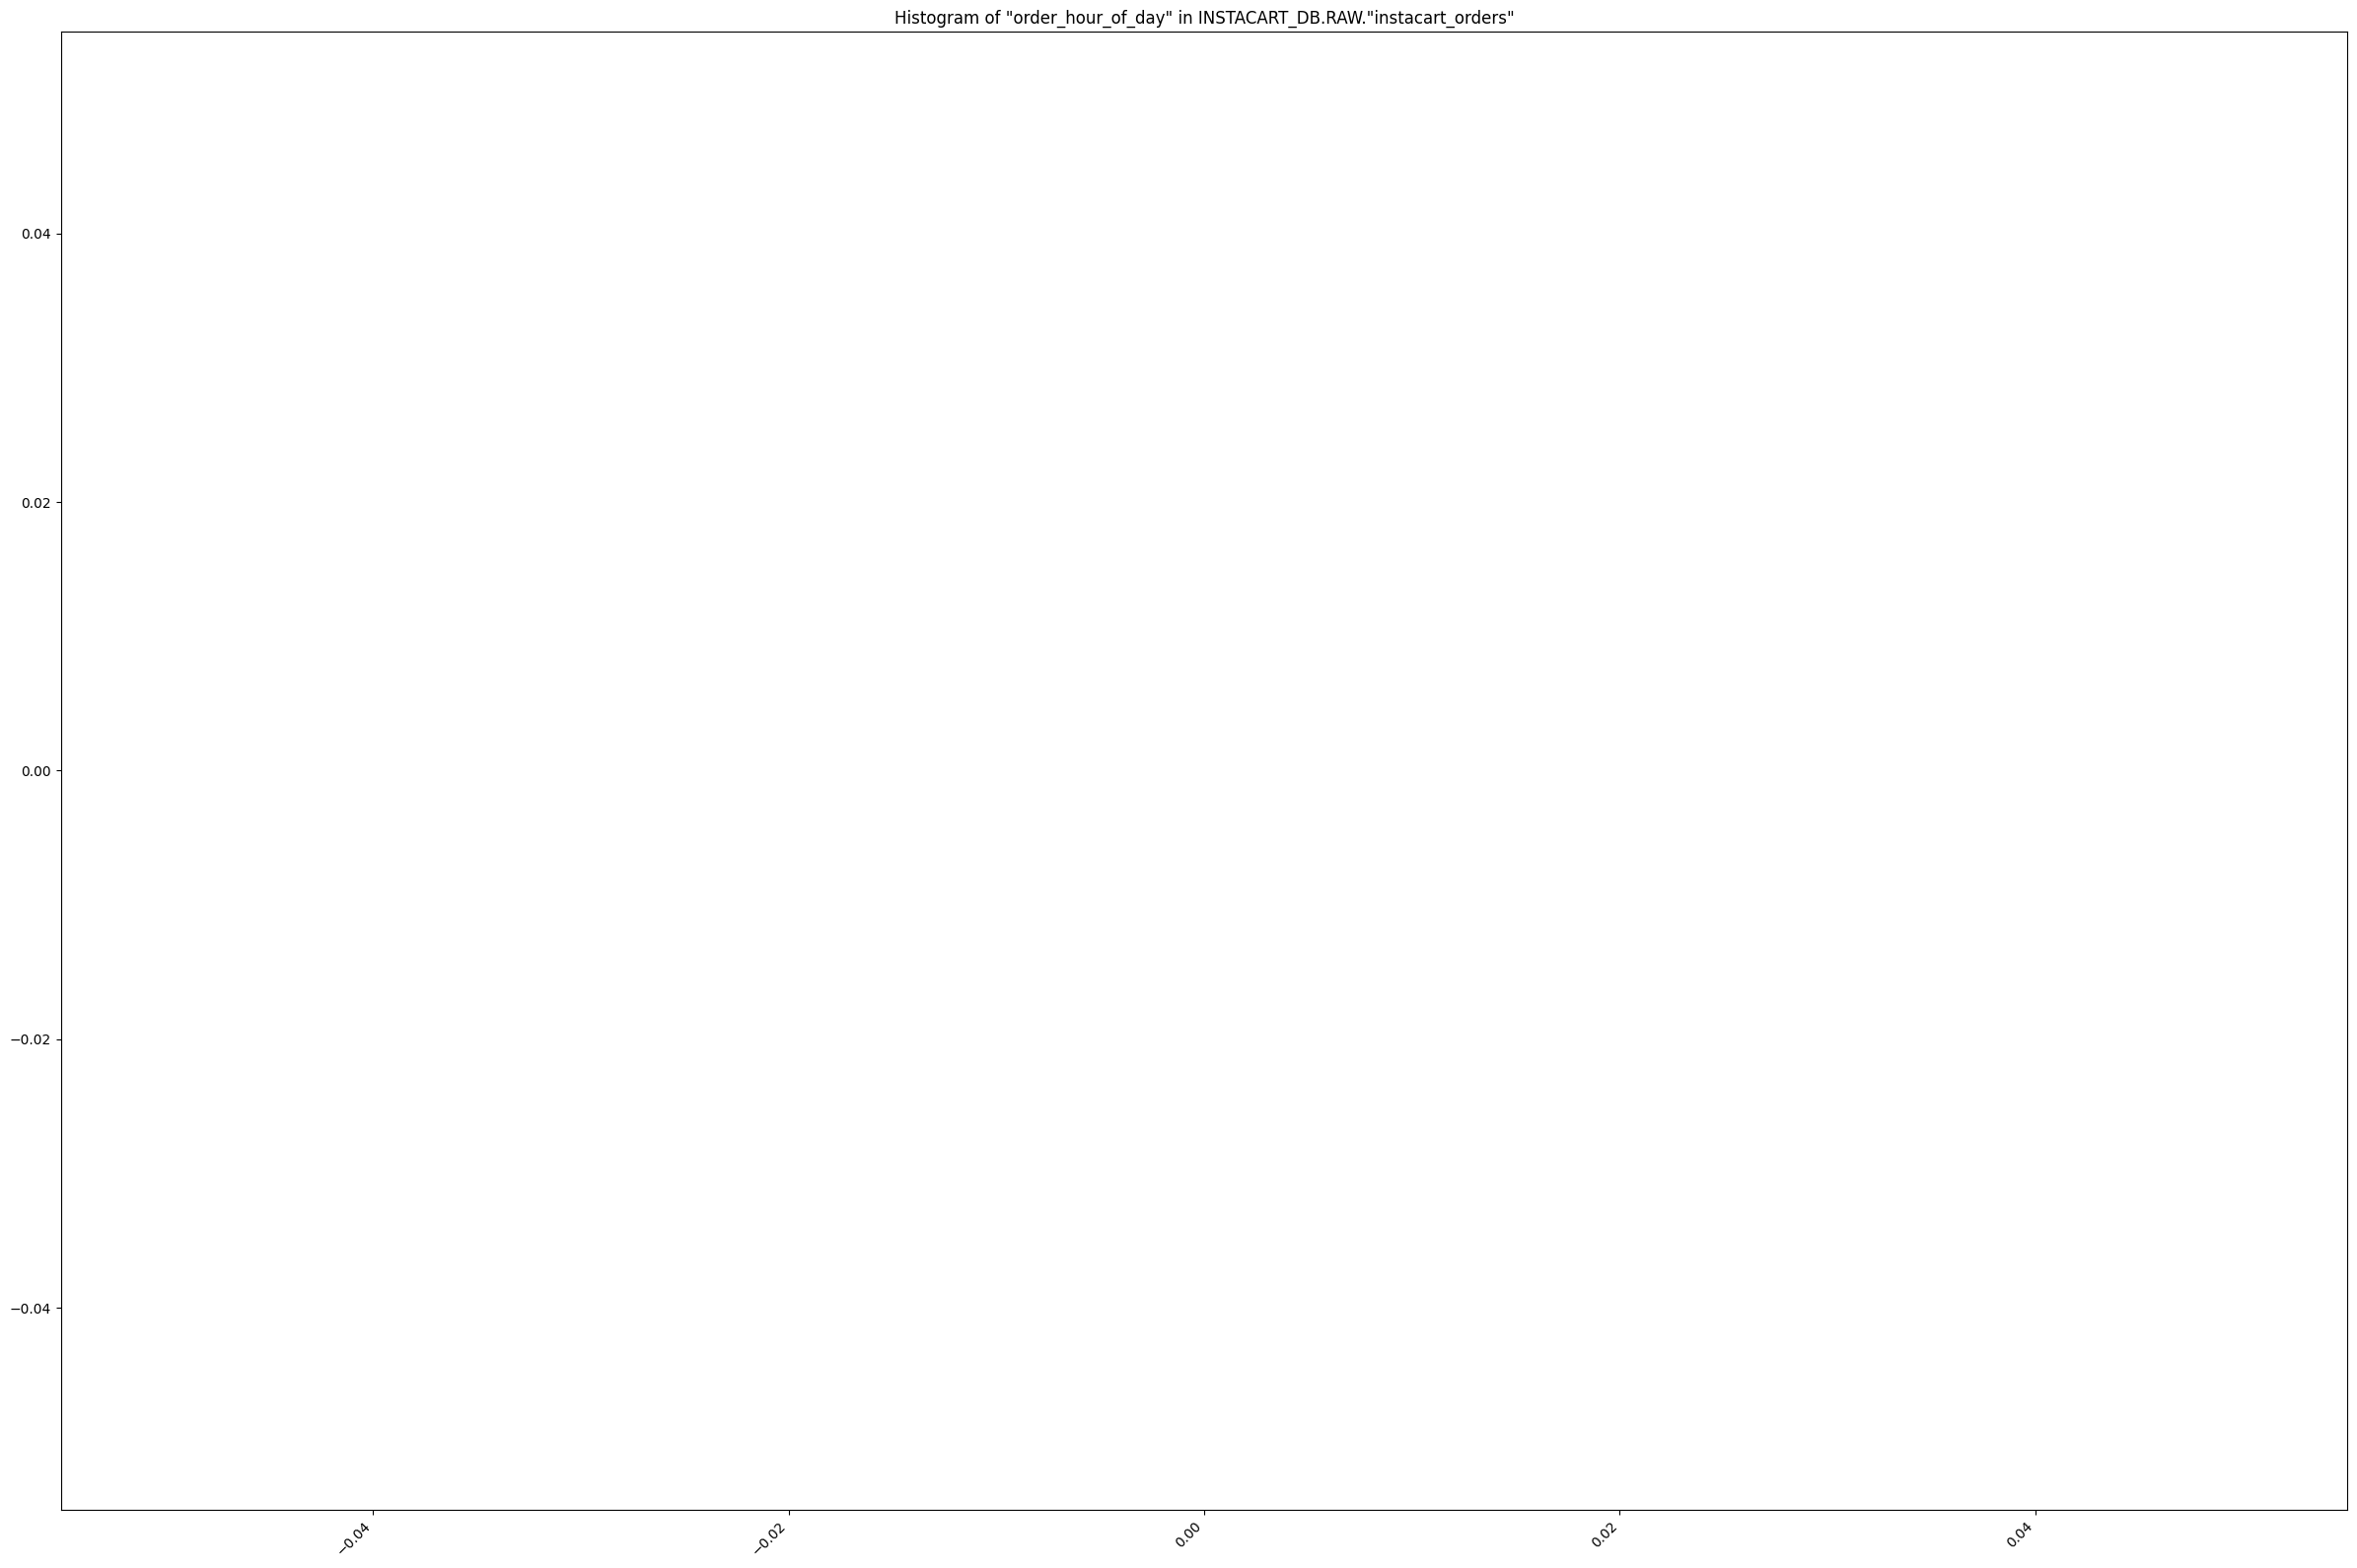

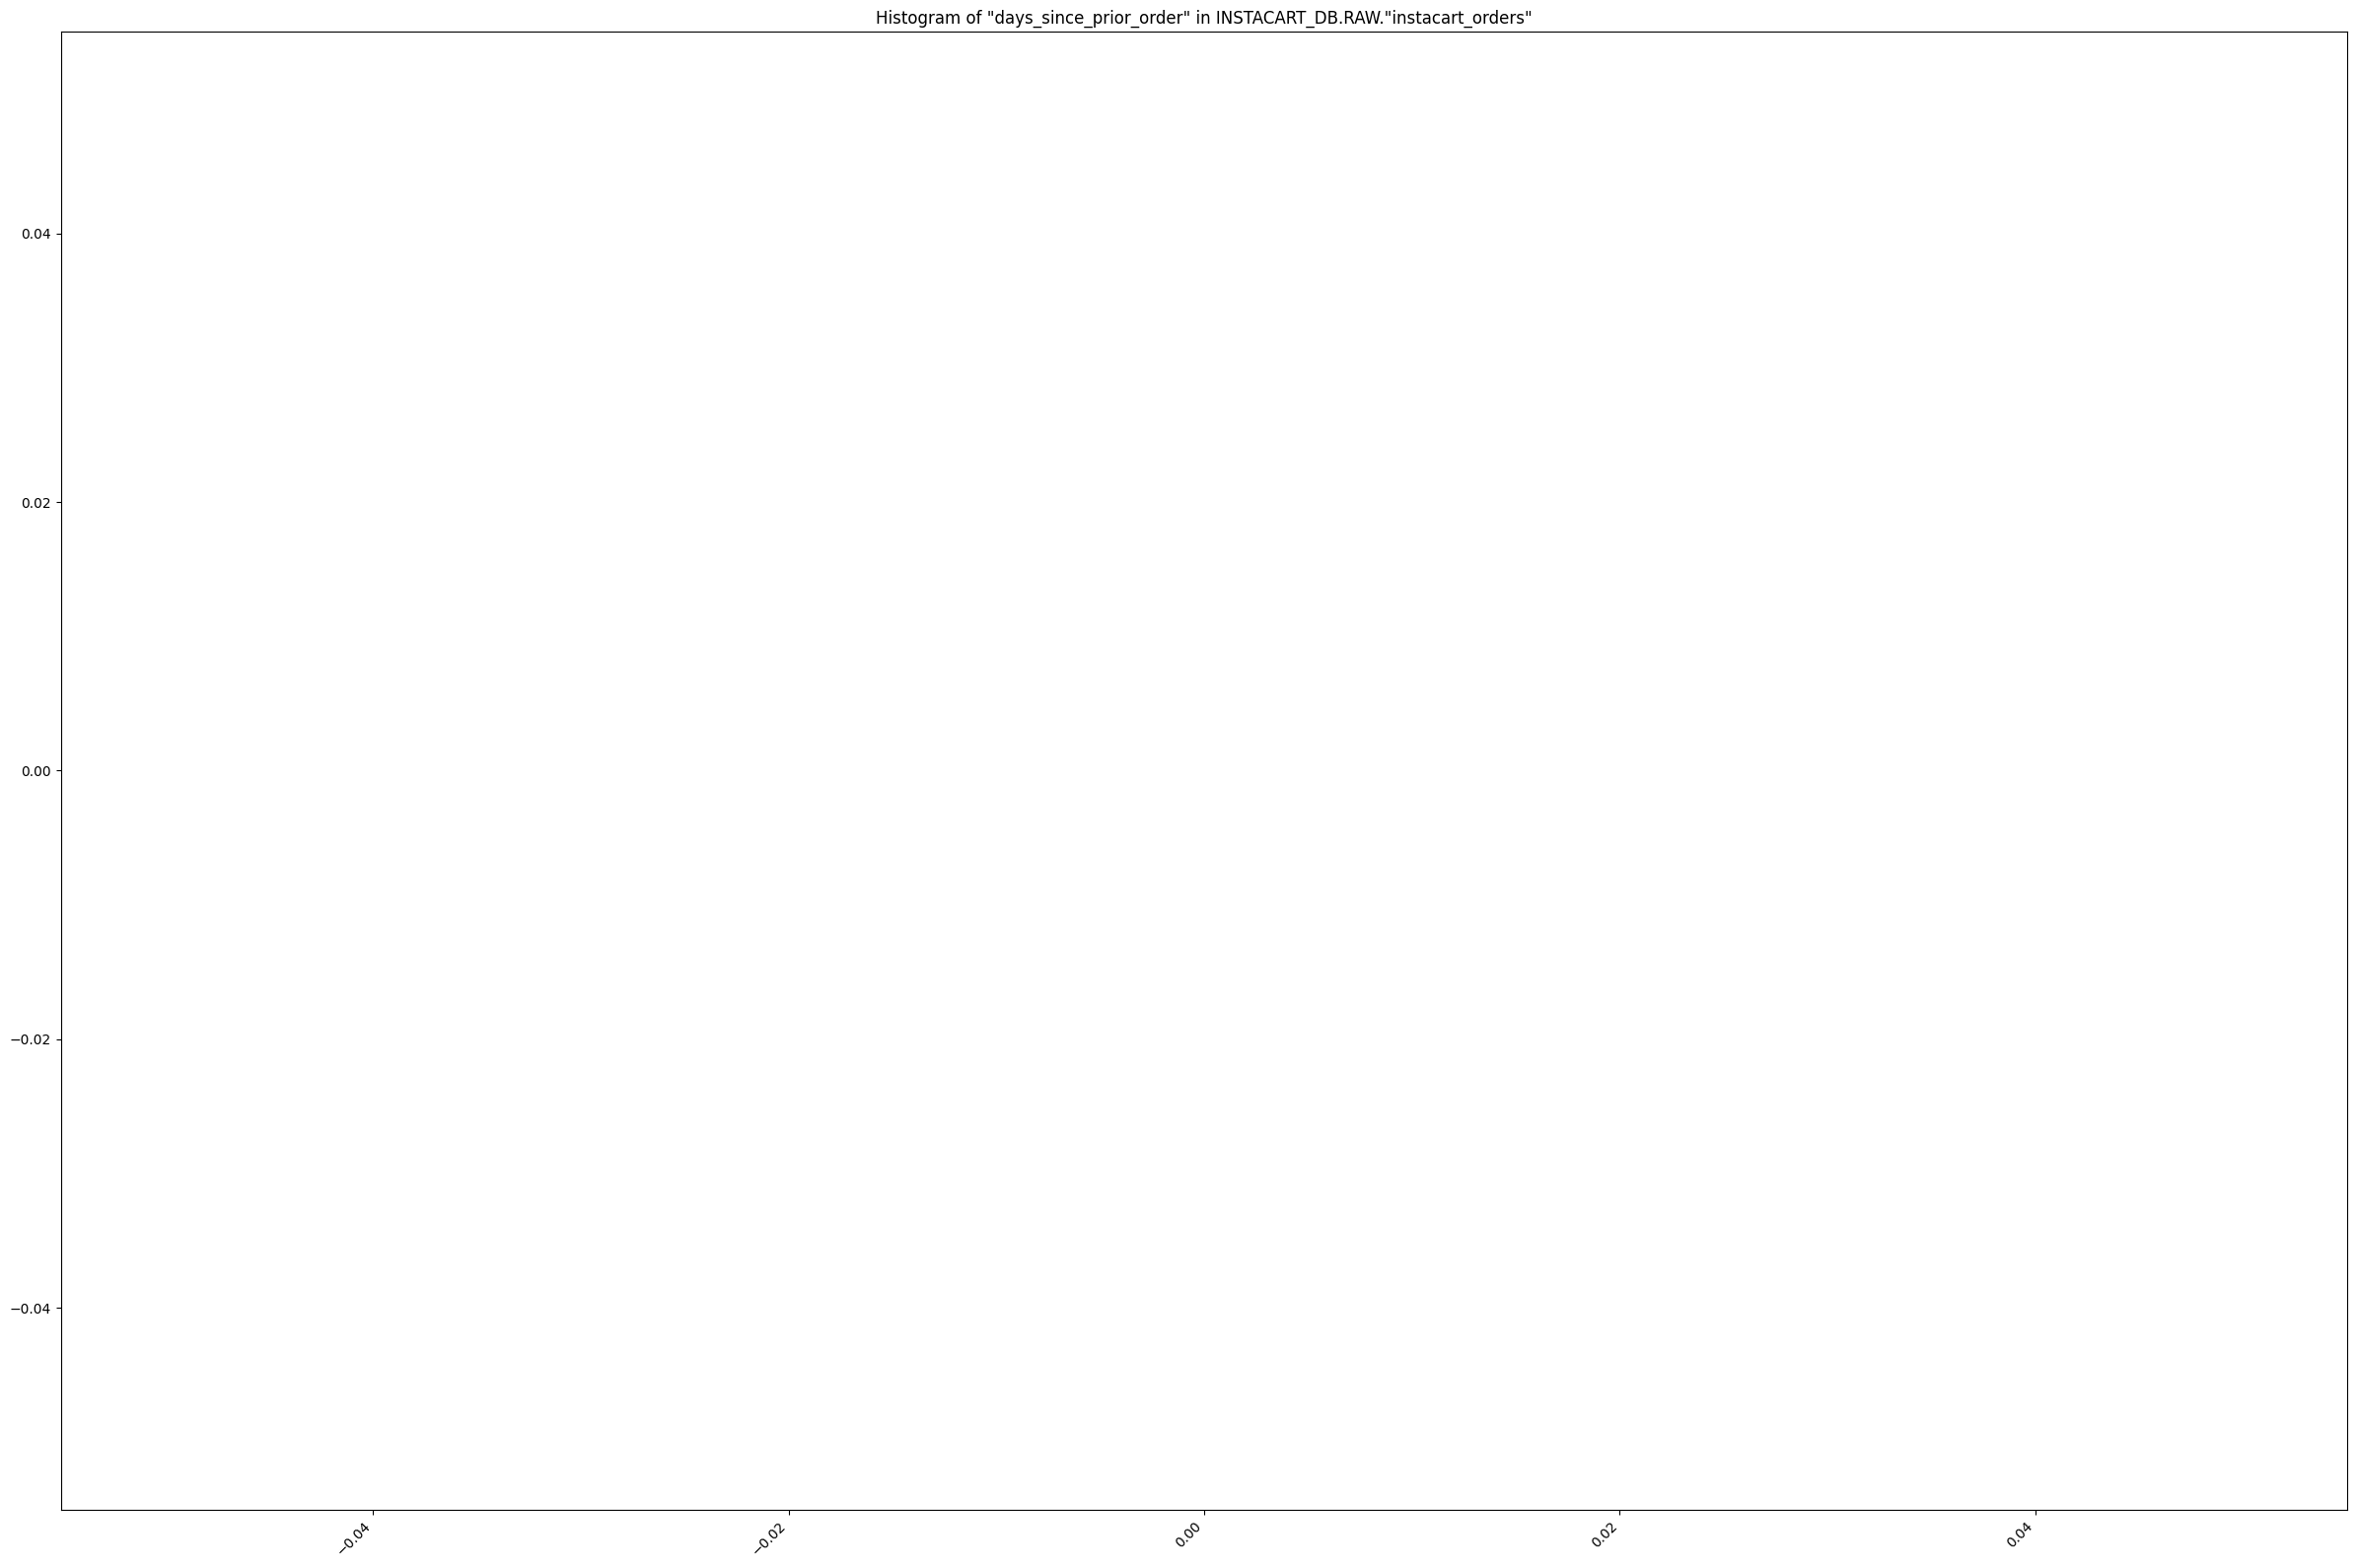

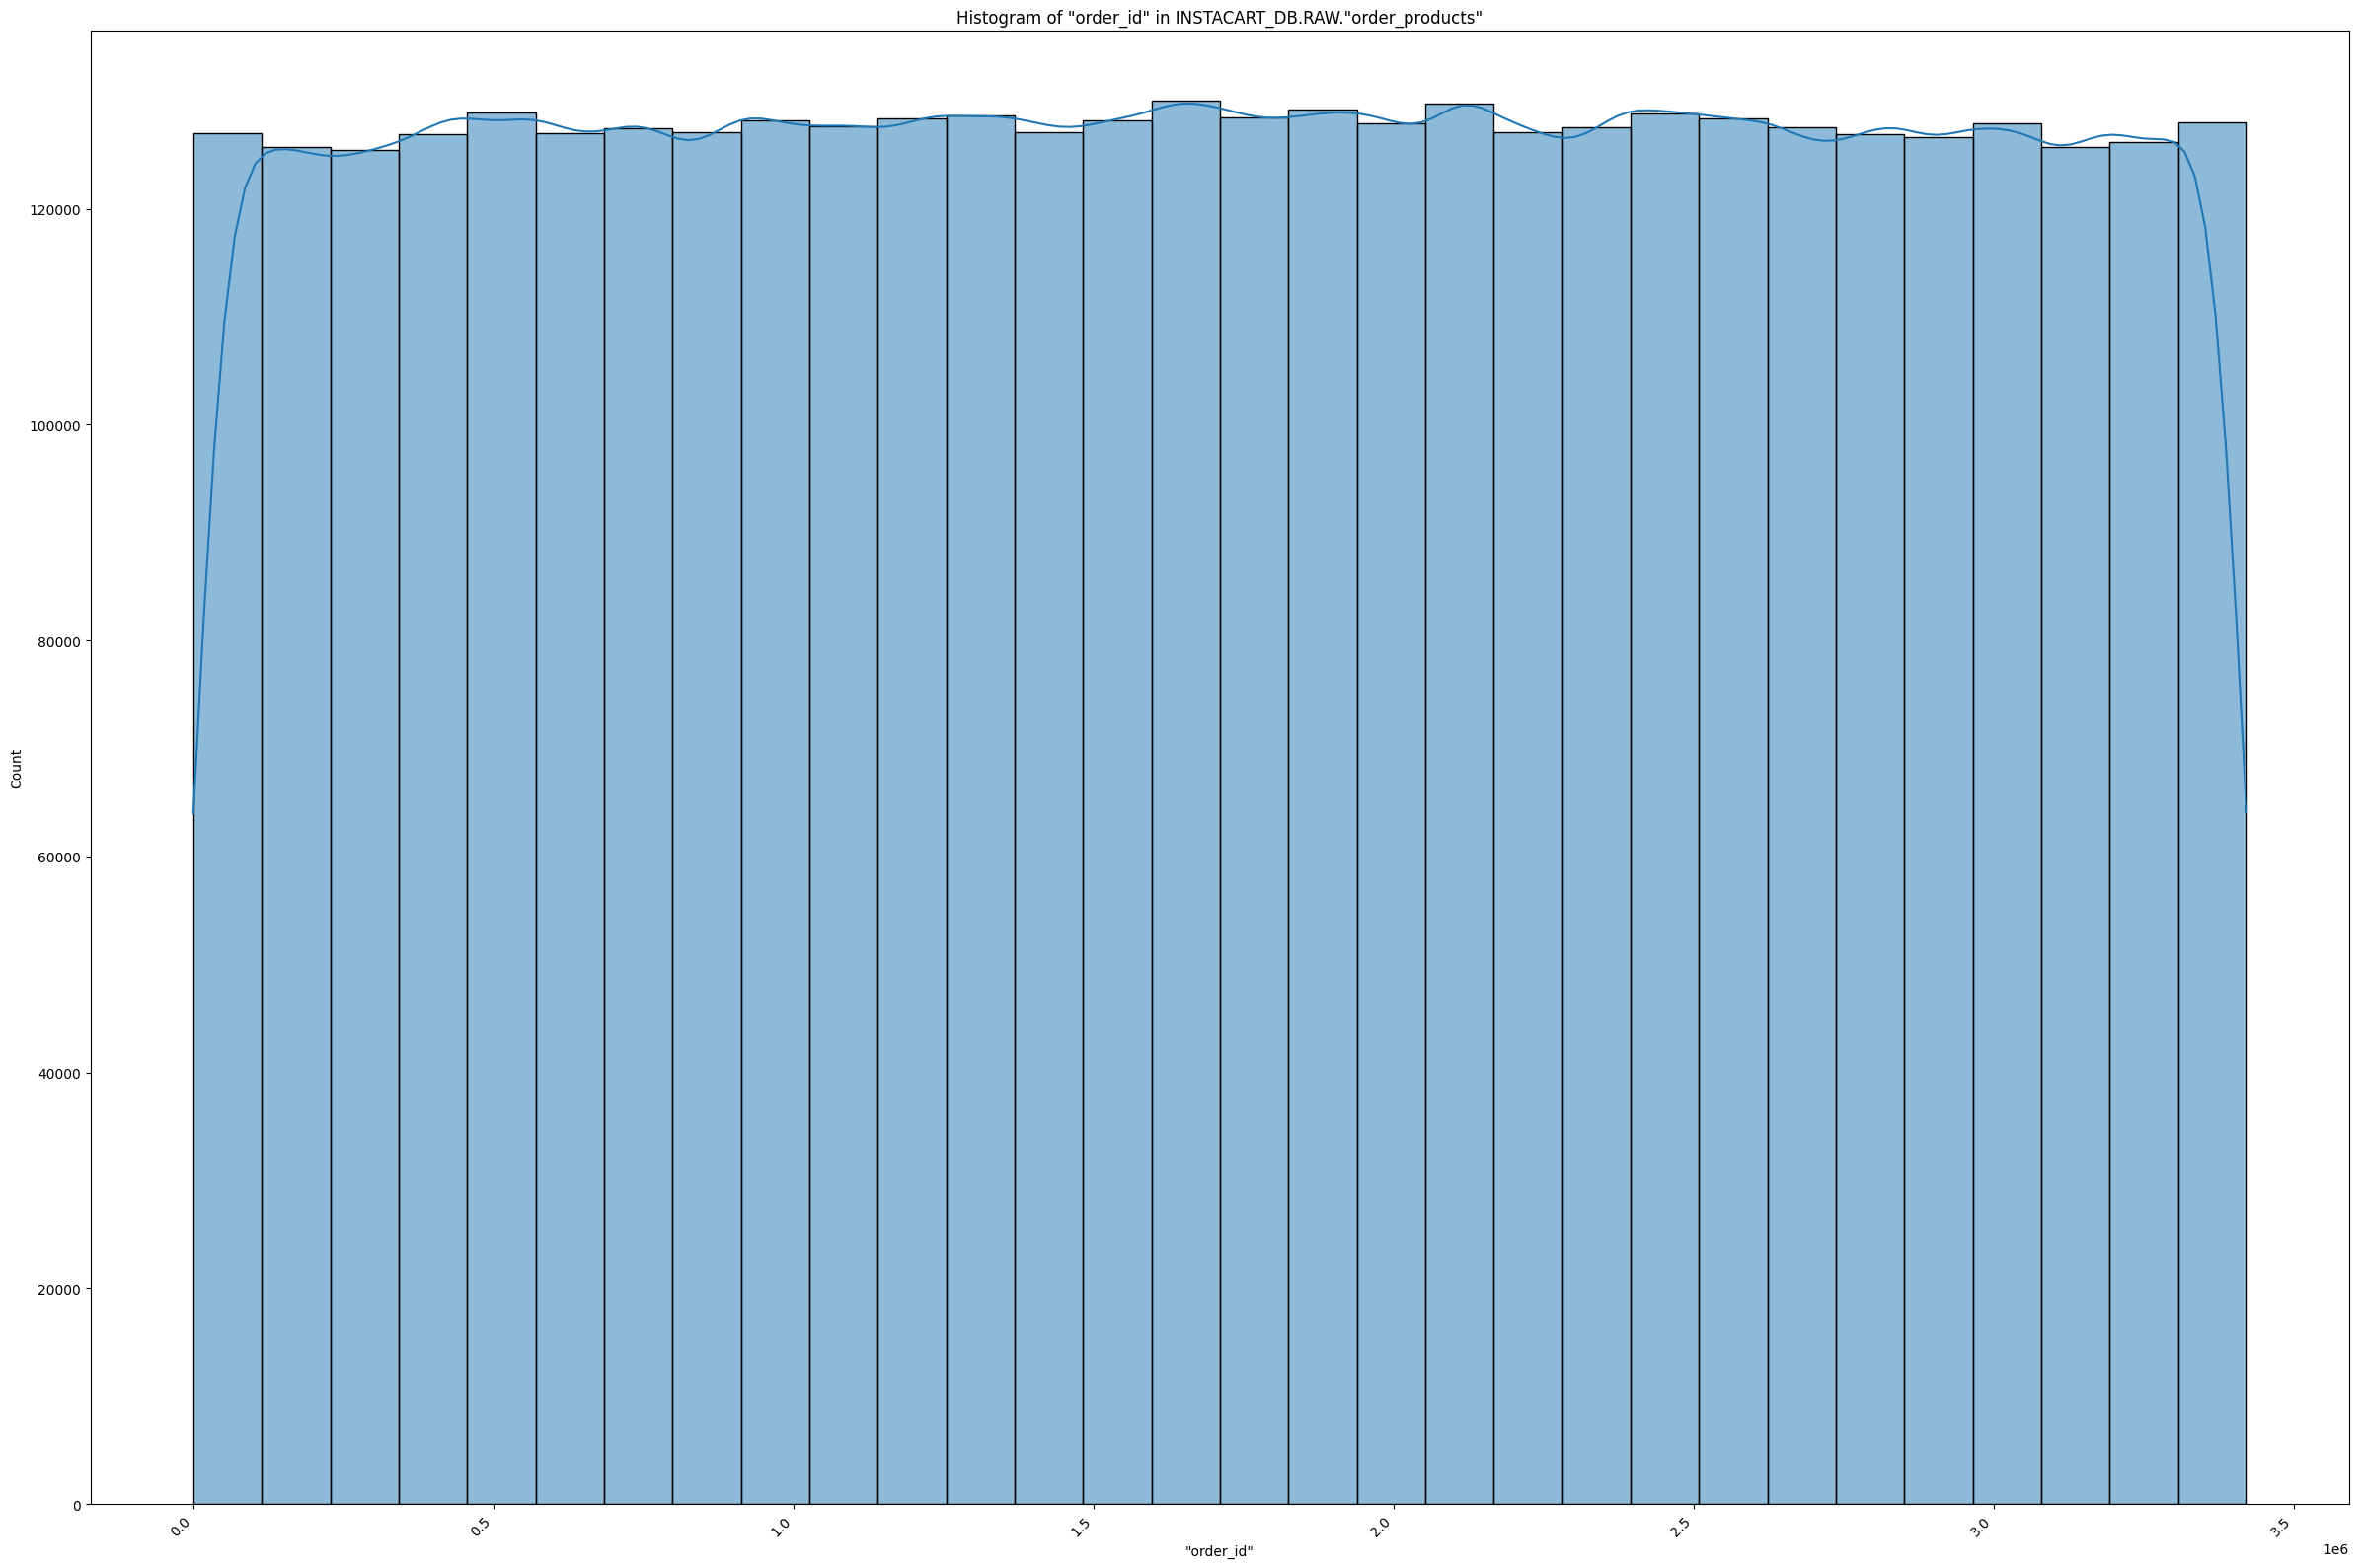

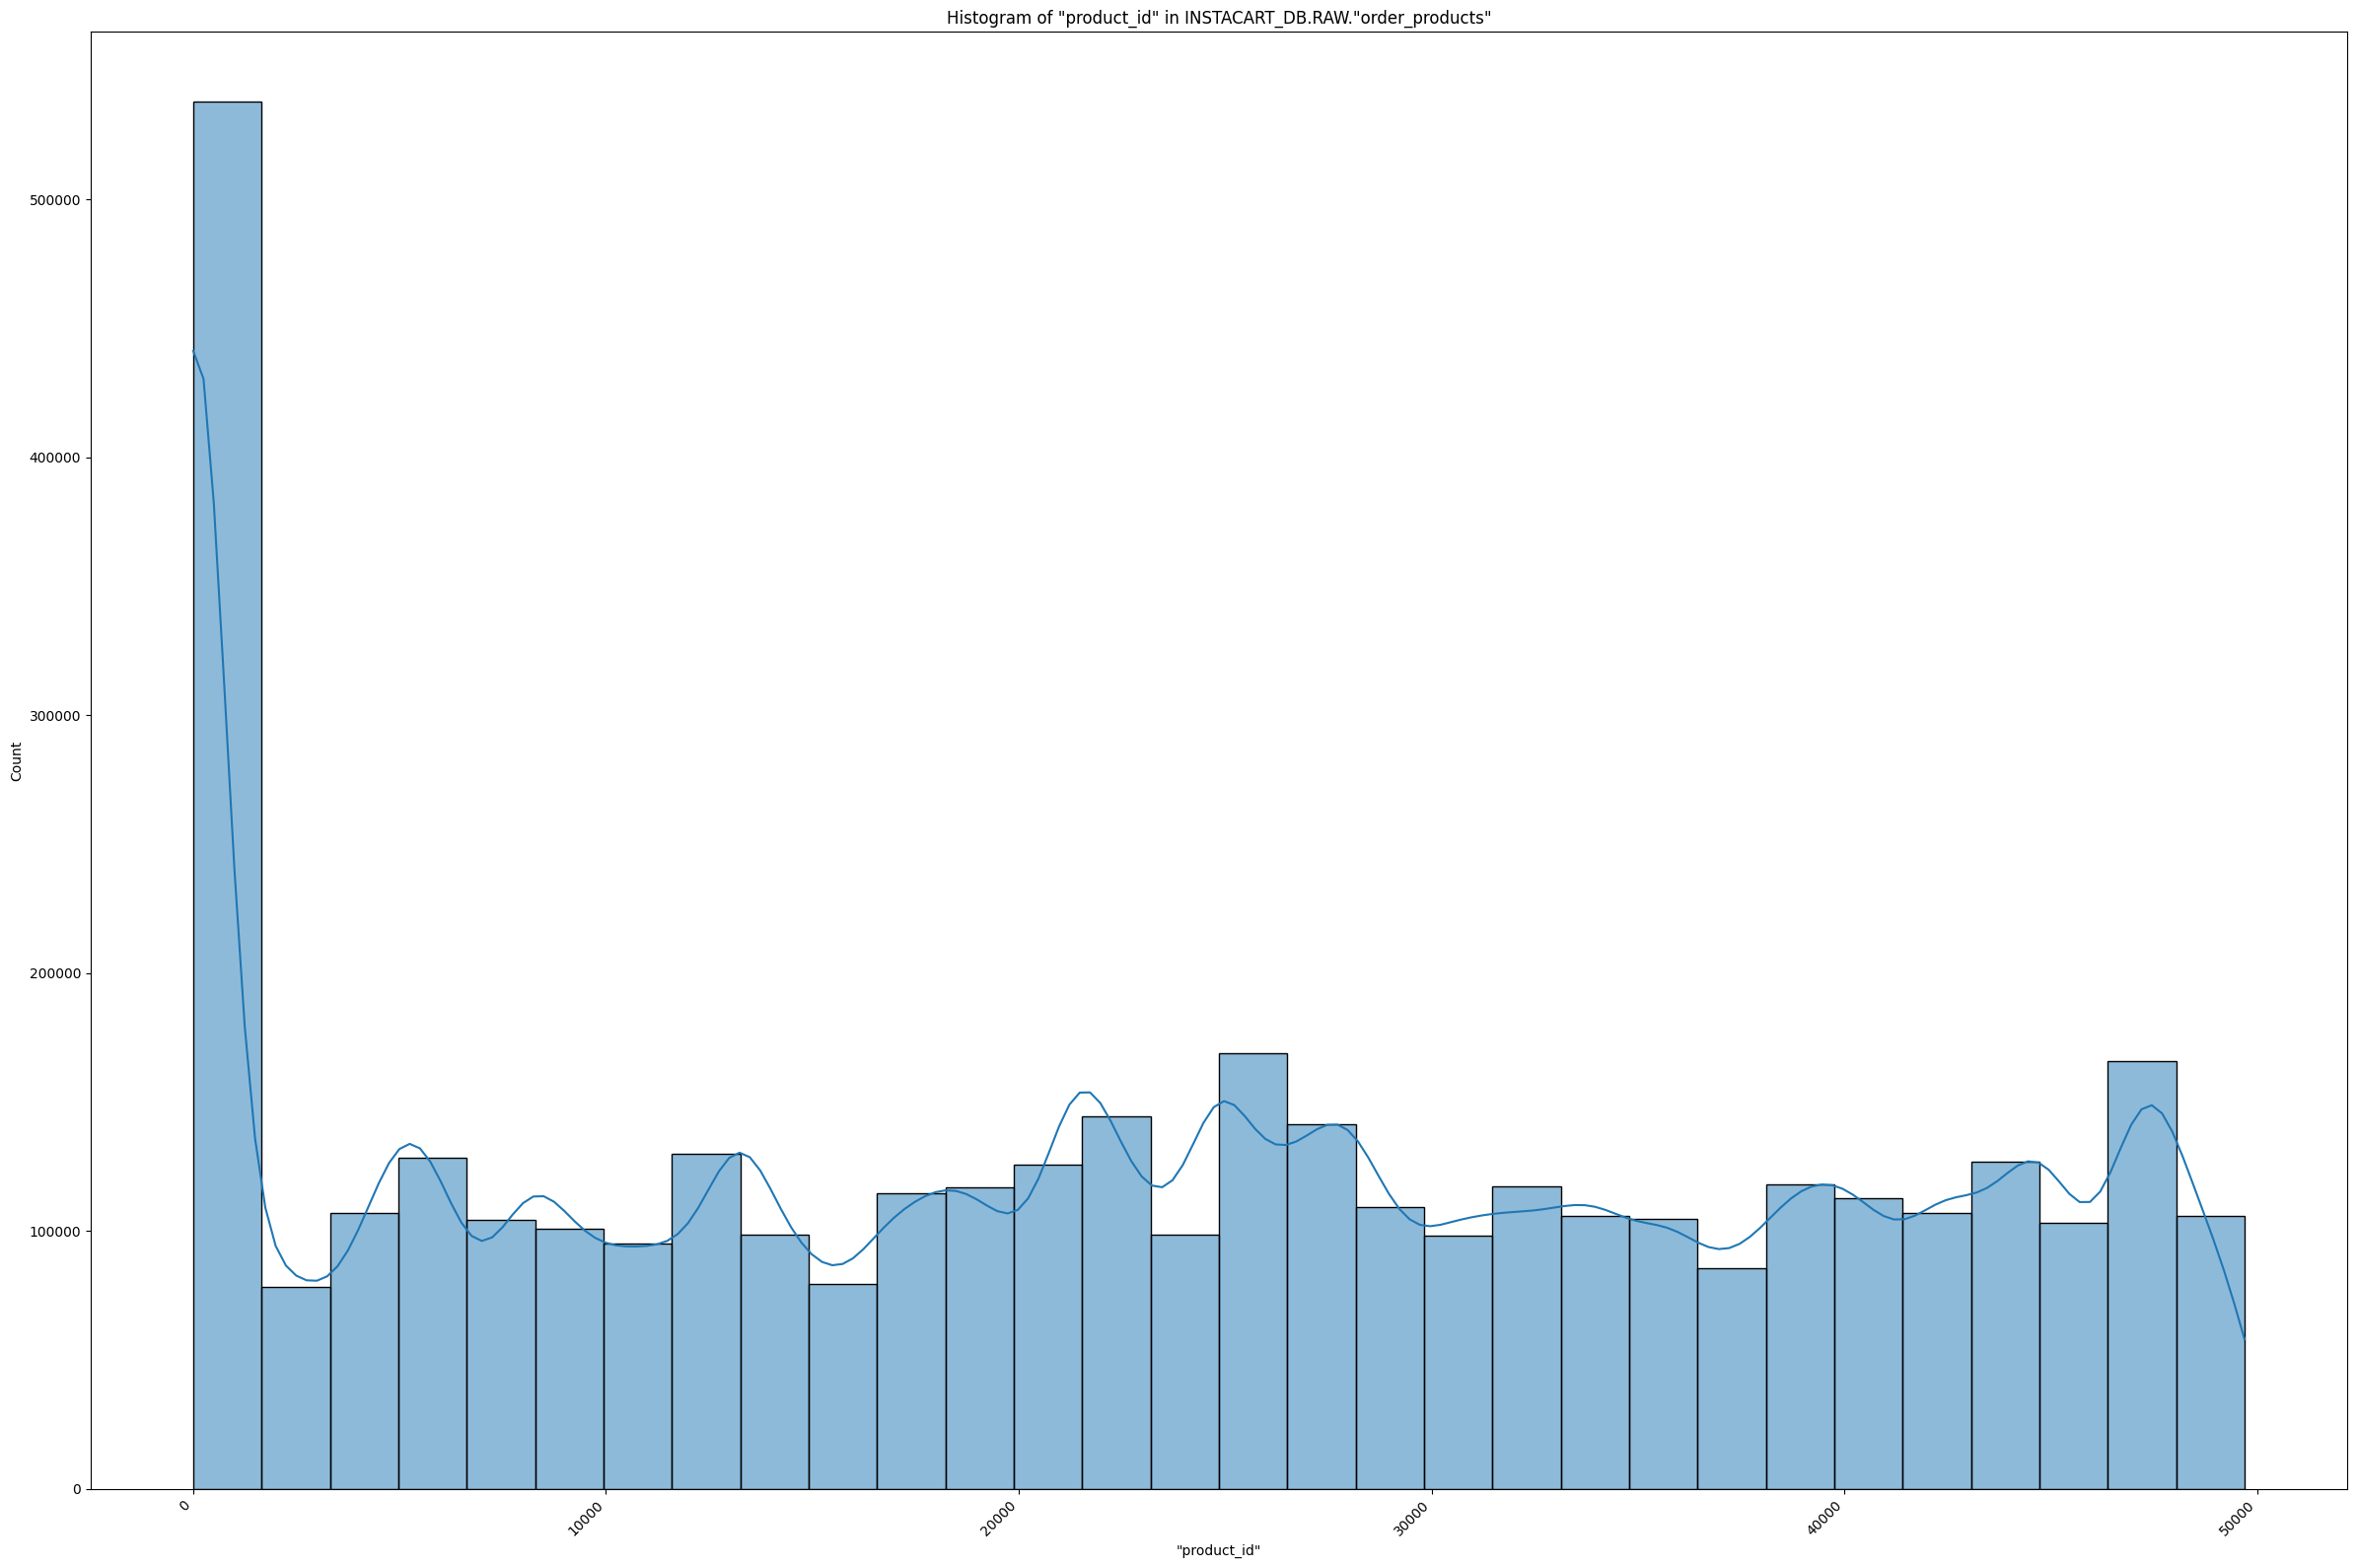

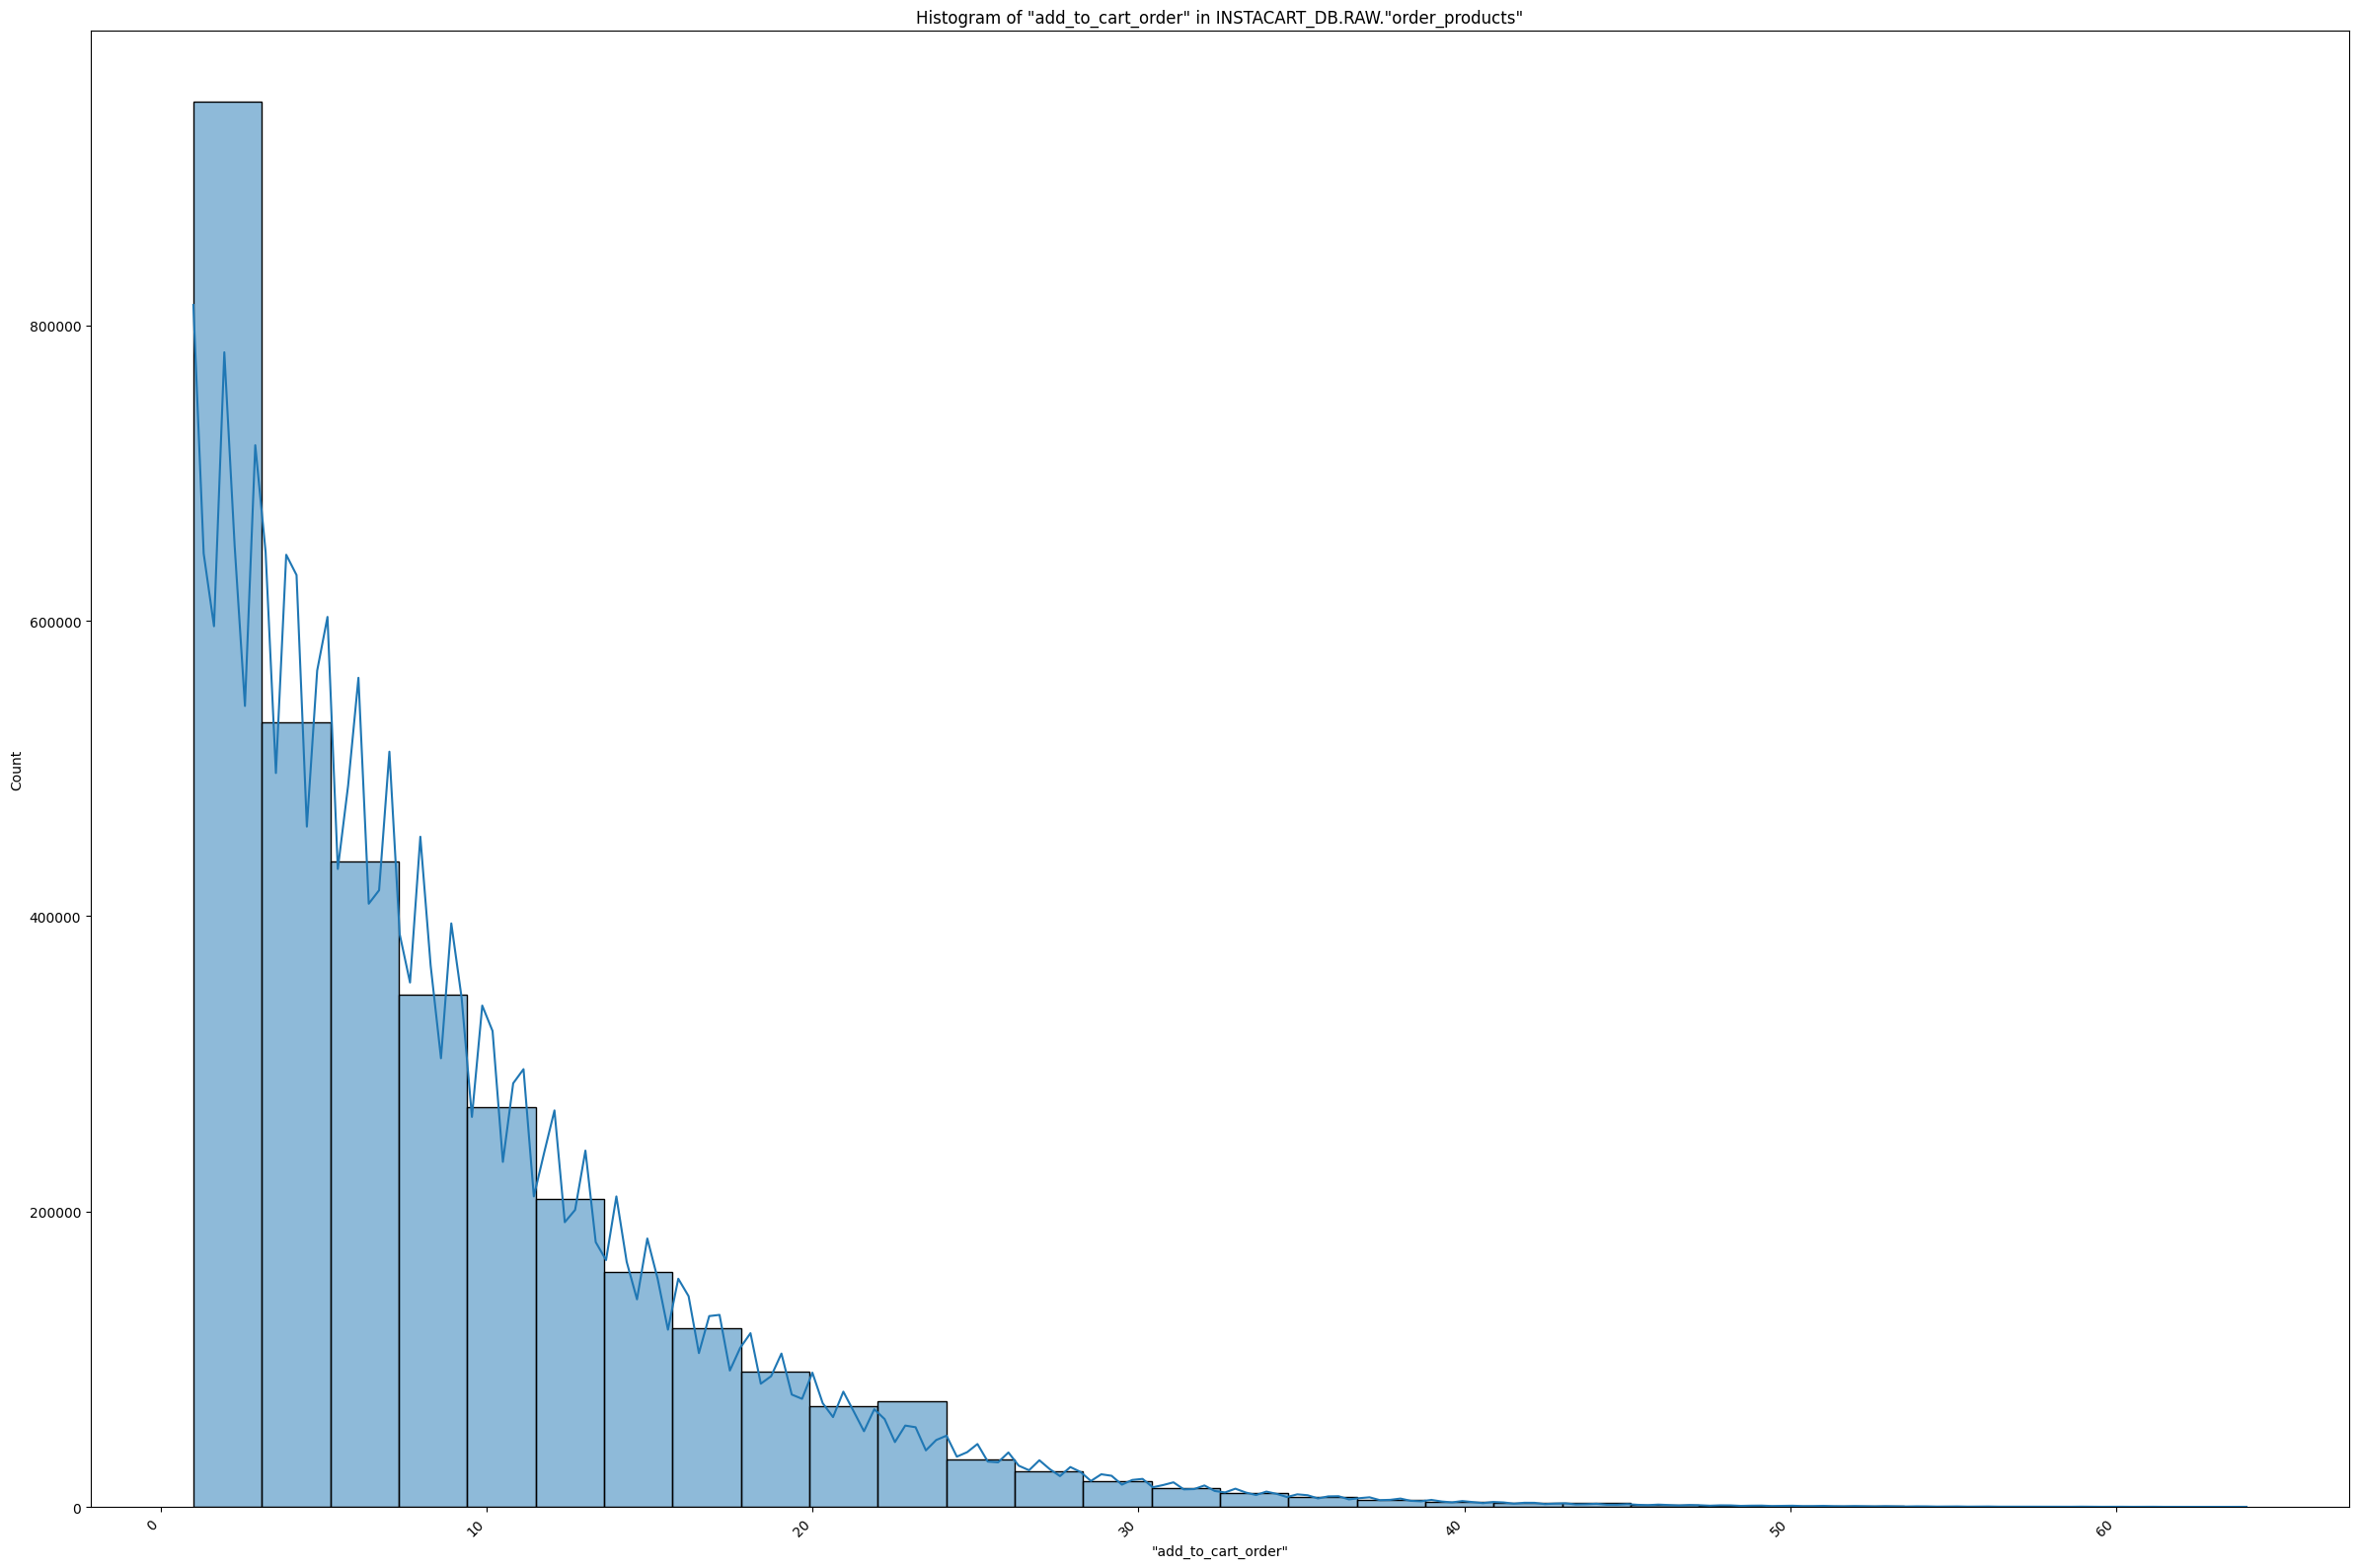

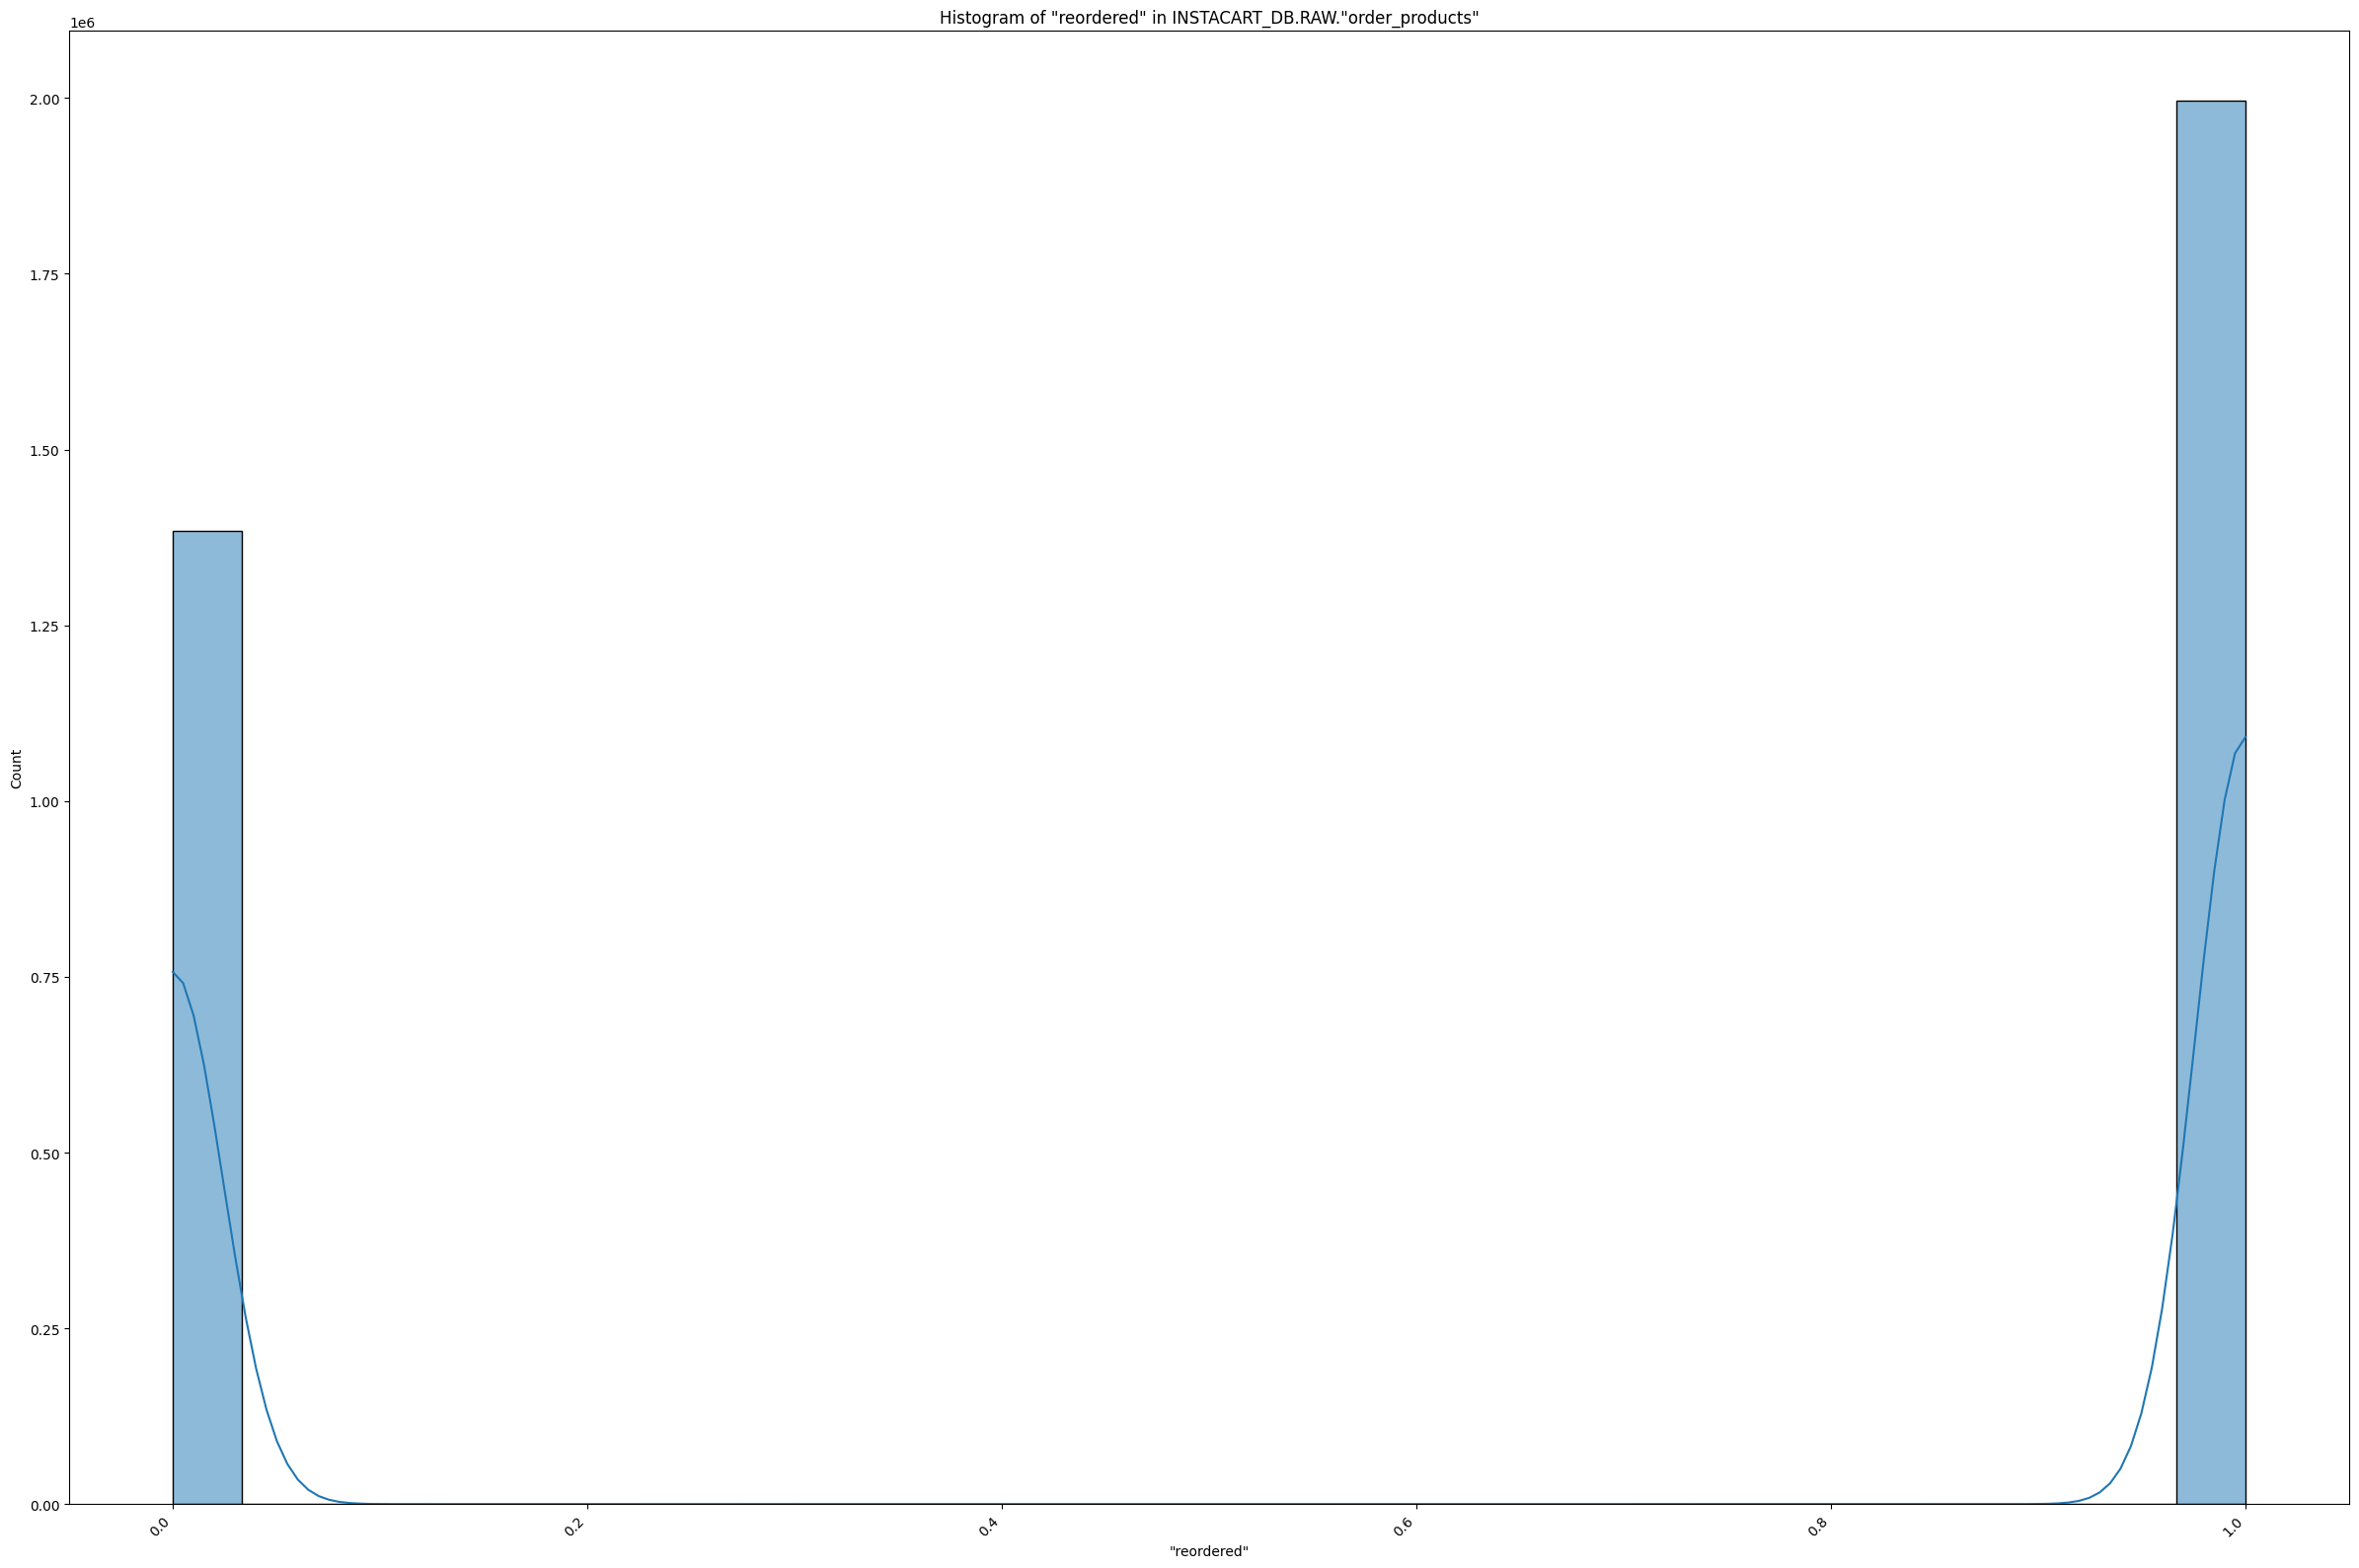

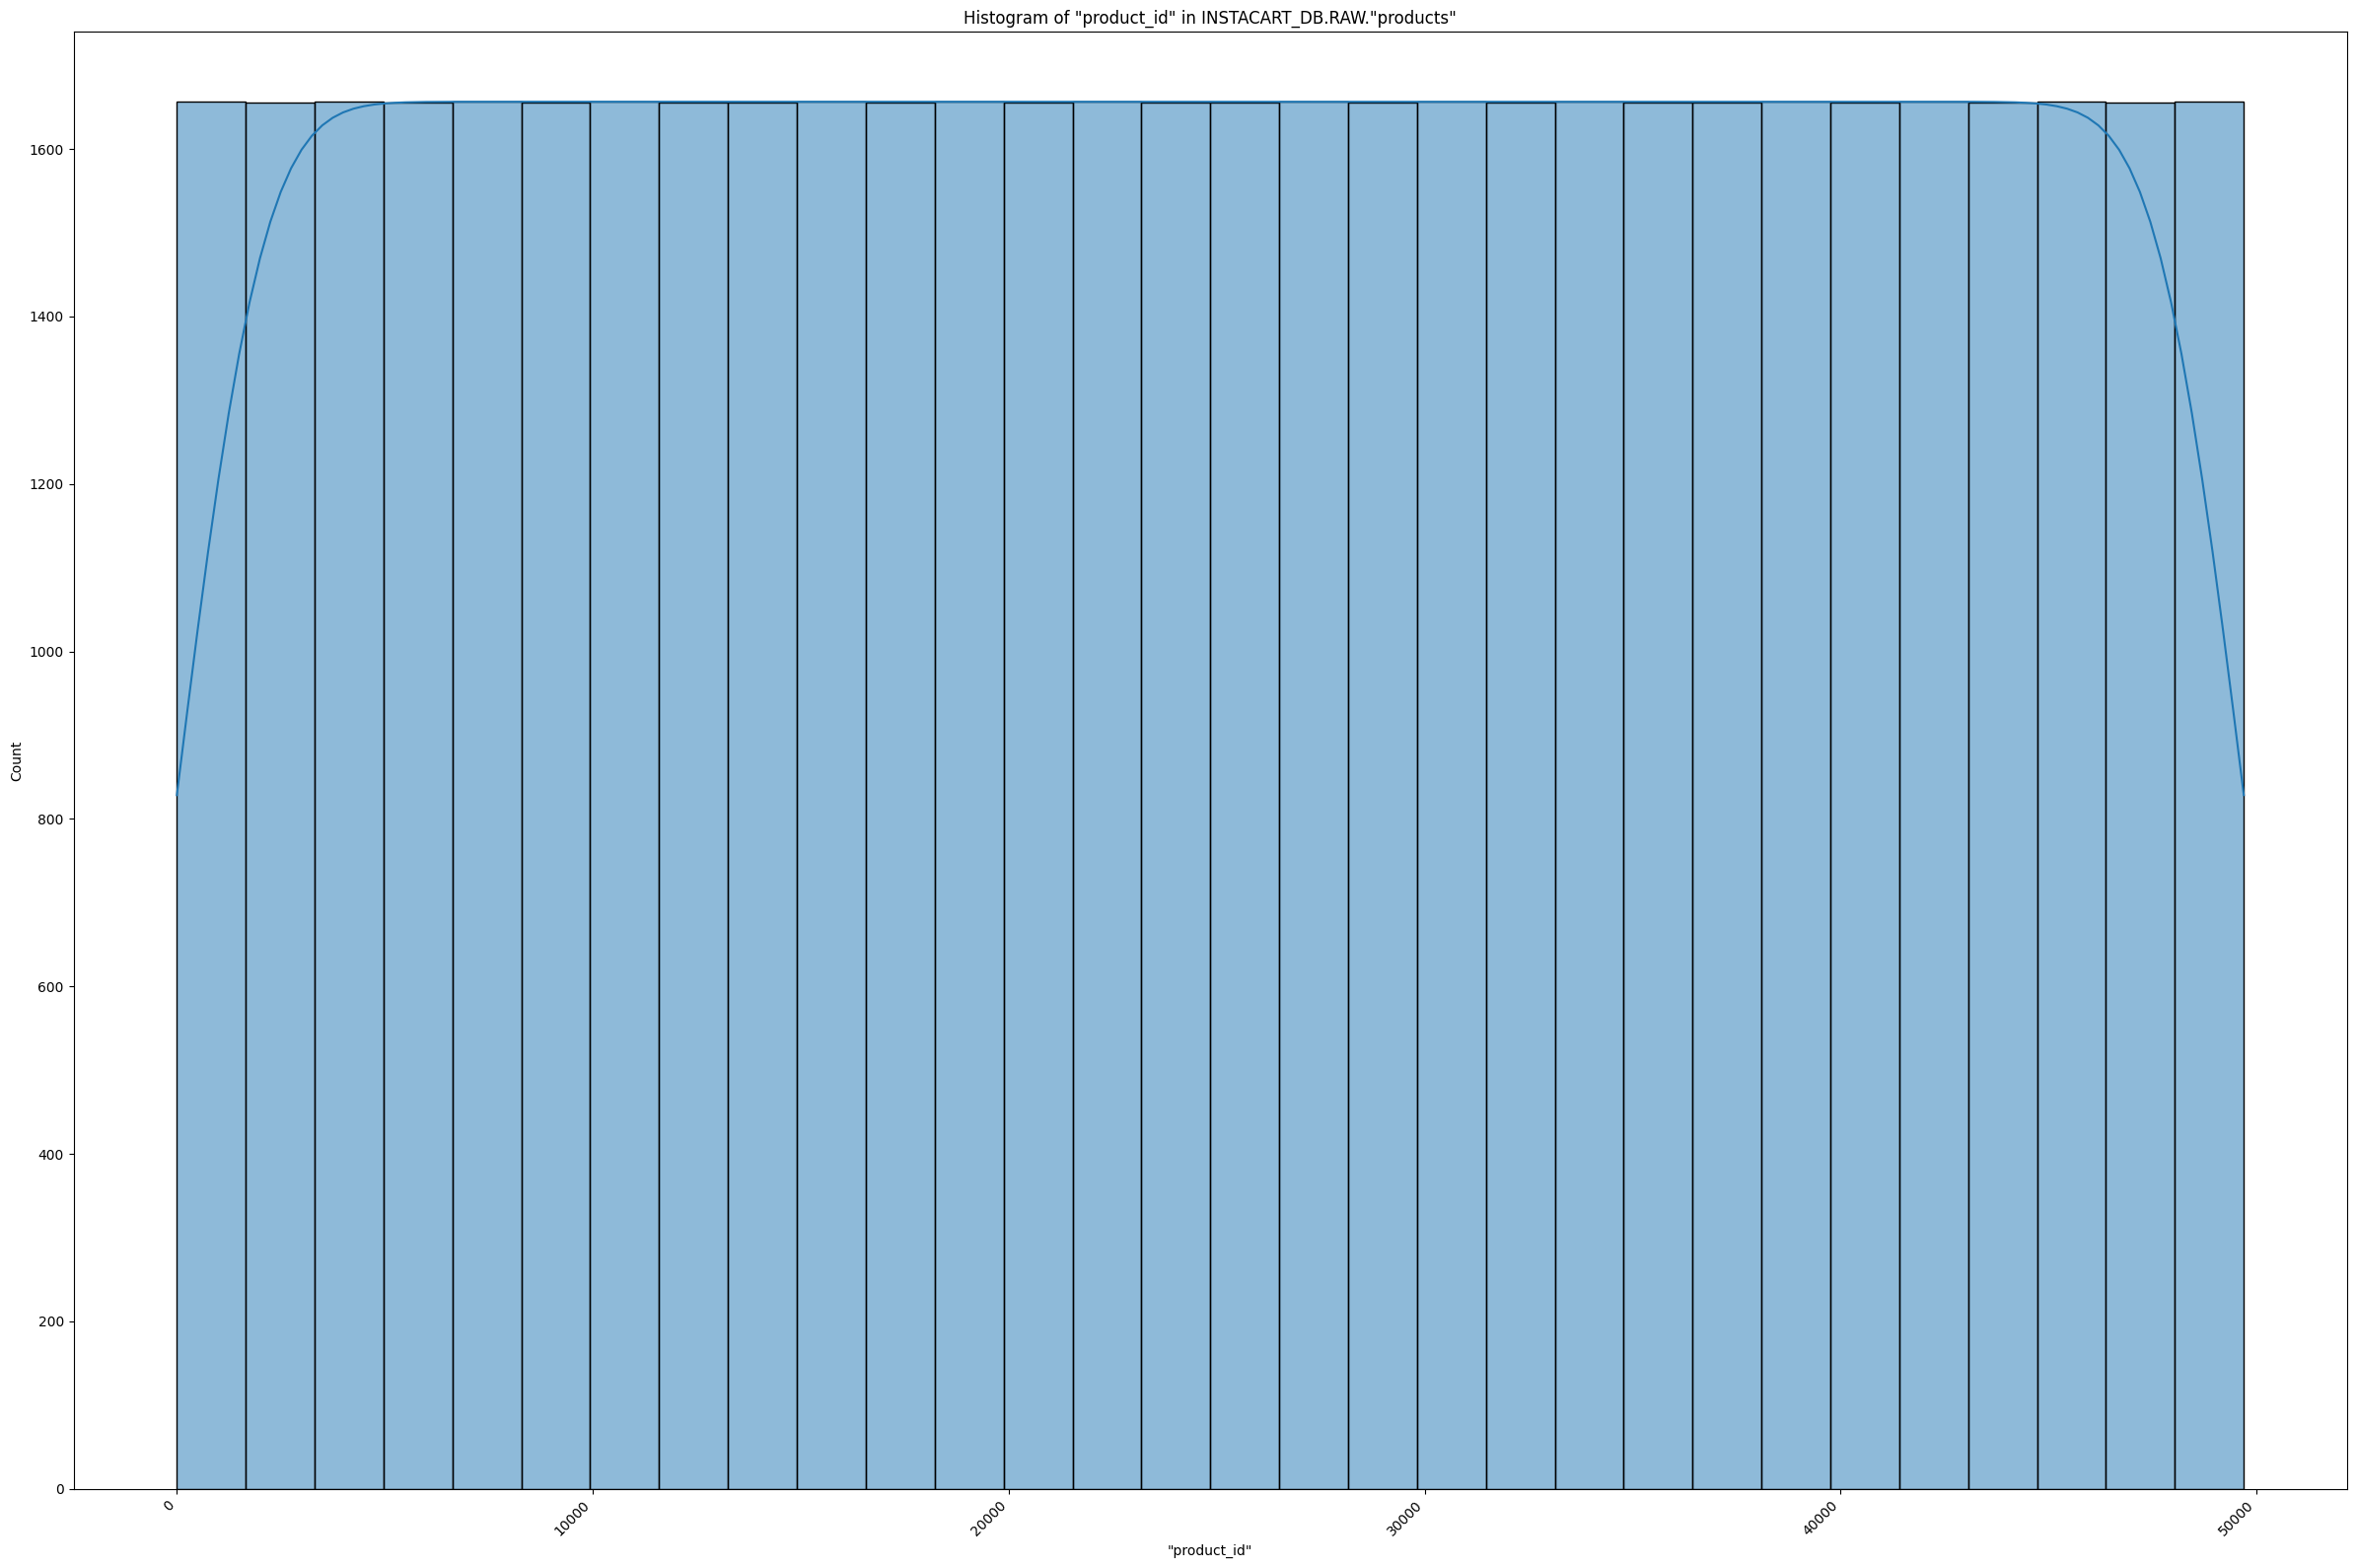

/tmp/ipykernel_27941/1001451688.py:28: UserWarning: Glyph 143 (\x8f) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/root/instacart_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 143 (\x8f) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the tables and their columns with fully qualified names
table_columns = {
    "INSTACART_DB.RAW.\"aisles\"": ["\"aisle_id\"", "\"aisle\""],
    "INSTACART_DB.RAW.\"departments\"": ["\"department_id\"", "\"department\""],
    "INSTACART_DB.RAW.\"instacart_orders\"": ["\"order_id\"", "\"user_id\"", "\"order_number\"", "\"order_dow\"", "\"order_hour_of_day\"", "\"days_since_prior_order\""],
    "INSTACART_DB.RAW.\"order_products\"": ["\"order_id\"", "\"product_id\"", "\"add_to_cart_order\"", "\"reordered\""],
    "INSTACART_DB.RAW.\"products\"": ["\"product_id\"", "\"product_name\"", "\"aisle_id\"", "\"department_id\""]
}

# Loop through each table and its columns to generate histograms
for table, cols in table_columns.items():
    for col in cols:
        query = f"SELECT {col} FROM {table} WHERE {col} IS NOT NULL"
        cur.execute(query)
        df = pd.DataFrame(cur.fetchall(), columns=[col])
        
        plt.figure(figsize=(24, 16))
        sns.histplot(df[col], bins=30, kde=True)
        plt.title(f"Histogram of {col} in {table}")
        
        # Rotate x-axis labels for better readability
        plt.xticks(rotation=45, ha='right',fontsize=10)
        
        # Adjust the layout to prevent overlap
        plt.tight_layout()
        
        plt.show()


In [ ]:
# Close the cursor and connection
cur.close()
conn.close()